In [1]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D, Embedding, Concatenate

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [2]:
noise_dim = 100

In [3]:
(trainSamples, trainLabels), (testSamples, testLabels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_filter = np.where((trainLabels == 2 ) ) #| (trainLabels == 4)
test_filter = np.where((testLabels == 2) ) # | (testLabels == 4)

In [5]:
trainSamples, trainLabels = trainSamples[train_filter], trainLabels[train_filter]
testSamples, testLabels = testSamples[test_filter], testLabels[test_filter]

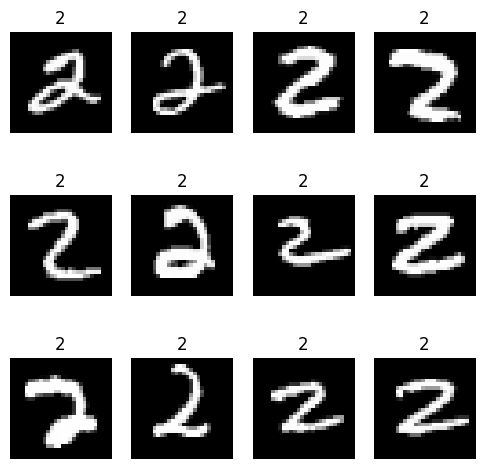

In [6]:
plt.figure(figsize=(6, 6))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(trainSamples[i][:,:],cmap='gray')
    plt.title(trainLabels[i])
    plt.axis("off")

In [7]:
trainSamples.shape

(5958, 28, 28)

In [8]:
# Generator gets a noise vector of size noise_dim and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible

def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 8 x 8 x 128


    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 16 x 16 x 64

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    #model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # output: 32 x 32 x 1 (our image)

    model.summary()
    return model

generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [9]:
# Discriminator gets image of size (32 x 32 x 1) and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #model.add(Dense(1))
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
# returns randomly choosen n samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)

    return new_samples

In [11]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [12]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct:
        if x>=0.5:
            ok+=1
    return ok

# The training step

history = []
##@tf.function
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    #noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator(input_noise, training=True)
        # evaluate fake images
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        # evaluate real images
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    print("Epoch",epoch+4000,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])

Epoch 4000 g_loss= 0.7394768 d_loss= 14.074494 real_acc= 0.18 fake_acc= 0.96


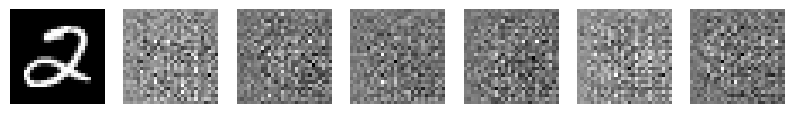

Epoch 4001 g_loss= 0.7028428 d_loss= 3.8883114 real_acc= 0.62 fake_acc= 0.62
Epoch 4002 g_loss= 0.6749589 d_loss= 1.2702122 real_acc= 0.88 fake_acc= 0.26
Epoch 4003 g_loss= 0.6438552 d_loss= 1.0415497 real_acc= 0.94 fake_acc= 0.06
Epoch 4004 g_loss= 0.6136301 d_loss= 0.78286815 real_acc= 1.0 fake_acc= 0.0
Epoch 4005 g_loss= 0.5976968 d_loss= 0.7999883 real_acc= 1.0 fake_acc= 0.0
Epoch 4006 g_loss= 0.5768105 d_loss= 0.82633823 real_acc= 1.0 fake_acc= 0.0
Epoch 4007 g_loss= 0.56038225 d_loss= 0.84803003 real_acc= 1.0 fake_acc= 0.0
Epoch 4008 g_loss= 0.54966855 d_loss= 0.86275667 real_acc= 1.0 fake_acc= 0.0
Epoch 4009 g_loss= 0.53582364 d_loss= 0.8817112 real_acc= 1.0 fake_acc= 0.0
Epoch 4010 g_loss= 0.5234828 d_loss= 0.89922255 real_acc= 1.0 fake_acc= 0.0


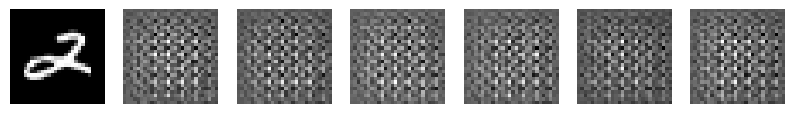

Epoch 4011 g_loss= 0.5141461 d_loss= 0.9129004 real_acc= 1.0 fake_acc= 0.0
Epoch 4012 g_loss= 0.49735928 d_loss= 0.9387476 real_acc= 1.0 fake_acc= 0.0
Epoch 4013 g_loss= 0.48811206 d_loss= 0.9528134 real_acc= 1.0 fake_acc= 0.0
Epoch 4014 g_loss= 0.47859237 d_loss= 0.9687258 real_acc= 1.0 fake_acc= 0.0
Epoch 4015 g_loss= 0.47050735 d_loss= 0.9815363 real_acc= 1.0 fake_acc= 0.0
Epoch 4016 g_loss= 0.47333205 d_loss= 0.9765971 real_acc= 1.0 fake_acc= 0.0
Epoch 4017 g_loss= 0.4657207 d_loss= 0.989825 real_acc= 1.0 fake_acc= 0.0
Epoch 4018 g_loss= 0.456054 d_loss= 1.0063958 real_acc= 1.0 fake_acc= 0.0
Epoch 4019 g_loss= 0.45256516 d_loss= 1.0132018 real_acc= 1.0 fake_acc= 0.0
Epoch 4020 g_loss= 0.4399091 d_loss= 1.0351825 real_acc= 1.0 fake_acc= 0.0


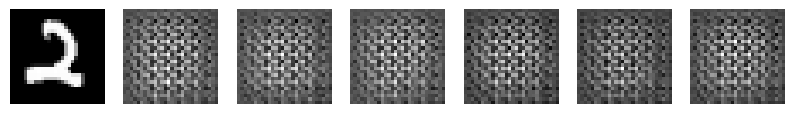

Epoch 4021 g_loss= 0.4408321 d_loss= 1.0336059 real_acc= 1.0 fake_acc= 0.0
Epoch 4022 g_loss= 0.43759736 d_loss= 1.0399606 real_acc= 1.0 fake_acc= 0.0
Epoch 4023 g_loss= 0.43169713 d_loss= 1.0507754 real_acc= 1.0 fake_acc= 0.0
Epoch 4024 g_loss= 0.4289183 d_loss= 1.0560131 real_acc= 1.0 fake_acc= 0.0
Epoch 4025 g_loss= 0.4266387 d_loss= 1.0600057 real_acc= 1.0 fake_acc= 0.0
Epoch 4026 g_loss= 0.42754692 d_loss= 1.0579532 real_acc= 1.0 fake_acc= 0.0
Epoch 4027 g_loss= 0.43382007 d_loss= 1.0465851 real_acc= 1.0 fake_acc= 0.0
Epoch 4028 g_loss= 0.42517877 d_loss= 1.0639904 real_acc= 1.0 fake_acc= 0.0
Epoch 4029 g_loss= 0.42441005 d_loss= 1.0649742 real_acc= 1.0 fake_acc= 0.0
Epoch 4030 g_loss= 0.41896573 d_loss= 1.074631 real_acc= 1.0 fake_acc= 0.0


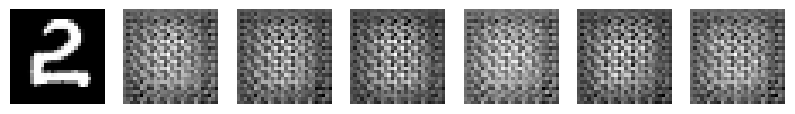

Epoch 4031 g_loss= 0.42278126 d_loss= 1.068875 real_acc= 1.0 fake_acc= 0.0
Epoch 4032 g_loss= 0.42891282 d_loss= 1.0552074 real_acc= 1.0 fake_acc= 0.0
Epoch 4033 g_loss= 0.41829067 d_loss= 1.0758568 real_acc= 1.0 fake_acc= 0.0
Epoch 4034 g_loss= 0.42941856 d_loss= 1.0543557 real_acc= 1.0 fake_acc= 0.0
Epoch 4035 g_loss= 0.42165768 d_loss= 1.0699779 real_acc= 1.0 fake_acc= 0.0
Epoch 4036 g_loss= 0.4258693 d_loss= 1.0608621 real_acc= 1.0 fake_acc= 0.0
Epoch 4037 g_loss= 0.43008024 d_loss= 1.0550159 real_acc= 1.0 fake_acc= 0.0
Epoch 4038 g_loss= 0.4289055 d_loss= 1.0561459 real_acc= 1.0 fake_acc= 0.0
Epoch 4039 g_loss= 0.42628324 d_loss= 1.0601125 real_acc= 1.0 fake_acc= 0.0
Epoch 4040 g_loss= 0.43429616 d_loss= 1.0462315 real_acc= 1.0 fake_acc= 0.0


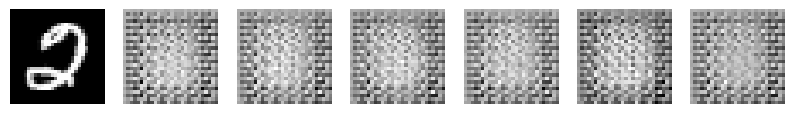

Epoch 4041 g_loss= 0.42581883 d_loss= 1.0617938 real_acc= 1.0 fake_acc= 0.0
Epoch 4042 g_loss= 0.43659574 d_loss= 1.0412942 real_acc= 1.0 fake_acc= 0.0
Epoch 4043 g_loss= 0.4341061 d_loss= 1.0458095 real_acc= 1.0 fake_acc= 0.0
Epoch 4044 g_loss= 0.43699932 d_loss= 1.0410943 real_acc= 1.0 fake_acc= 0.0
Epoch 4045 g_loss= 0.44053966 d_loss= 1.0352497 real_acc= 1.0 fake_acc= 0.0
Epoch 4046 g_loss= 0.43843156 d_loss= 1.0386386 real_acc= 1.0 fake_acc= 0.0
Epoch 4047 g_loss= 0.45072553 d_loss= 1.0157077 real_acc= 1.0 fake_acc= 0.0
Epoch 4048 g_loss= 0.4468028 d_loss= 1.0235614 real_acc= 1.0 fake_acc= 0.0
Epoch 4049 g_loss= 0.45061135 d_loss= 1.0169697 real_acc= 1.0 fake_acc= 0.0
Epoch 4050 g_loss= 0.45096892 d_loss= 1.0157912 real_acc= 1.0 fake_acc= 0.0


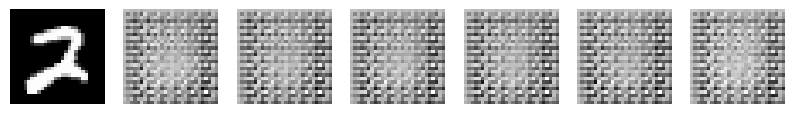

Epoch 4051 g_loss= 0.45827836 d_loss= 1.0031946 real_acc= 1.0 fake_acc= 0.0
Epoch 4052 g_loss= 0.4600647 d_loss= 0.9993801 real_acc= 1.0 fake_acc= 0.0
Epoch 4053 g_loss= 0.46422252 d_loss= 0.99263275 real_acc= 1.0 fake_acc= 0.0
Epoch 4054 g_loss= 0.46100974 d_loss= 0.9984834 real_acc= 1.0 fake_acc= 0.0
Epoch 4055 g_loss= 0.46286327 d_loss= 0.993979 real_acc= 1.0 fake_acc= 0.0
Epoch 4056 g_loss= 0.47598842 d_loss= 0.97250557 real_acc= 1.0 fake_acc= 0.0
Epoch 4057 g_loss= 0.47031078 d_loss= 0.9824064 real_acc= 1.0 fake_acc= 0.0
Epoch 4058 g_loss= 0.47336552 d_loss= 0.9774115 real_acc= 1.0 fake_acc= 0.0
Epoch 4059 g_loss= 0.47432384 d_loss= 0.9759464 real_acc= 1.0 fake_acc= 0.0
Epoch 4060 g_loss= 0.48418435 d_loss= 0.9597583 real_acc= 1.0 fake_acc= 0.0


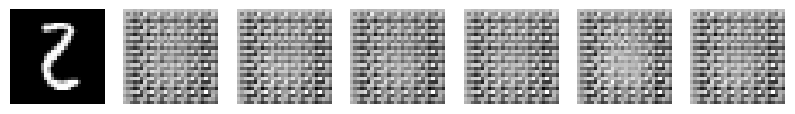

Epoch 4061 g_loss= 0.4881853 d_loss= 0.9531279 real_acc= 1.0 fake_acc= 0.0
Epoch 4062 g_loss= 0.50050366 d_loss= 0.9346582 real_acc= 1.0 fake_acc= 0.0
Epoch 4063 g_loss= 0.48683003 d_loss= 0.95543444 real_acc= 1.0 fake_acc= 0.0
Epoch 4064 g_loss= 0.4976925 d_loss= 0.9381857 real_acc= 1.0 fake_acc= 0.0
Epoch 4065 g_loss= 0.4946722 d_loss= 0.94296616 real_acc= 1.0 fake_acc= 0.0
Epoch 4066 g_loss= 0.5047467 d_loss= 0.9273217 real_acc= 1.0 fake_acc= 0.0
Epoch 4067 g_loss= 0.5083183 d_loss= 0.9229177 real_acc= 1.0 fake_acc= 0.0
Epoch 4068 g_loss= 0.50474536 d_loss= 0.9274576 real_acc= 1.0 fake_acc= 0.0
Epoch 4069 g_loss= 0.50309145 d_loss= 0.9297123 real_acc= 1.0 fake_acc= 0.0
Epoch 4070 g_loss= 0.51353556 d_loss= 0.9146078 real_acc= 1.0 fake_acc= 0.0


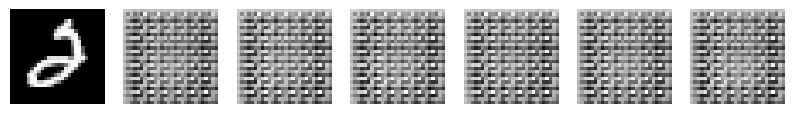

Epoch 4071 g_loss= 0.5096768 d_loss= 0.91966337 real_acc= 1.0 fake_acc= 0.0
Epoch 4072 g_loss= 0.5144851 d_loss= 0.9122723 real_acc= 1.0 fake_acc= 0.0
Epoch 4073 g_loss= 0.52494997 d_loss= 0.89695907 real_acc= 1.0 fake_acc= 0.0
Epoch 4074 g_loss= 0.5225979 d_loss= 0.89997995 real_acc= 1.0 fake_acc= 0.0
Epoch 4075 g_loss= 0.5293069 d_loss= 0.8906514 real_acc= 1.0 fake_acc= 0.0
Epoch 4076 g_loss= 0.52740633 d_loss= 0.8937159 real_acc= 1.0 fake_acc= 0.0
Epoch 4077 g_loss= 0.5259972 d_loss= 0.896414 real_acc= 1.0 fake_acc= 0.0
Epoch 4078 g_loss= 0.53861123 d_loss= 0.87765753 real_acc= 1.0 fake_acc= 0.0
Epoch 4079 g_loss= 0.54002684 d_loss= 0.87596756 real_acc= 1.0 fake_acc= 0.0
Epoch 4080 g_loss= 0.54558766 d_loss= 0.8674453 real_acc= 1.0 fake_acc= 0.0


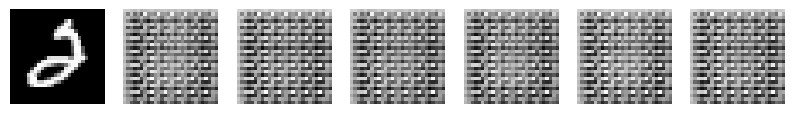

Epoch 4081 g_loss= 0.5447057 d_loss= 0.8691047 real_acc= 1.0 fake_acc= 0.0
Epoch 4082 g_loss= 0.55559546 d_loss= 0.85427773 real_acc= 1.0 fake_acc= 0.0
Epoch 4083 g_loss= 0.5498034 d_loss= 0.86221665 real_acc= 1.0 fake_acc= 0.0
Epoch 4084 g_loss= 0.5551827 d_loss= 0.8547459 real_acc= 1.0 fake_acc= 0.0
Epoch 4085 g_loss= 0.55683905 d_loss= 0.8525633 real_acc= 1.0 fake_acc= 0.0
Epoch 4086 g_loss= 0.55922735 d_loss= 0.8495287 real_acc= 1.0 fake_acc= 0.0
Epoch 4087 g_loss= 0.5634517 d_loss= 0.8438819 real_acc= 1.0 fake_acc= 0.0
Epoch 4088 g_loss= 0.5670586 d_loss= 0.83842176 real_acc= 1.0 fake_acc= 0.0
Epoch 4089 g_loss= 0.5681649 d_loss= 0.83715004 real_acc= 1.0 fake_acc= 0.0
Epoch 4090 g_loss= 0.5689941 d_loss= 0.8362276 real_acc= 1.0 fake_acc= 0.0


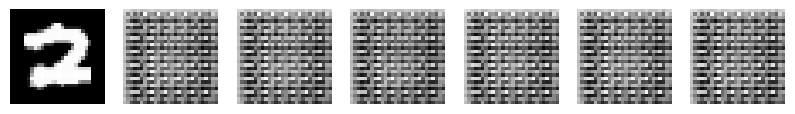

Epoch 4091 g_loss= 0.57458377 d_loss= 0.82951784 real_acc= 1.0 fake_acc= 0.0
Epoch 4092 g_loss= 0.5744191 d_loss= 0.82919765 real_acc= 1.0 fake_acc= 0.0
Epoch 4093 g_loss= 0.582989 d_loss= 0.8181422 real_acc= 1.0 fake_acc= 0.0
Epoch 4094 g_loss= 0.5891542 d_loss= 0.8110671 real_acc= 1.0 fake_acc= 0.0
Epoch 4095 g_loss= 0.5866821 d_loss= 0.8134397 real_acc= 1.0 fake_acc= 0.0
Epoch 4096 g_loss= 0.59572035 d_loss= 0.80259275 real_acc= 1.0 fake_acc= 0.0
Epoch 4097 g_loss= 0.5932305 d_loss= 0.8052453 real_acc= 1.0 fake_acc= 0.0
Epoch 4098 g_loss= 0.6086148 d_loss= 0.78717536 real_acc= 1.0 fake_acc= 0.0
Epoch 4099 g_loss= 0.6057182 d_loss= 0.79040766 real_acc= 1.0 fake_acc= 0.0
Epoch 4100 g_loss= 0.61071044 d_loss= 0.7841465 real_acc= 1.0 fake_acc= 0.02


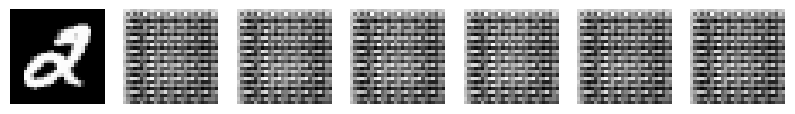

Epoch 4101 g_loss= 0.6066507 d_loss= 0.7890346 real_acc= 1.0 fake_acc= 0.0
Epoch 4102 g_loss= 0.62105054 d_loss= 0.77223045 real_acc= 1.0 fake_acc= 0.02
Epoch 4103 g_loss= 0.6182915 d_loss= 0.79991984 real_acc= 0.98 fake_acc= 0.0
Epoch 4104 g_loss= 0.62422234 d_loss= 0.7687168 real_acc= 1.0 fake_acc= 0.02
Epoch 4105 g_loss= 0.62102044 d_loss= 0.7720808 real_acc= 1.0 fake_acc= 0.0
Epoch 4106 g_loss= 0.6272286 d_loss= 0.7652338 real_acc= 1.0 fake_acc= 0.02
Epoch 4107 g_loss= 0.6273074 d_loss= 0.76473683 real_acc= 1.0 fake_acc= 0.04
Epoch 4108 g_loss= 0.6343427 d_loss= 0.7570458 real_acc= 1.0 fake_acc= 0.08
Epoch 4109 g_loss= 0.6423037 d_loss= 0.748487 real_acc= 1.0 fake_acc= 0.1
Epoch 4110 g_loss= 0.6342526 d_loss= 0.75735 real_acc= 1.0 fake_acc= 0.04


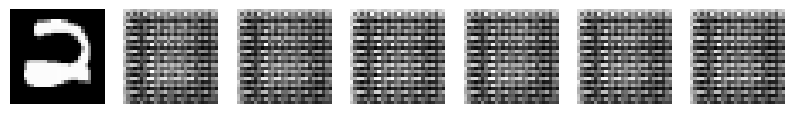

Epoch 4111 g_loss= 0.6364286 d_loss= 0.7541862 real_acc= 1.0 fake_acc= 0.02
Epoch 4112 g_loss= 0.63980186 d_loss= 0.75085795 real_acc= 1.0 fake_acc= 0.04
Epoch 4113 g_loss= 0.641588 d_loss= 0.7486235 real_acc= 1.0 fake_acc= 0.06
Epoch 4114 g_loss= 0.64811987 d_loss= 0.74255645 real_acc= 1.0 fake_acc= 0.08
Epoch 4115 g_loss= 0.64882004 d_loss= 0.7415554 real_acc= 1.0 fake_acc= 0.08
Epoch 4116 g_loss= 0.65517515 d_loss= 0.73412114 real_acc= 1.0 fake_acc= 0.14
Epoch 4117 g_loss= 0.6574157 d_loss= 0.73294103 real_acc= 1.0 fake_acc= 0.14
Epoch 4118 g_loss= 0.66349965 d_loss= 0.72475517 real_acc= 1.0 fake_acc= 0.18
Epoch 4119 g_loss= 0.664175 d_loss= 0.72405386 real_acc= 1.0 fake_acc= 0.16
Epoch 4120 g_loss= 0.65710145 d_loss= 0.7318318 real_acc= 1.0 fake_acc= 0.1


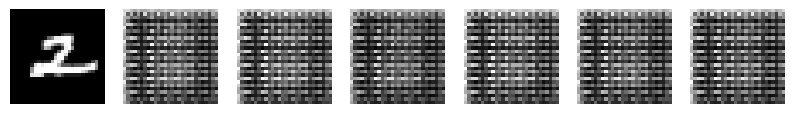

Epoch 4121 g_loss= 0.66556287 d_loss= 0.83432055 real_acc= 0.96 fake_acc= 0.2
Epoch 4122 g_loss= 0.662738 d_loss= 0.7260167 real_acc= 1.0 fake_acc= 0.22
Epoch 4123 g_loss= 0.6746554 d_loss= 0.7128655 real_acc= 1.0 fake_acc= 0.2
Epoch 4124 g_loss= 0.67467153 d_loss= 0.7129584 real_acc= 1.0 fake_acc= 0.24
Epoch 4125 g_loss= 0.6692035 d_loss= 0.71882373 real_acc= 1.0 fake_acc= 0.2
Epoch 4126 g_loss= 0.6752172 d_loss= 0.7126339 real_acc= 1.0 fake_acc= 0.28
Epoch 4127 g_loss= 0.67825526 d_loss= 0.709527 real_acc= 1.0 fake_acc= 0.34
Epoch 4128 g_loss= 0.6838929 d_loss= 0.703604 real_acc= 1.0 fake_acc= 0.3
Epoch 4129 g_loss= 0.68127114 d_loss= 0.7066099 real_acc= 1.0 fake_acc= 0.36
Epoch 4130 g_loss= 0.69317544 d_loss= 0.71132565 real_acc= 0.98 fake_acc= 0.54


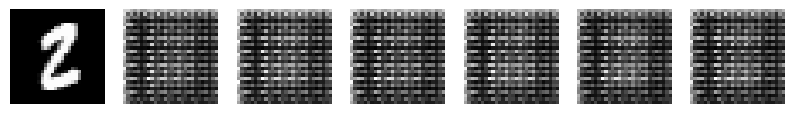

Epoch 4131 g_loss= 0.69654584 d_loss= 0.7019613 real_acc= 1.0 fake_acc= 0.6
Epoch 4132 g_loss= 0.67901367 d_loss= 0.709225 real_acc= 1.0 fake_acc= 0.26
Epoch 4133 g_loss= 0.6918762 d_loss= 0.6955324 real_acc= 1.0 fake_acc= 0.48
Epoch 4134 g_loss= 0.6946627 d_loss= 0.6926672 real_acc= 1.0 fake_acc= 0.48
Epoch 4135 g_loss= 0.69203275 d_loss= 0.7847689 real_acc= 0.98 fake_acc= 0.4
Epoch 4136 g_loss= 0.69674456 d_loss= 0.69083744 real_acc= 1.0 fake_acc= 0.58
Epoch 4137 g_loss= 0.69343203 d_loss= 0.7039591 real_acc= 1.0 fake_acc= 0.48
Epoch 4138 g_loss= 0.7017669 d_loss= 0.7268735 real_acc= 0.98 fake_acc= 0.56
Epoch 4139 g_loss= 0.7062248 d_loss= 0.6851773 real_acc= 1.0 fake_acc= 0.6
Epoch 4140 g_loss= 0.6963397 d_loss= 0.6917934 real_acc= 1.0 fake_acc= 0.52


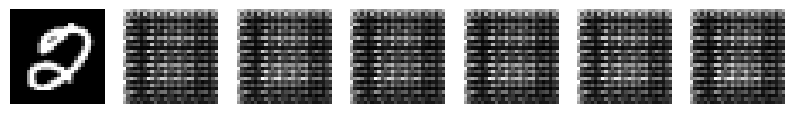

Epoch 4141 g_loss= 0.6929586 d_loss= 0.6947831 real_acc= 1.0 fake_acc= 0.46
Epoch 4142 g_loss= 0.7063233 d_loss= 0.7020414 real_acc= 0.98 fake_acc= 0.7
Epoch 4143 g_loss= 0.70466965 d_loss= 0.7278643 real_acc= 0.98 fake_acc= 0.66
Epoch 4144 g_loss= 0.6939613 d_loss= 0.7008576 real_acc= 1.0 fake_acc= 0.52
Epoch 4145 g_loss= 0.69585603 d_loss= 0.79726446 real_acc= 0.98 fake_acc= 0.6
Epoch 4146 g_loss= 0.7007401 d_loss= 0.6866319 real_acc= 1.0 fake_acc= 0.54
Epoch 4147 g_loss= 0.6975768 d_loss= 0.6898341 real_acc= 1.0 fake_acc= 0.52
Epoch 4148 g_loss= 0.7041361 d_loss= 0.68321115 real_acc= 1.0 fake_acc= 0.64
Epoch 4149 g_loss= 0.702421 d_loss= 0.6861799 real_acc= 1.0 fake_acc= 0.64
Epoch 4150 g_loss= 0.70271116 d_loss= 0.6845201 real_acc= 1.0 fake_acc= 0.6


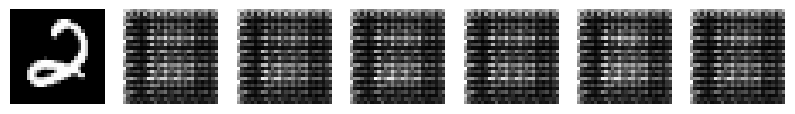

Epoch 4151 g_loss= 0.70820993 d_loss= 0.679503 real_acc= 1.0 fake_acc= 0.7
Epoch 4152 g_loss= 0.7102299 d_loss= 0.7115485 real_acc= 0.98 fake_acc= 0.74
Epoch 4153 g_loss= 0.6981473 d_loss= 0.6893731 real_acc= 1.0 fake_acc= 0.54
Epoch 4154 g_loss= 0.716838 d_loss= 0.67638135 real_acc= 1.0 fake_acc= 0.72
Epoch 4155 g_loss= 0.7027113 d_loss= 0.6848912 real_acc= 1.0 fake_acc= 0.62
Epoch 4156 g_loss= 0.7164531 d_loss= 0.6743754 real_acc= 1.0 fake_acc= 0.76
Epoch 4157 g_loss= 0.70523596 d_loss= 0.682083 real_acc= 1.0 fake_acc= 0.66
Epoch 4158 g_loss= 0.7120304 d_loss= 0.675654 real_acc= 1.0 fake_acc= 0.66
Epoch 4159 g_loss= 0.7091671 d_loss= 0.7500211 real_acc= 0.98 fake_acc= 0.66
Epoch 4160 g_loss= 0.7172731 d_loss= 0.6770391 real_acc= 1.0 fake_acc= 0.74


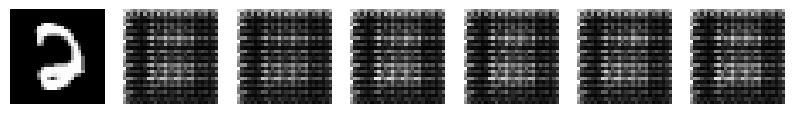

Epoch 4161 g_loss= 0.71062434 d_loss= 0.6772275 real_acc= 1.0 fake_acc= 0.7
Epoch 4162 g_loss= 0.71974915 d_loss= 0.67843837 real_acc= 1.0 fake_acc= 0.78
Epoch 4163 g_loss= 0.71436167 d_loss= 0.67344004 real_acc= 1.0 fake_acc= 0.72
Epoch 4164 g_loss= 0.720181 d_loss= 0.6678719 real_acc= 1.0 fake_acc= 0.72
Epoch 4165 g_loss= 0.7163121 d_loss= 0.67131346 real_acc= 1.0 fake_acc= 0.8
Epoch 4166 g_loss= 0.723902 d_loss= 0.6642639 real_acc= 1.0 fake_acc= 0.86
Epoch 4167 g_loss= 0.71569633 d_loss= 0.6717952 real_acc= 1.0 fake_acc= 0.74
Epoch 4168 g_loss= 0.7209295 d_loss= 0.66699237 real_acc= 1.0 fake_acc= 0.82
Epoch 4169 g_loss= 0.7206903 d_loss= 0.6962963 real_acc= 0.98 fake_acc= 0.76
Epoch 4170 g_loss= 0.724259 d_loss= 0.6638025 real_acc= 1.0 fake_acc= 0.86


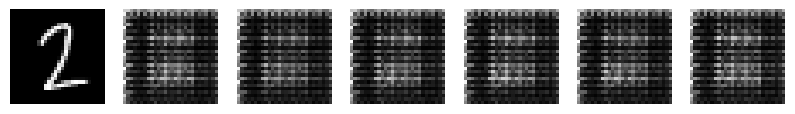

Epoch 4171 g_loss= 0.7238998 d_loss= 0.66806954 real_acc= 1.0 fake_acc= 0.82
Epoch 4172 g_loss= 0.7301053 d_loss= 0.6584912 real_acc= 1.0 fake_acc= 0.86
Epoch 4173 g_loss= 0.72589797 d_loss= 0.66250634 real_acc= 1.0 fake_acc= 0.82
Epoch 4174 g_loss= 0.7327971 d_loss= 0.65587634 real_acc= 1.0 fake_acc= 0.84
Epoch 4175 g_loss= 0.7357135 d_loss= 0.655277 real_acc= 1.0 fake_acc= 0.88
Epoch 4176 g_loss= 0.73218405 d_loss= 0.6564642 real_acc= 1.0 fake_acc= 0.92
Epoch 4177 g_loss= 0.741294 d_loss= 0.756991 real_acc= 0.98 fake_acc= 0.92
Epoch 4178 g_loss= 0.72935015 d_loss= 0.65922457 real_acc= 1.0 fake_acc= 0.86
Epoch 4179 g_loss= 0.7376109 d_loss= 0.6515463 real_acc= 1.0 fake_acc= 0.92
Epoch 4180 g_loss= 0.7345484 d_loss= 0.6548138 real_acc= 1.0 fake_acc= 0.84


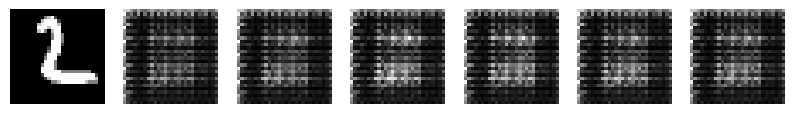

Epoch 4181 g_loss= 0.7397753 d_loss= 0.65538824 real_acc= 1.0 fake_acc= 0.94
Epoch 4182 g_loss= 0.74080706 d_loss= 0.6486808 real_acc= 1.0 fake_acc= 0.92
Epoch 4183 g_loss= 0.75006837 d_loss= 0.75388736 real_acc= 0.98 fake_acc= 0.88
Epoch 4184 g_loss= 0.7465172 d_loss= 0.6433075 real_acc= 1.0 fake_acc= 0.96
Epoch 4185 g_loss= 0.75944376 d_loss= 0.63207954 real_acc= 1.0 fake_acc= 0.98
Epoch 4186 g_loss= 0.7577639 d_loss= 0.63549536 real_acc= 1.0 fake_acc= 0.98
Epoch 4187 g_loss= 0.74956024 d_loss= 0.6408922 real_acc= 1.0 fake_acc= 0.9
Epoch 4188 g_loss= 0.7607452 d_loss= 0.6313202 real_acc= 1.0 fake_acc= 1.0
Epoch 4189 g_loss= 0.76527214 d_loss= 0.6266154 real_acc= 1.0 fake_acc= 1.0
Epoch 4190 g_loss= 0.76160103 d_loss= 0.64001817 real_acc= 1.0 fake_acc= 0.94


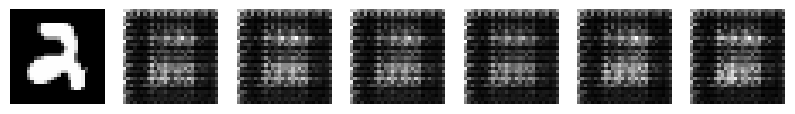

Epoch 4191 g_loss= 0.77101386 d_loss= 0.62216 real_acc= 1.0 fake_acc= 0.98
Epoch 4192 g_loss= 0.7768584 d_loss= 0.6165879 real_acc= 1.0 fake_acc= 1.0
Epoch 4193 g_loss= 0.7709097 d_loss= 0.6258369 real_acc= 1.0 fake_acc= 1.0
Epoch 4194 g_loss= 0.76906896 d_loss= 0.6236568 real_acc= 1.0 fake_acc= 1.0
Epoch 4195 g_loss= 0.77607924 d_loss= 0.61865383 real_acc= 1.0 fake_acc= 1.0
Epoch 4196 g_loss= 0.782159 d_loss= 0.6124237 real_acc= 1.0 fake_acc= 1.0
Epoch 4197 g_loss= 0.7871687 d_loss= 0.6091276 real_acc= 1.0 fake_acc= 1.0
Epoch 4198 g_loss= 0.7772645 d_loss= 0.6165603 real_acc= 1.0 fake_acc= 0.96
Epoch 4199 g_loss= 0.7817757 d_loss= 0.6263993 real_acc= 1.0 fake_acc= 0.96
Epoch 4200 g_loss= 0.7894917 d_loss= 0.61480564 real_acc= 1.0 fake_acc= 1.0


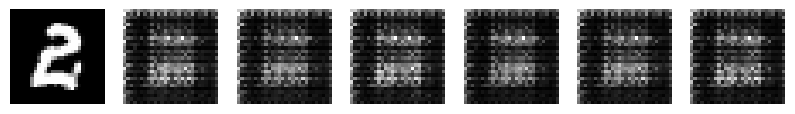

Epoch 4201 g_loss= 0.7929688 d_loss= 0.6034889 real_acc= 1.0 fake_acc= 1.0
Epoch 4202 g_loss= 0.7903923 d_loss= 0.6056351 real_acc= 1.0 fake_acc= 1.0
Epoch 4203 g_loss= 0.80410635 d_loss= 0.59426546 real_acc= 1.0 fake_acc= 1.0
Epoch 4204 g_loss= 0.80199975 d_loss= 0.59576046 real_acc= 1.0 fake_acc= 1.0
Epoch 4205 g_loss= 0.8024284 d_loss= 0.5954752 real_acc= 1.0 fake_acc= 1.0
Epoch 4206 g_loss= 0.80200076 d_loss= 0.6276326 real_acc= 0.98 fake_acc= 1.0
Epoch 4207 g_loss= 0.8116762 d_loss= 0.588438 real_acc= 1.0 fake_acc= 1.0
Epoch 4208 g_loss= 0.8166307 d_loss= 0.584298 real_acc= 1.0 fake_acc= 1.0
Epoch 4209 g_loss= 0.8161184 d_loss= 0.63790715 real_acc= 0.98 fake_acc= 1.0
Epoch 4210 g_loss= 0.812003 d_loss= 0.8556652 real_acc= 0.98 fake_acc= 1.0


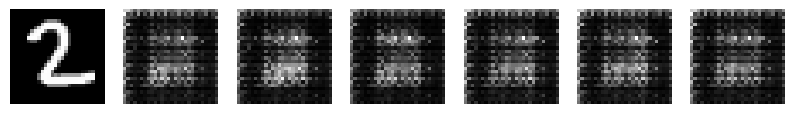

Epoch 4211 g_loss= 0.80656 d_loss= 0.8675123 real_acc= 0.96 fake_acc= 1.0
Epoch 4212 g_loss= 0.8040612 d_loss= 0.5941135 real_acc= 1.0 fake_acc= 1.0
Epoch 4213 g_loss= 0.808003 d_loss= 0.6171814 real_acc= 0.98 fake_acc= 1.0
Epoch 4214 g_loss= 0.80835396 d_loss= 0.60147285 real_acc= 1.0 fake_acc= 1.0
Epoch 4215 g_loss= 0.80505854 d_loss= 0.5933964 real_acc= 1.0 fake_acc= 1.0
Epoch 4216 g_loss= 0.802737 d_loss= 0.59528863 real_acc= 1.0 fake_acc= 1.0
Epoch 4217 g_loss= 0.81087226 d_loss= 0.6879821 real_acc= 0.98 fake_acc= 1.0
Epoch 4218 g_loss= 0.79920423 d_loss= 0.5994021 real_acc= 1.0 fake_acc= 1.0
Epoch 4219 g_loss= 0.7964292 d_loss= 0.6007229 real_acc= 1.0 fake_acc= 1.0
Epoch 4220 g_loss= 0.7941391 d_loss= 0.60230684 real_acc= 1.0 fake_acc= 1.0


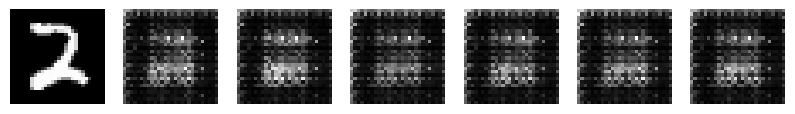

Epoch 4221 g_loss= 0.7953067 d_loss= 0.6013076 real_acc= 1.0 fake_acc= 1.0
Epoch 4222 g_loss= 0.80185777 d_loss= 0.5959572 real_acc= 1.0 fake_acc= 1.0
Epoch 4223 g_loss= 0.79239196 d_loss= 0.60411423 real_acc= 1.0 fake_acc= 0.98
Epoch 4224 g_loss= 0.79863566 d_loss= 0.59889454 real_acc= 1.0 fake_acc= 1.0
Epoch 4225 g_loss= 0.79972136 d_loss= 0.6203499 real_acc= 0.98 fake_acc= 0.98
Epoch 4226 g_loss= 0.79797435 d_loss= 0.6004295 real_acc= 1.0 fake_acc= 1.0
Epoch 4227 g_loss= 0.79823434 d_loss= 0.5990515 real_acc= 1.0 fake_acc= 1.0
Epoch 4228 g_loss= 0.8040809 d_loss= 0.59424245 real_acc= 1.0 fake_acc= 1.0
Epoch 4229 g_loss= 0.8074069 d_loss= 0.59147334 real_acc= 1.0 fake_acc= 1.0
Epoch 4230 g_loss= 0.8058036 d_loss= 0.59286344 real_acc= 1.0 fake_acc= 1.0


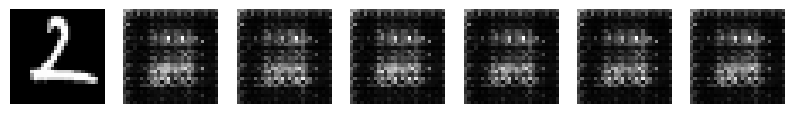

Epoch 4231 g_loss= 0.8005629 d_loss= 0.5973961 real_acc= 1.0 fake_acc= 1.0
Epoch 4232 g_loss= 0.81348914 d_loss= 0.5866448 real_acc= 1.0 fake_acc= 1.0
Epoch 4233 g_loss= 0.8208054 d_loss= 0.58091694 real_acc= 1.0 fake_acc= 1.0
Epoch 4234 g_loss= 0.81370944 d_loss= 0.58637595 real_acc= 1.0 fake_acc= 1.0
Epoch 4235 g_loss= 0.8183558 d_loss= 0.5834767 real_acc= 1.0 fake_acc= 1.0
Epoch 4236 g_loss= 0.8395858 d_loss= 0.56617075 real_acc= 1.0 fake_acc= 1.0
Epoch 4237 g_loss= 0.85440016 d_loss= 0.55562675 real_acc= 1.0 fake_acc= 1.0
Epoch 4238 g_loss= 0.8398543 d_loss= 0.5666071 real_acc= 1.0 fake_acc= 1.0
Epoch 4239 g_loss= 0.8465779 d_loss= 0.56129396 real_acc= 1.0 fake_acc= 1.0
Epoch 4240 g_loss= 0.8457782 d_loss= 0.56153446 real_acc= 1.0 fake_acc= 1.0


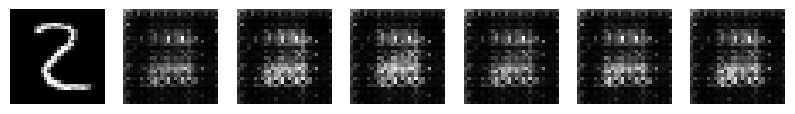

Epoch 4241 g_loss= 0.85358053 d_loss= 0.55575407 real_acc= 1.0 fake_acc= 1.0
Epoch 4242 g_loss= 0.8729774 d_loss= 0.54161096 real_acc= 1.0 fake_acc= 1.0
Epoch 4243 g_loss= 0.87251616 d_loss= 0.54242164 real_acc= 1.0 fake_acc= 1.0
Epoch 4244 g_loss= 0.87407786 d_loss= 0.540851 real_acc= 1.0 fake_acc= 1.0
Epoch 4245 g_loss= 0.8774921 d_loss= 0.538336 real_acc= 1.0 fake_acc= 1.0
Epoch 4246 g_loss= 0.8798266 d_loss= 0.5368064 real_acc= 1.0 fake_acc= 1.0
Epoch 4247 g_loss= 0.8977931 d_loss= 0.52411646 real_acc= 1.0 fake_acc= 1.0
Epoch 4248 g_loss= 0.90272063 d_loss= 0.52095914 real_acc= 1.0 fake_acc= 1.0
Epoch 4249 g_loss= 0.9103415 d_loss= 0.5709288 real_acc= 0.96 fake_acc= 1.0
Epoch 4250 g_loss= 0.9073294 d_loss= 0.5179701 real_acc= 1.0 fake_acc= 1.0


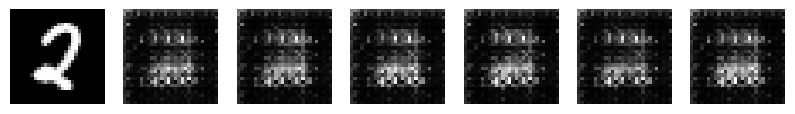

Epoch 4251 g_loss= 0.9048576 d_loss= 0.5194051 real_acc= 1.0 fake_acc= 1.0
Epoch 4252 g_loss= 0.92190886 d_loss= 0.5082503 real_acc= 1.0 fake_acc= 1.0
Epoch 4253 g_loss= 0.9178292 d_loss= 0.6032594 real_acc= 0.98 fake_acc= 1.0
Epoch 4254 g_loss= 0.93174857 d_loss= 0.6347583 real_acc= 0.98 fake_acc= 1.0
Epoch 4255 g_loss= 0.9287655 d_loss= 0.5037094 real_acc= 1.0 fake_acc= 1.0
Epoch 4256 g_loss= 0.92236716 d_loss= 0.5078399 real_acc= 1.0 fake_acc= 1.0
Epoch 4257 g_loss= 0.9180489 d_loss= 0.51065964 real_acc= 1.0 fake_acc= 1.0
Epoch 4258 g_loss= 0.91862005 d_loss= 0.51131696 real_acc= 1.0 fake_acc= 1.0
Epoch 4259 g_loss= 0.9316235 d_loss= 0.56063664 real_acc= 0.98 fake_acc= 1.0
Epoch 4260 g_loss= 0.92371017 d_loss= 0.50675726 real_acc= 1.0 fake_acc= 1.0


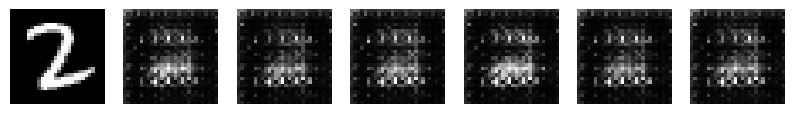

Epoch 4261 g_loss= 0.9245507 d_loss= 0.50616467 real_acc= 1.0 fake_acc= 1.0
Epoch 4262 g_loss= 0.9188238 d_loss= 0.5099746 real_acc= 1.0 fake_acc= 1.0
Epoch 4263 g_loss= 0.9135265 d_loss= 0.51389277 real_acc= 1.0 fake_acc= 1.0
Epoch 4264 g_loss= 0.9298038 d_loss= 0.503015 real_acc= 1.0 fake_acc= 1.0
Epoch 4265 g_loss= 0.92439324 d_loss= 0.50641924 real_acc= 1.0 fake_acc= 1.0
Epoch 4266 g_loss= 0.9219545 d_loss= 0.50784594 real_acc= 1.0 fake_acc= 1.0
Epoch 4267 g_loss= 0.9255693 d_loss= 0.5054332 real_acc= 1.0 fake_acc= 1.0
Epoch 4268 g_loss= 0.91958886 d_loss= 0.5095027 real_acc= 1.0 fake_acc= 1.0
Epoch 4269 g_loss= 0.93604684 d_loss= 0.49856547 real_acc= 1.0 fake_acc= 1.0
Epoch 4270 g_loss= 0.94133407 d_loss= 0.4952256 real_acc= 1.0 fake_acc= 1.0


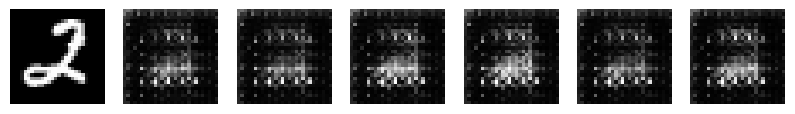

Epoch 4271 g_loss= 0.9437445 d_loss= 0.4939067 real_acc= 1.0 fake_acc= 1.0
Epoch 4272 g_loss= 0.9568511 d_loss= 0.48557866 real_acc= 1.0 fake_acc= 1.0
Epoch 4273 g_loss= 0.9460515 d_loss= 0.4929492 real_acc= 1.0 fake_acc= 1.0
Epoch 4274 g_loss= 0.96364236 d_loss= 0.48149487 real_acc= 1.0 fake_acc= 1.0
Epoch 4275 g_loss= 0.9532557 d_loss= 0.48804185 real_acc= 1.0 fake_acc= 1.0
Epoch 4276 g_loss= 0.9743552 d_loss= 0.48149332 real_acc= 1.0 fake_acc= 1.0
Epoch 4277 g_loss= 0.988423 d_loss= 0.4725136 real_acc= 1.0 fake_acc= 1.0
Epoch 4278 g_loss= 0.98852426 d_loss= 0.46618688 real_acc= 1.0 fake_acc= 1.0
Epoch 4279 g_loss= 0.9945833 d_loss= 0.4626137 real_acc= 1.0 fake_acc= 1.0
Epoch 4280 g_loss= 0.98002326 d_loss= 0.47123298 real_acc= 1.0 fake_acc= 1.0


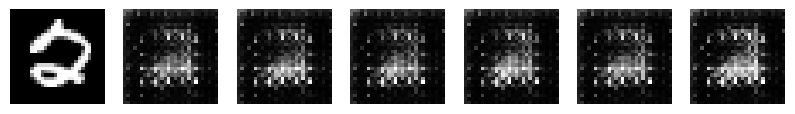

Epoch 4281 g_loss= 0.99231803 d_loss= 0.4645358 real_acc= 1.0 fake_acc= 1.0
Epoch 4282 g_loss= 0.9987224 d_loss= 0.69730395 real_acc= 0.98 fake_acc= 1.0
Epoch 4283 g_loss= 1.0119079 d_loss= 0.45343435 real_acc= 1.0 fake_acc= 1.0
Epoch 4284 g_loss= 1.0121964 d_loss= 0.45262522 real_acc= 1.0 fake_acc= 1.0
Epoch 4285 g_loss= 1.0231047 d_loss= 0.44644535 real_acc= 1.0 fake_acc= 1.0
Epoch 4286 g_loss= 1.0136857 d_loss= 0.45181426 real_acc= 1.0 fake_acc= 1.0
Epoch 4287 g_loss= 1.022247 d_loss= 0.44689497 real_acc= 1.0 fake_acc= 1.0
Epoch 4288 g_loss= 1.0267318 d_loss= 0.44483322 real_acc= 1.0 fake_acc= 1.0
Epoch 4289 g_loss= 1.0392848 d_loss= 0.43752313 real_acc= 1.0 fake_acc= 1.0
Epoch 4290 g_loss= 1.039312 d_loss= 0.43736675 real_acc= 1.0 fake_acc= 1.0


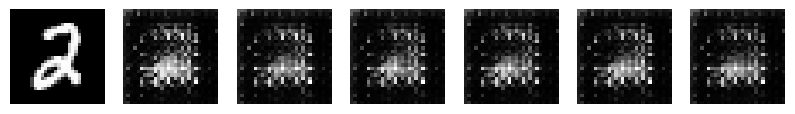

Epoch 4291 g_loss= 1.0519545 d_loss= 0.4308078 real_acc= 1.0 fake_acc= 1.0
Epoch 4292 g_loss= 1.0627426 d_loss= 0.46506196 real_acc= 0.98 fake_acc= 1.0
Epoch 4293 g_loss= 1.066444 d_loss= 0.44362733 real_acc= 0.98 fake_acc= 1.0
Epoch 4294 g_loss= 1.0679169 d_loss= 0.42183828 real_acc= 1.0 fake_acc= 1.0
Epoch 4295 g_loss= 1.078019 d_loss= 0.41672662 real_acc= 1.0 fake_acc= 1.0
Epoch 4296 g_loss= 1.0801647 d_loss= 0.41551366 real_acc= 1.0 fake_acc= 1.0
Epoch 4297 g_loss= 1.0779545 d_loss= 0.42082193 real_acc= 1.0 fake_acc= 1.0
Epoch 4298 g_loss= 1.0972285 d_loss= 0.4072692 real_acc= 1.0 fake_acc= 1.0
Epoch 4299 g_loss= 1.0818601 d_loss= 0.43546513 real_acc= 0.98 fake_acc= 1.0
Epoch 4300 g_loss= 1.0878577 d_loss= 0.4434434 real_acc= 0.98 fake_acc= 1.0


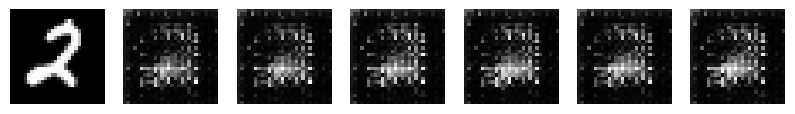

Epoch 4301 g_loss= 1.0821283 d_loss= 0.47989863 real_acc= 0.98 fake_acc= 1.0
Epoch 4302 g_loss= 1.1022977 d_loss= 0.40462014 real_acc= 1.0 fake_acc= 1.0
Epoch 4303 g_loss= 1.0991845 d_loss= 0.40571392 real_acc= 1.0 fake_acc= 1.0
Epoch 4304 g_loss= 1.0976211 d_loss= 0.40671438 real_acc= 1.0 fake_acc= 1.0
Epoch 4305 g_loss= 1.1094478 d_loss= 0.4011909 real_acc= 1.0 fake_acc= 1.0
Epoch 4306 g_loss= 1.0991378 d_loss= 0.40635642 real_acc= 1.0 fake_acc= 1.0
Epoch 4307 g_loss= 1.1176995 d_loss= 0.39678192 real_acc= 1.0 fake_acc= 1.0
Epoch 4308 g_loss= 1.1111975 d_loss= 0.40022686 real_acc= 1.0 fake_acc= 1.0
Epoch 4309 g_loss= 1.1149975 d_loss= 0.39877206 real_acc= 1.0 fake_acc= 1.0
Epoch 4310 g_loss= 1.1306896 d_loss= 0.39070693 real_acc= 1.0 fake_acc= 1.0


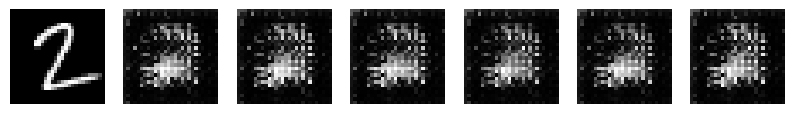

Epoch 4311 g_loss= 1.1380428 d_loss= 0.38733476 real_acc= 1.0 fake_acc= 1.0
Epoch 4312 g_loss= 1.1440452 d_loss= 0.38480693 real_acc= 1.0 fake_acc= 1.0
Epoch 4313 g_loss= 1.1713381 d_loss= 0.3721606 real_acc= 1.0 fake_acc= 1.0
Epoch 4314 g_loss= 1.1650779 d_loss= 0.37442902 real_acc= 1.0 fake_acc= 1.0
Epoch 4315 g_loss= 1.1768895 d_loss= 0.36938053 real_acc= 1.0 fake_acc= 1.0
Epoch 4316 g_loss= 1.1847107 d_loss= 0.36584625 real_acc= 1.0 fake_acc= 1.0
Epoch 4317 g_loss= 1.1851614 d_loss= 0.36544675 real_acc= 1.0 fake_acc= 1.0
Epoch 4318 g_loss= 1.2157447 d_loss= 0.3526834 real_acc= 1.0 fake_acc= 1.0
Epoch 4319 g_loss= 1.208593 d_loss= 0.35574567 real_acc= 1.0 fake_acc= 1.0
Epoch 4320 g_loss= 1.2325664 d_loss= 0.34524286 real_acc= 1.0 fake_acc= 1.0


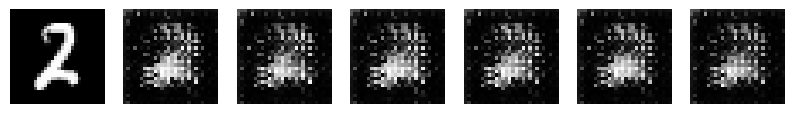

Epoch 4321 g_loss= 1.2347318 d_loss= 0.34465766 real_acc= 1.0 fake_acc= 1.0
Epoch 4322 g_loss= 1.2420132 d_loss= 0.34200376 real_acc= 1.0 fake_acc= 1.0
Epoch 4323 g_loss= 1.2512685 d_loss= 0.33793318 real_acc= 1.0 fake_acc= 1.0
Epoch 4324 g_loss= 1.2681296 d_loss= 0.33119127 real_acc= 1.0 fake_acc= 1.0
Epoch 4325 g_loss= 1.2750245 d_loss= 0.3287681 real_acc= 1.0 fake_acc= 1.0
Epoch 4326 g_loss= 1.2813408 d_loss= 0.326188 real_acc= 1.0 fake_acc= 1.0
Epoch 4327 g_loss= 1.2979835 d_loss= 0.32486555 real_acc= 1.0 fake_acc= 1.0
Epoch 4328 g_loss= 1.2982863 d_loss= 0.32050306 real_acc= 1.0 fake_acc= 1.0
Epoch 4329 g_loss= 1.316238 d_loss= 0.31314585 real_acc= 1.0 fake_acc= 1.0
Epoch 4330 g_loss= 1.3291342 d_loss= 0.30835143 real_acc= 1.0 fake_acc= 1.0


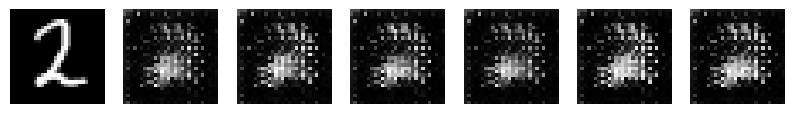

Epoch 4331 g_loss= 1.3406894 d_loss= 0.30702004 real_acc= 1.0 fake_acc= 1.0
Epoch 4332 g_loss= 1.3441086 d_loss= 0.30291867 real_acc= 1.0 fake_acc= 1.0
Epoch 4333 g_loss= 1.3675429 d_loss= 0.2949104 real_acc= 1.0 fake_acc= 1.0
Epoch 4334 g_loss= 1.3613319 d_loss= 0.29763725 real_acc= 1.0 fake_acc= 1.0
Epoch 4335 g_loss= 1.382987 d_loss= 0.29220054 real_acc= 1.0 fake_acc= 1.0
Epoch 4336 g_loss= 1.3967422 d_loss= 0.29504672 real_acc= 1.0 fake_acc= 1.0
Epoch 4337 g_loss= 1.3863434 d_loss= 0.28806794 real_acc= 1.0 fake_acc= 1.0
Epoch 4338 g_loss= 1.4261824 d_loss= 0.47997987 real_acc= 0.96 fake_acc= 1.0
Epoch 4339 g_loss= 1.4101241 d_loss= 0.28122482 real_acc= 1.0 fake_acc= 1.0
Epoch 4340 g_loss= 1.4289087 d_loss= 0.28048325 real_acc= 1.0 fake_acc= 1.0


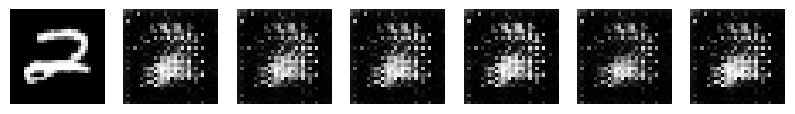

Epoch 4341 g_loss= 1.4107568 d_loss= 0.2828167 real_acc= 1.0 fake_acc= 1.0
Epoch 4342 g_loss= 1.4138589 d_loss= 0.27947646 real_acc= 1.0 fake_acc= 1.0
Epoch 4343 g_loss= 1.408359 d_loss= 0.28123233 real_acc= 1.0 fake_acc= 1.0
Epoch 4344 g_loss= 1.4223589 d_loss= 0.27694568 real_acc= 1.0 fake_acc= 1.0
Epoch 4345 g_loss= 1.4175357 d_loss= 0.2782053 real_acc= 1.0 fake_acc= 1.0
Epoch 4346 g_loss= 1.4178864 d_loss= 0.2781374 real_acc= 1.0 fake_acc= 1.0
Epoch 4347 g_loss= 1.4207714 d_loss= 0.32376057 real_acc= 0.98 fake_acc= 1.0
Epoch 4348 g_loss= 1.4198779 d_loss= 0.27771705 real_acc= 1.0 fake_acc= 1.0
Epoch 4349 g_loss= 1.4306424 d_loss= 0.27406856 real_acc= 1.0 fake_acc= 1.0
Epoch 4350 g_loss= 1.4418887 d_loss= 0.27043 real_acc= 1.0 fake_acc= 1.0


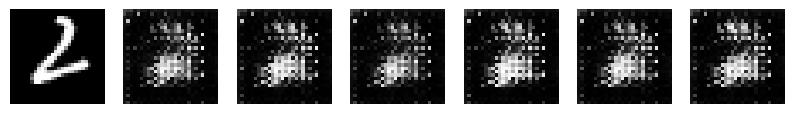

Epoch 4351 g_loss= 1.4475032 d_loss= 0.26891622 real_acc= 1.0 fake_acc= 1.0
Epoch 4352 g_loss= 1.4384432 d_loss= 0.27177134 real_acc= 1.0 fake_acc= 1.0
Epoch 4353 g_loss= 1.4482175 d_loss= 0.26889738 real_acc= 1.0 fake_acc= 1.0
Epoch 4354 g_loss= 1.4538918 d_loss= 0.26721153 real_acc= 1.0 fake_acc= 1.0
Epoch 4355 g_loss= 1.4634207 d_loss= 0.26395768 real_acc= 1.0 fake_acc= 1.0
Epoch 4356 g_loss= 1.460495 d_loss= 0.26486126 real_acc= 1.0 fake_acc= 1.0
Epoch 4357 g_loss= 1.4782174 d_loss= 0.34968236 real_acc= 0.98 fake_acc= 1.0
Epoch 4358 g_loss= 1.4887015 d_loss= 0.25694326 real_acc= 1.0 fake_acc= 1.0
Epoch 4359 g_loss= 1.4942844 d_loss= 0.2549231 real_acc= 1.0 fake_acc= 1.0
Epoch 4360 g_loss= 1.5064148 d_loss= 0.25176132 real_acc= 1.0 fake_acc= 1.0


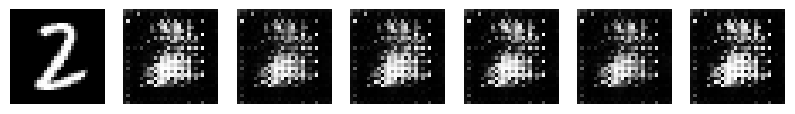

Epoch 4361 g_loss= 1.5181123 d_loss= 0.24831526 real_acc= 1.0 fake_acc= 1.0
Epoch 4362 g_loss= 1.5214113 d_loss= 0.24723446 real_acc= 1.0 fake_acc= 1.0
Epoch 4363 g_loss= 1.5162467 d_loss= 0.29856712 real_acc= 0.98 fake_acc= 1.0
Epoch 4364 g_loss= 1.5227374 d_loss= 0.24678452 real_acc= 1.0 fake_acc= 1.0
Epoch 4365 g_loss= 1.523407 d_loss= 0.24675225 real_acc= 1.0 fake_acc= 1.0
Epoch 4366 g_loss= 1.5589037 d_loss= 0.23718576 real_acc= 1.0 fake_acc= 1.0
Epoch 4367 g_loss= 1.5352887 d_loss= 0.24327728 real_acc= 1.0 fake_acc= 1.0
Epoch 4368 g_loss= 1.5519476 d_loss= 0.23888376 real_acc= 1.0 fake_acc= 1.0
Epoch 4369 g_loss= 1.5633246 d_loss= 0.23605706 real_acc= 1.0 fake_acc= 1.0
Epoch 4370 g_loss= 1.5858383 d_loss= 0.23002742 real_acc= 1.0 fake_acc= 1.0


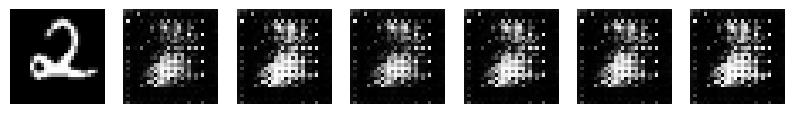

Epoch 4371 g_loss= 1.601253 d_loss= 0.22613746 real_acc= 1.0 fake_acc= 1.0
Epoch 4372 g_loss= 1.5931717 d_loss= 0.28871155 real_acc= 0.98 fake_acc= 1.0
Epoch 4373 g_loss= 1.6140884 d_loss= 0.22273494 real_acc= 1.0 fake_acc= 1.0
Epoch 4374 g_loss= 1.6013381 d_loss= 0.22589384 real_acc= 1.0 fake_acc= 1.0
Epoch 4375 g_loss= 1.6095552 d_loss= 0.22403225 real_acc= 1.0 fake_acc= 1.0
Epoch 4376 g_loss= 1.6164402 d_loss= 0.22232302 real_acc= 1.0 fake_acc= 1.0
Epoch 4377 g_loss= 1.6523576 d_loss= 0.21362804 real_acc= 1.0 fake_acc= 1.0
Epoch 4378 g_loss= 1.6481935 d_loss= 0.21462327 real_acc= 1.0 fake_acc= 1.0
Epoch 4379 g_loss= 1.6467087 d_loss= 0.2148883 real_acc= 1.0 fake_acc= 1.0
Epoch 4380 g_loss= 1.6585646 d_loss= 0.21226762 real_acc= 1.0 fake_acc= 1.0


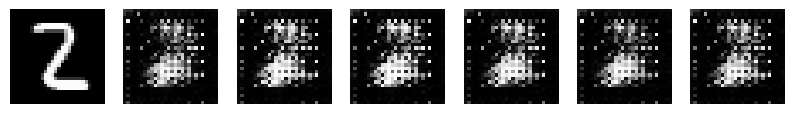

Epoch 4381 g_loss= 1.687301 d_loss= 0.20528877 real_acc= 1.0 fake_acc= 1.0
Epoch 4382 g_loss= 1.6768576 d_loss= 0.20784989 real_acc= 1.0 fake_acc= 1.0
Epoch 4383 g_loss= 1.6833118 d_loss= 0.20631588 real_acc= 1.0 fake_acc= 1.0
Epoch 4384 g_loss= 1.7054725 d_loss= 0.20106998 real_acc= 1.0 fake_acc= 1.0
Epoch 4385 g_loss= 1.7224202 d_loss= 0.19737494 real_acc= 1.0 fake_acc= 1.0
Epoch 4386 g_loss= 1.7549727 d_loss= 0.1905183 real_acc= 1.0 fake_acc= 1.0
Epoch 4387 g_loss= 1.743394 d_loss= 0.19295554 real_acc= 1.0 fake_acc= 1.0
Epoch 4388 g_loss= 1.7762831 d_loss= 0.18606475 real_acc= 1.0 fake_acc= 1.0
Epoch 4389 g_loss= 1.7650669 d_loss= 0.19095774 real_acc= 1.0 fake_acc= 1.0
Epoch 4390 g_loss= 1.8022943 d_loss= 0.18095599 real_acc= 1.0 fake_acc= 1.0


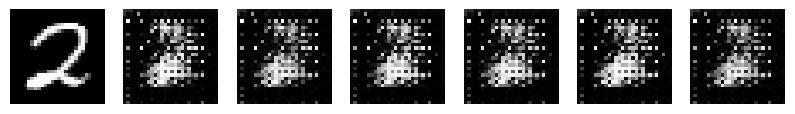

Epoch 4391 g_loss= 1.7833899 d_loss= 0.18485267 real_acc= 1.0 fake_acc= 1.0
Epoch 4392 g_loss= 1.8238503 d_loss= 0.1766177 real_acc= 1.0 fake_acc= 1.0
Epoch 4393 g_loss= 1.8144107 d_loss= 0.17862478 real_acc= 1.0 fake_acc= 1.0
Epoch 4394 g_loss= 1.8350072 d_loss= 0.17481613 real_acc= 1.0 fake_acc= 1.0
Epoch 4395 g_loss= 1.8405795 d_loss= 0.17345318 real_acc= 1.0 fake_acc= 1.0
Epoch 4396 g_loss= 1.8658006 d_loss= 0.1689382 real_acc= 1.0 fake_acc= 1.0
Epoch 4397 g_loss= 1.8911765 d_loss= 0.16433802 real_acc= 1.0 fake_acc= 1.0
Epoch 4398 g_loss= 1.8879949 d_loss= 0.16491638 real_acc= 1.0 fake_acc= 1.0
Epoch 4399 g_loss= 1.9077482 d_loss= 0.16112785 real_acc= 1.0 fake_acc= 1.0
Epoch 4400 g_loss= 1.9326488 d_loss= 0.15703027 real_acc= 1.0 fake_acc= 1.0


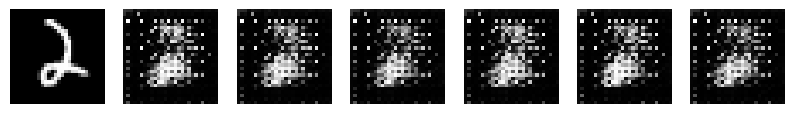

Epoch 4401 g_loss= 1.9367541 d_loss= 0.15638435 real_acc= 1.0 fake_acc= 1.0
Epoch 4402 g_loss= 1.9552143 d_loss= 0.15334012 real_acc= 1.0 fake_acc= 1.0
Epoch 4403 g_loss= 1.9664949 d_loss= 0.15127061 real_acc= 1.0 fake_acc= 1.0
Epoch 4404 g_loss= 1.9880048 d_loss= 0.14801373 real_acc= 1.0 fake_acc= 1.0
Epoch 4405 g_loss= 2.0029058 d_loss= 0.1455785 real_acc= 1.0 fake_acc= 1.0
Epoch 4406 g_loss= 2.0221362 d_loss= 0.14251368 real_acc= 1.0 fake_acc= 1.0
Epoch 4407 g_loss= 2.0143337 d_loss= 0.14411257 real_acc= 1.0 fake_acc= 1.0
Epoch 4408 g_loss= 2.0467315 d_loss= 0.1392128 real_acc= 1.0 fake_acc= 1.0
Epoch 4409 g_loss= 2.066483 d_loss= 0.1360752 real_acc= 1.0 fake_acc= 1.0
Epoch 4410 g_loss= 2.078723 d_loss= 0.1433506 real_acc= 1.0 fake_acc= 1.0


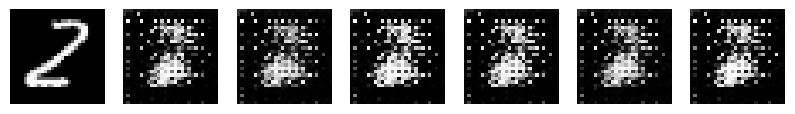

Epoch 4411 g_loss= 2.0891857 d_loss= 0.13259298 real_acc= 1.0 fake_acc= 1.0
Epoch 4412 g_loss= 2.1029031 d_loss= 0.13112293 real_acc= 1.0 fake_acc= 1.0
Epoch 4413 g_loss= 2.1201303 d_loss= 0.12843966 real_acc= 1.0 fake_acc= 1.0
Epoch 4414 g_loss= 2.1424627 d_loss= 0.12573391 real_acc= 1.0 fake_acc= 1.0
Epoch 4415 g_loss= 2.1586773 d_loss= 0.123398475 real_acc= 1.0 fake_acc= 1.0
Epoch 4416 g_loss= 2.1434422 d_loss= 0.12544678 real_acc= 1.0 fake_acc= 1.0
Epoch 4417 g_loss= 2.1922607 d_loss= 0.27034318 real_acc= 0.98 fake_acc= 1.0
Epoch 4418 g_loss= 2.17784 d_loss= 0.22454074 real_acc= 0.98 fake_acc= 1.0
Epoch 4419 g_loss= 2.154196 d_loss= 0.14645743 real_acc= 0.98 fake_acc= 1.0
Epoch 4420 g_loss= 2.1374178 d_loss= 0.12641026 real_acc= 1.0 fake_acc= 1.0


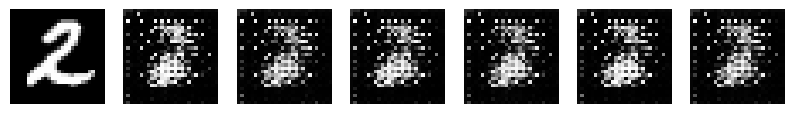

Epoch 4421 g_loss= 2.140852 d_loss= 0.12573479 real_acc= 1.0 fake_acc= 1.0
Epoch 4422 g_loss= 2.1273336 d_loss= 0.12747952 real_acc= 1.0 fake_acc= 1.0
Epoch 4423 g_loss= 2.1175632 d_loss= 0.12891361 real_acc= 1.0 fake_acc= 1.0
Epoch 4424 g_loss= 2.108576 d_loss= 0.12982972 real_acc= 1.0 fake_acc= 1.0
Epoch 4425 g_loss= 2.1486683 d_loss= 0.12500955 real_acc= 1.0 fake_acc= 1.0
Epoch 4426 g_loss= 2.1130855 d_loss= 0.12929524 real_acc= 1.0 fake_acc= 1.0
Epoch 4427 g_loss= 2.121652 d_loss= 0.12832217 real_acc= 1.0 fake_acc= 1.0
Epoch 4428 g_loss= 2.130738 d_loss= 0.12677641 real_acc= 1.0 fake_acc= 1.0
Epoch 4429 g_loss= 2.13723 d_loss= 0.12598746 real_acc= 1.0 fake_acc= 1.0
Epoch 4430 g_loss= 2.1506379 d_loss= 0.12443283 real_acc= 1.0 fake_acc= 1.0


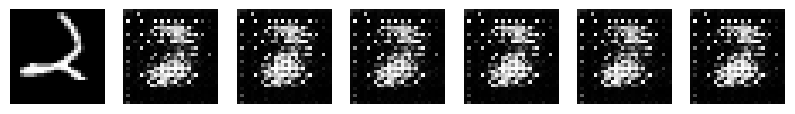

Epoch 4431 g_loss= 2.140967 d_loss= 0.1256728 real_acc= 1.0 fake_acc= 1.0
Epoch 4432 g_loss= 2.13836 d_loss= 0.12585716 real_acc= 1.0 fake_acc= 1.0
Epoch 4433 g_loss= 2.1416113 d_loss= 0.12578928 real_acc= 1.0 fake_acc= 1.0
Epoch 4434 g_loss= 2.1648378 d_loss= 0.12270273 real_acc= 1.0 fake_acc= 1.0
Epoch 4435 g_loss= 2.1542194 d_loss= 0.124019966 real_acc= 1.0 fake_acc= 1.0
Epoch 4436 g_loss= 2.1668746 d_loss= 0.12242147 real_acc= 1.0 fake_acc= 1.0
Epoch 4437 g_loss= 2.1808927 d_loss= 0.12054838 real_acc= 1.0 fake_acc= 1.0
Epoch 4438 g_loss= 2.200755 d_loss= 0.11791441 real_acc= 1.0 fake_acc= 1.0
Epoch 4439 g_loss= 2.2088563 d_loss= 0.11702816 real_acc= 1.0 fake_acc= 1.0
Epoch 4440 g_loss= 2.201545 d_loss= 0.1180084 real_acc= 1.0 fake_acc= 1.0


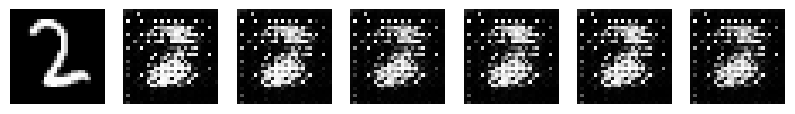

Epoch 4441 g_loss= 2.2287138 d_loss= 0.11462075 real_acc= 1.0 fake_acc= 1.0
Epoch 4442 g_loss= 2.236488 d_loss= 0.11356043 real_acc= 1.0 fake_acc= 1.0
Epoch 4443 g_loss= 2.2421608 d_loss= 0.1127523 real_acc= 1.0 fake_acc= 1.0
Epoch 4444 g_loss= 2.2680695 d_loss= 0.109935515 real_acc= 1.0 fake_acc= 1.0
Epoch 4445 g_loss= 2.2889342 d_loss= 0.107525304 real_acc= 1.0 fake_acc= 1.0
Epoch 4446 g_loss= 2.2877855 d_loss= 0.10774397 real_acc= 1.0 fake_acc= 1.0
Epoch 4447 g_loss= 2.2901418 d_loss= 0.107410975 real_acc= 1.0 fake_acc= 1.0
Epoch 4448 g_loss= 2.3054664 d_loss= 0.105538264 real_acc= 1.0 fake_acc= 1.0
Epoch 4449 g_loss= 2.3208709 d_loss= 0.10393112 real_acc= 1.0 fake_acc= 1.0
Epoch 4450 g_loss= 2.3299932 d_loss= 0.10308576 real_acc= 1.0 fake_acc= 1.0


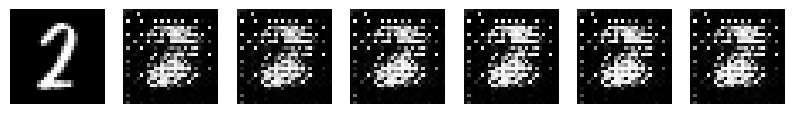

Epoch 4451 g_loss= 2.3435705 d_loss= 0.10160165 real_acc= 1.0 fake_acc= 1.0
Epoch 4452 g_loss= 2.3830063 d_loss= 0.0976546 real_acc= 1.0 fake_acc= 1.0
Epoch 4453 g_loss= 2.3931696 d_loss= 0.09633586 real_acc= 1.0 fake_acc= 1.0
Epoch 4454 g_loss= 2.404425 d_loss= 0.09503256 real_acc= 1.0 fake_acc= 1.0
Epoch 4455 g_loss= 2.3817358 d_loss= 0.09755684 real_acc= 1.0 fake_acc= 1.0
Epoch 4456 g_loss= 2.420156 d_loss= 0.093505375 real_acc= 1.0 fake_acc= 1.0
Epoch 4457 g_loss= 2.4378479 d_loss= 0.09173831 real_acc= 1.0 fake_acc= 1.0
Epoch 4458 g_loss= 2.4424121 d_loss= 0.09158437 real_acc= 1.0 fake_acc= 1.0
Epoch 4459 g_loss= 2.4584503 d_loss= 0.0901825 real_acc= 1.0 fake_acc= 1.0
Epoch 4460 g_loss= 2.4710953 d_loss= 0.08877185 real_acc= 1.0 fake_acc= 1.0


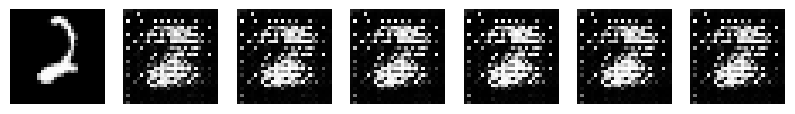

Epoch 4461 g_loss= 2.4774694 d_loss= 0.08821019 real_acc= 1.0 fake_acc= 1.0
Epoch 4462 g_loss= 2.5203338 d_loss= 0.08439011 real_acc= 1.0 fake_acc= 1.0
Epoch 4463 g_loss= 2.5280344 d_loss= 0.08371988 real_acc= 1.0 fake_acc= 1.0
Epoch 4464 g_loss= 2.5403762 d_loss= 0.08291228 real_acc= 1.0 fake_acc= 1.0
Epoch 4465 g_loss= 2.565794 d_loss= 0.08053471 real_acc= 1.0 fake_acc= 1.0
Epoch 4466 g_loss= 2.540103 d_loss= 0.082760714 real_acc= 1.0 fake_acc= 1.0
Epoch 4467 g_loss= 2.5867722 d_loss= 0.078713804 real_acc= 1.0 fake_acc= 1.0
Epoch 4468 g_loss= 2.5894365 d_loss= 0.078440934 real_acc= 1.0 fake_acc= 1.0
Epoch 4469 g_loss= 2.6081128 d_loss= 0.07702006 real_acc= 1.0 fake_acc= 1.0
Epoch 4470 g_loss= 2.6352048 d_loss= 0.074950494 real_acc= 1.0 fake_acc= 1.0


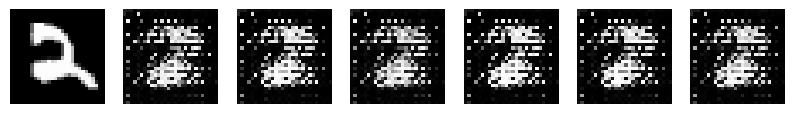

Epoch 4471 g_loss= 2.620616 d_loss= 0.07626202 real_acc= 1.0 fake_acc= 1.0
Epoch 4472 g_loss= 2.6511605 d_loss= 0.073607795 real_acc= 1.0 fake_acc= 1.0
Epoch 4473 g_loss= 2.6316638 d_loss= 0.07512067 real_acc= 1.0 fake_acc= 1.0
Epoch 4474 g_loss= 2.6599646 d_loss= 0.073128656 real_acc= 1.0 fake_acc= 1.0
Epoch 4475 g_loss= 2.6965427 d_loss= 0.070297964 real_acc= 1.0 fake_acc= 1.0
Epoch 4476 g_loss= 2.6773183 d_loss= 0.071770824 real_acc= 1.0 fake_acc= 1.0
Epoch 4477 g_loss= 2.712161 d_loss= 0.06932043 real_acc= 1.0 fake_acc= 1.0
Epoch 4478 g_loss= 2.737451 d_loss= 0.06732159 real_acc= 1.0 fake_acc= 1.0
Epoch 4479 g_loss= 2.7447195 d_loss= 0.066824436 real_acc= 1.0 fake_acc= 1.0
Epoch 4480 g_loss= 2.7701135 d_loss= 0.06507333 real_acc= 1.0 fake_acc= 1.0


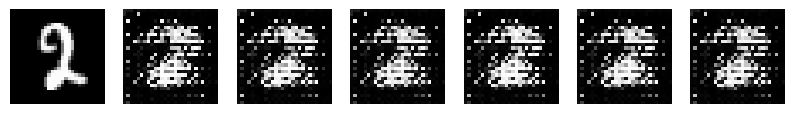

Epoch 4481 g_loss= 2.7996023 d_loss= 0.0633003 real_acc= 1.0 fake_acc= 1.0
Epoch 4482 g_loss= 2.7563324 d_loss= 0.06614302 real_acc= 1.0 fake_acc= 1.0
Epoch 4483 g_loss= 2.8008814 d_loss= 0.06317854 real_acc= 1.0 fake_acc= 1.0
Epoch 4484 g_loss= 2.8260639 d_loss= 0.06144927 real_acc= 1.0 fake_acc= 1.0
Epoch 4485 g_loss= 2.7899761 d_loss= 0.06474704 real_acc= 1.0 fake_acc= 1.0
Epoch 4486 g_loss= 2.8261726 d_loss= 0.06149701 real_acc= 1.0 fake_acc= 1.0
Epoch 4487 g_loss= 2.8726938 d_loss= 0.058667835 real_acc= 1.0 fake_acc= 1.0
Epoch 4488 g_loss= 2.8344696 d_loss= 0.061249036 real_acc= 1.0 fake_acc= 1.0
Epoch 4489 g_loss= 2.87391 d_loss= 0.058539174 real_acc= 1.0 fake_acc= 1.0
Epoch 4490 g_loss= 2.8953488 d_loss= 0.057349086 real_acc= 1.0 fake_acc= 1.0


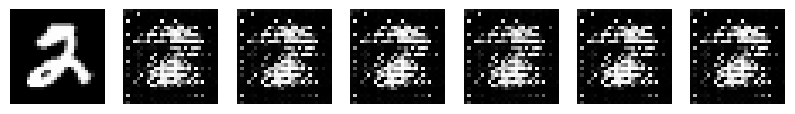

Epoch 4491 g_loss= 2.880416 d_loss= 0.058175173 real_acc= 1.0 fake_acc= 1.0
Epoch 4492 g_loss= 2.904929 d_loss= 0.056745145 real_acc= 1.0 fake_acc= 1.0
Epoch 4493 g_loss= 2.9147296 d_loss= 0.056180794 real_acc= 1.0 fake_acc= 1.0
Epoch 4494 g_loss= 2.9530382 d_loss= 0.05404308 real_acc= 1.0 fake_acc= 1.0
Epoch 4495 g_loss= 2.9288933 d_loss= 0.05536343 real_acc= 1.0 fake_acc= 1.0
Epoch 4496 g_loss= 2.9639382 d_loss= 0.053495087 real_acc= 1.0 fake_acc= 1.0
Epoch 4497 g_loss= 2.9635682 d_loss= 0.057325143 real_acc= 1.0 fake_acc= 1.0
Epoch 4498 g_loss= 2.9619324 d_loss= 0.053433616 real_acc= 1.0 fake_acc= 1.0
Epoch 4499 g_loss= 3.0209513 d_loss= 0.050468538 real_acc= 1.0 fake_acc= 1.0
Epoch 4500 g_loss= 3.0346484 d_loss= 0.04969093 real_acc= 1.0 fake_acc= 1.0


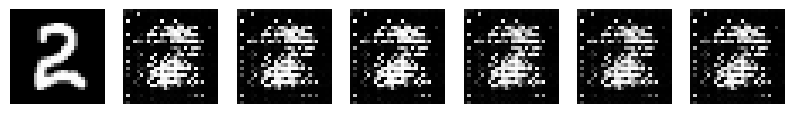

Epoch 4501 g_loss= 3.0653064 d_loss= 0.048062906 real_acc= 1.0 fake_acc= 1.0
Epoch 4502 g_loss= 3.0767655 d_loss= 0.047547467 real_acc= 1.0 fake_acc= 1.0
Epoch 4503 g_loss= 3.0498395 d_loss= 0.05068528 real_acc= 1.0 fake_acc= 1.0
Epoch 4504 g_loss= 3.039226 d_loss= 0.04956767 real_acc= 1.0 fake_acc= 1.0
Epoch 4505 g_loss= 3.0983648 d_loss= 0.19202904 real_acc= 0.98 fake_acc= 1.0
Epoch 4506 g_loss= 3.0424323 d_loss= 0.049305543 real_acc= 1.0 fake_acc= 1.0
Epoch 4507 g_loss= 3.068503 d_loss= 0.047919106 real_acc= 1.0 fake_acc= 1.0
Epoch 4508 g_loss= 3.0659626 d_loss= 0.048069004 real_acc= 1.0 fake_acc= 1.0
Epoch 4509 g_loss= 3.0456655 d_loss= 0.049095232 real_acc= 1.0 fake_acc= 1.0
Epoch 4510 g_loss= 3.0717423 d_loss= 0.047823504 real_acc= 1.0 fake_acc= 1.0


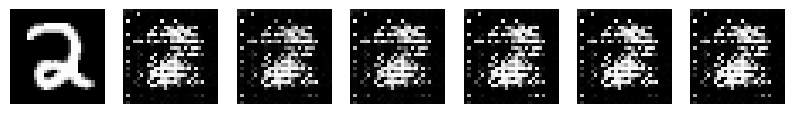

Epoch 4511 g_loss= 3.060292 d_loss= 0.048323408 real_acc= 1.0 fake_acc= 1.0
Epoch 4512 g_loss= 3.0280366 d_loss= 0.049971227 real_acc= 1.0 fake_acc= 1.0
Epoch 4513 g_loss= 3.0740883 d_loss= 0.04779392 real_acc= 1.0 fake_acc= 1.0
Epoch 4514 g_loss= 3.0651834 d_loss= 0.04805364 real_acc= 1.0 fake_acc= 1.0
Epoch 4515 g_loss= 3.0334988 d_loss= 0.049756 real_acc= 1.0 fake_acc= 1.0
Epoch 4516 g_loss= 3.0830877 d_loss= 0.04716669 real_acc= 1.0 fake_acc= 1.0
Epoch 4517 g_loss= 3.105565 d_loss= 0.046115123 real_acc= 1.0 fake_acc= 1.0
Epoch 4518 g_loss= 3.0851595 d_loss= 0.047209278 real_acc= 1.0 fake_acc= 1.0
Epoch 4519 g_loss= 3.0789247 d_loss= 0.047525562 real_acc= 1.0 fake_acc= 1.0
Epoch 4520 g_loss= 3.1150565 d_loss= 0.045748353 real_acc= 1.0 fake_acc= 1.0


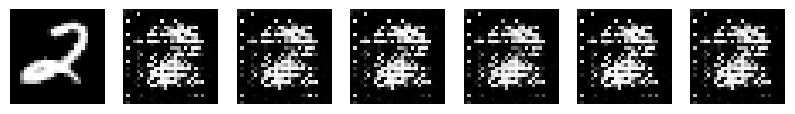

Epoch 4521 g_loss= 3.1516018 d_loss= 0.044095982 real_acc= 1.0 fake_acc= 1.0
Epoch 4522 g_loss= 3.1292222 d_loss= 0.045263395 real_acc= 1.0 fake_acc= 1.0
Epoch 4523 g_loss= 3.14892 d_loss= 0.044198617 real_acc= 1.0 fake_acc= 1.0
Epoch 4524 g_loss= 3.168678 d_loss= 0.043470725 real_acc= 1.0 fake_acc= 1.0
Epoch 4525 g_loss= 3.1393104 d_loss= 0.044629816 real_acc= 1.0 fake_acc= 1.0
Epoch 4526 g_loss= 3.1751487 d_loss= 0.04305689 real_acc= 1.0 fake_acc= 1.0
Epoch 4527 g_loss= 3.1742022 d_loss= 0.043058265 real_acc= 1.0 fake_acc= 1.0
Epoch 4528 g_loss= 3.1769013 d_loss= 0.04313756 real_acc= 1.0 fake_acc= 1.0
Epoch 4529 g_loss= 3.1778686 d_loss= 0.042902473 real_acc= 1.0 fake_acc= 1.0
Epoch 4530 g_loss= 3.1848538 d_loss= 0.042670168 real_acc= 1.0 fake_acc= 1.0


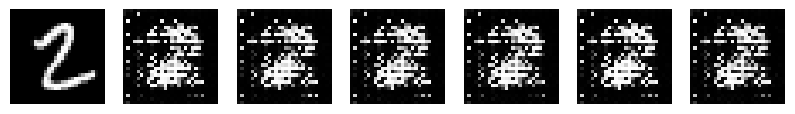

Epoch 4531 g_loss= 3.2035174 d_loss= 0.04186362 real_acc= 1.0 fake_acc= 1.0
Epoch 4532 g_loss= 3.2394047 d_loss= 0.04019799 real_acc= 1.0 fake_acc= 1.0
Epoch 4533 g_loss= 3.2035308 d_loss= 0.041794766 real_acc= 1.0 fake_acc= 1.0
Epoch 4534 g_loss= 3.2266827 d_loss= 0.040971585 real_acc= 1.0 fake_acc= 1.0
Epoch 4535 g_loss= 3.2681725 d_loss= 0.03913361 real_acc= 1.0 fake_acc= 1.0
Epoch 4536 g_loss= 3.2938647 d_loss= 0.038138732 real_acc= 1.0 fake_acc= 1.0
Epoch 4537 g_loss= 3.2566233 d_loss= 0.039673094 real_acc= 1.0 fake_acc= 1.0
Epoch 4538 g_loss= 3.2808442 d_loss= 0.03870483 real_acc= 1.0 fake_acc= 1.0
Epoch 4539 g_loss= 3.319035 d_loss= 0.037134696 real_acc= 1.0 fake_acc= 1.0
Epoch 4540 g_loss= 3.2943482 d_loss= 0.038136687 real_acc= 1.0 fake_acc= 1.0


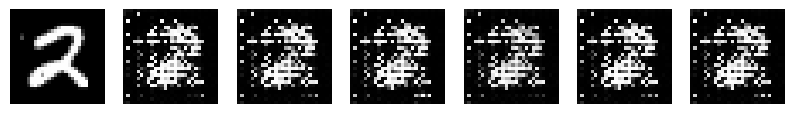

Epoch 4541 g_loss= 3.3138964 d_loss= 0.03740159 real_acc= 1.0 fake_acc= 1.0
Epoch 4542 g_loss= 3.3557491 d_loss= 0.03585059 real_acc= 1.0 fake_acc= 1.0
Epoch 4543 g_loss= 3.3452408 d_loss= 0.036282662 real_acc= 1.0 fake_acc= 1.0
Epoch 4544 g_loss= 3.3358407 d_loss= 0.13079259 real_acc= 0.98 fake_acc= 1.0
Epoch 4545 g_loss= 3.3162484 d_loss= 0.037382804 real_acc= 1.0 fake_acc= 1.0
Epoch 4546 g_loss= 3.3048227 d_loss= 0.037749015 real_acc= 1.0 fake_acc= 1.0
Epoch 4547 g_loss= 3.3372552 d_loss= 0.036465775 real_acc= 1.0 fake_acc= 1.0
Epoch 4548 g_loss= 3.3006022 d_loss= 0.037945714 real_acc= 1.0 fake_acc= 1.0
Epoch 4549 g_loss= 3.321637 d_loss= 0.037245225 real_acc= 1.0 fake_acc= 1.0
Epoch 4550 g_loss= 3.2829978 d_loss= 0.038559154 real_acc= 1.0 fake_acc= 1.0


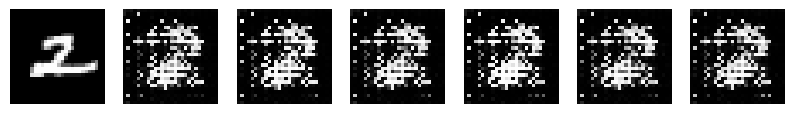

Epoch 4551 g_loss= 3.2976959 d_loss= 0.03803201 real_acc= 1.0 fake_acc= 1.0
Epoch 4552 g_loss= 3.276933 d_loss= 0.038665816 real_acc= 1.0 fake_acc= 1.0
Epoch 4553 g_loss= 3.303707 d_loss= 0.03774498 real_acc= 1.0 fake_acc= 1.0
Epoch 4554 g_loss= 3.2966821 d_loss= 0.037982054 real_acc= 1.0 fake_acc= 1.0
Epoch 4555 g_loss= 3.3073688 d_loss= 0.037556008 real_acc= 1.0 fake_acc= 1.0
Epoch 4556 g_loss= 3.3143547 d_loss= 0.037295796 real_acc= 1.0 fake_acc= 1.0
Epoch 4557 g_loss= 3.30668 d_loss= 0.037590966 real_acc= 1.0 fake_acc= 1.0
Epoch 4558 g_loss= 3.2889478 d_loss= 0.038328372 real_acc= 1.0 fake_acc= 1.0
Epoch 4559 g_loss= 3.2988107 d_loss= 0.038103137 real_acc= 1.0 fake_acc= 1.0
Epoch 4560 g_loss= 3.3327267 d_loss= 0.036693305 real_acc= 1.0 fake_acc= 1.0


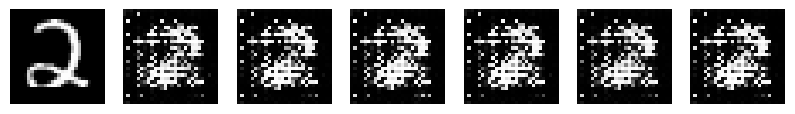

Epoch 4561 g_loss= 3.297737 d_loss= 0.038130663 real_acc= 1.0 fake_acc= 1.0
Epoch 4562 g_loss= 3.2949886 d_loss= 0.038118258 real_acc= 1.0 fake_acc= 1.0
Epoch 4563 g_loss= 3.3542635 d_loss= 0.035823878 real_acc= 1.0 fake_acc= 1.0
Epoch 4564 g_loss= 3.3607247 d_loss= 0.035626363 real_acc= 1.0 fake_acc= 1.0
Epoch 4565 g_loss= 3.3528113 d_loss= 0.035903107 real_acc= 1.0 fake_acc= 1.0
Epoch 4566 g_loss= 3.3824213 d_loss= 0.034785476 real_acc= 1.0 fake_acc= 1.0
Epoch 4567 g_loss= 3.350087 d_loss= 0.036024474 real_acc= 1.0 fake_acc= 1.0
Epoch 4568 g_loss= 3.3796325 d_loss= 0.03504212 real_acc= 1.0 fake_acc= 1.0
Epoch 4569 g_loss= 3.35379 d_loss= 0.035924066 real_acc= 1.0 fake_acc= 1.0
Epoch 4570 g_loss= 3.391689 d_loss= 0.03444419 real_acc= 1.0 fake_acc= 1.0


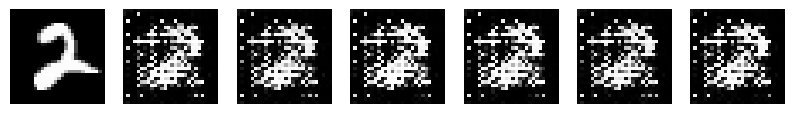

Epoch 4571 g_loss= 3.3827436 d_loss= 0.034877263 real_acc= 1.0 fake_acc= 1.0
Epoch 4572 g_loss= 3.4073572 d_loss= 0.03402295 real_acc= 1.0 fake_acc= 1.0
Epoch 4573 g_loss= 3.4213462 d_loss= 0.033563163 real_acc= 1.0 fake_acc= 1.0
Epoch 4574 g_loss= 3.4308572 d_loss= 0.033152718 real_acc= 1.0 fake_acc= 1.0
Epoch 4575 g_loss= 3.404509 d_loss= 0.034154125 real_acc= 1.0 fake_acc= 1.0
Epoch 4576 g_loss= 3.436538 d_loss= 0.033062916 real_acc= 1.0 fake_acc= 1.0
Epoch 4577 g_loss= 3.5047288 d_loss= 0.030858723 real_acc= 1.0 fake_acc= 1.0
Epoch 4578 g_loss= 3.434309 d_loss= 0.033176675 real_acc= 1.0 fake_acc= 1.0
Epoch 4579 g_loss= 3.4824378 d_loss= 0.03157232 real_acc= 1.0 fake_acc= 1.0
Epoch 4580 g_loss= 3.4887009 d_loss= 0.031270634 real_acc= 1.0 fake_acc= 1.0


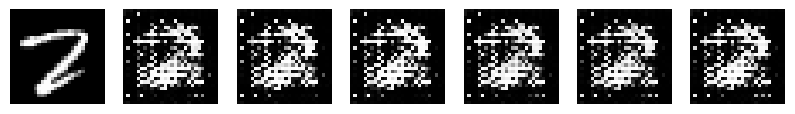

Epoch 4581 g_loss= 3.5060606 d_loss= 0.030957317 real_acc= 1.0 fake_acc= 1.0
Epoch 4582 g_loss= 3.4962268 d_loss= 0.031087067 real_acc= 1.0 fake_acc= 1.0
Epoch 4583 g_loss= 3.5190089 d_loss= 0.0303495 real_acc= 1.0 fake_acc= 1.0
Epoch 4584 g_loss= 3.5219538 d_loss= 0.03045223 real_acc= 1.0 fake_acc= 1.0
Epoch 4585 g_loss= 3.531065 d_loss= 0.030050918 real_acc= 1.0 fake_acc= 1.0
Epoch 4586 g_loss= 3.5268638 d_loss= 0.030227141 real_acc= 1.0 fake_acc= 1.0
Epoch 4587 g_loss= 3.5333107 d_loss= 0.029837726 real_acc= 1.0 fake_acc= 1.0
Epoch 4588 g_loss= 3.5820463 d_loss= 0.02855834 real_acc= 1.0 fake_acc= 1.0
Epoch 4589 g_loss= 3.5886545 d_loss= 0.028296996 real_acc= 1.0 fake_acc= 1.0
Epoch 4590 g_loss= 3.5846343 d_loss= 0.028418636 real_acc= 1.0 fake_acc= 1.0


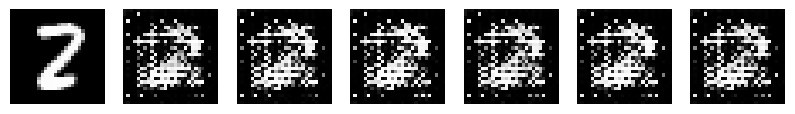

Epoch 4591 g_loss= 3.588186 d_loss= 0.02845618 real_acc= 1.0 fake_acc= 1.0
Epoch 4592 g_loss= 3.6393268 d_loss= 0.026958652 real_acc= 1.0 fake_acc= 1.0
Epoch 4593 g_loss= 3.6040761 d_loss= 0.027884196 real_acc= 1.0 fake_acc= 1.0
Epoch 4594 g_loss= 3.6392019 d_loss= 0.026946127 real_acc= 1.0 fake_acc= 1.0
Epoch 4595 g_loss= 3.625235 d_loss= 0.027239587 real_acc= 1.0 fake_acc= 1.0
Epoch 4596 g_loss= 3.643434 d_loss= 0.026791476 real_acc= 1.0 fake_acc= 1.0
Epoch 4597 g_loss= 3.6890435 d_loss= 0.025530448 real_acc= 1.0 fake_acc= 1.0
Epoch 4598 g_loss= 3.6624372 d_loss= 0.026318794 real_acc= 1.0 fake_acc= 1.0
Epoch 4599 g_loss= 3.656453 d_loss= 0.02643583 real_acc= 1.0 fake_acc= 1.0
Epoch 4600 g_loss= 3.7018442 d_loss= 0.025282513 real_acc= 1.0 fake_acc= 1.0


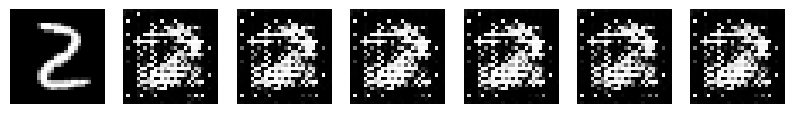

Epoch 4601 g_loss= 3.709996 d_loss= 0.024967296 real_acc= 1.0 fake_acc= 1.0
Epoch 4602 g_loss= 3.690594 d_loss= 0.025495179 real_acc= 1.0 fake_acc= 1.0
Epoch 4603 g_loss= 3.6827874 d_loss= 0.025797756 real_acc= 1.0 fake_acc= 1.0
Epoch 4604 g_loss= 3.7563982 d_loss= 0.023902118 real_acc= 1.0 fake_acc= 1.0
Epoch 4605 g_loss= 3.744049 d_loss= 0.024201239 real_acc= 1.0 fake_acc= 1.0
Epoch 4606 g_loss= 3.732132 d_loss= 0.024574721 real_acc= 1.0 fake_acc= 1.0
Epoch 4607 g_loss= 3.7731042 d_loss= 0.023502018 real_acc= 1.0 fake_acc= 1.0
Epoch 4608 g_loss= 3.7469573 d_loss= 0.02412465 real_acc= 1.0 fake_acc= 1.0
Epoch 4609 g_loss= 3.7696314 d_loss= 0.023540623 real_acc= 1.0 fake_acc= 1.0
Epoch 4610 g_loss= 3.810816 d_loss= 0.022634525 real_acc= 1.0 fake_acc= 1.0


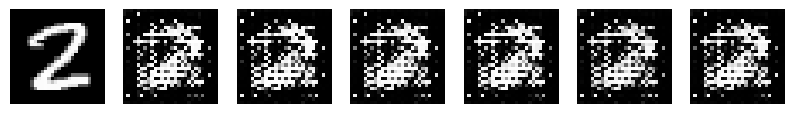

Epoch 4611 g_loss= 3.7896671 d_loss= 0.023137739 real_acc= 1.0 fake_acc= 1.0
Epoch 4612 g_loss= 3.7842202 d_loss= 0.023315696 real_acc= 1.0 fake_acc= 1.0
Epoch 4613 g_loss= 3.8162036 d_loss= 0.02250194 real_acc= 1.0 fake_acc= 1.0
Epoch 4614 g_loss= 3.810247 d_loss= 0.022658827 real_acc= 1.0 fake_acc= 1.0
Epoch 4615 g_loss= 3.8110151 d_loss= 0.022639727 real_acc= 1.0 fake_acc= 1.0
Epoch 4616 g_loss= 3.8558166 d_loss= 0.021692622 real_acc= 1.0 fake_acc= 1.0
Epoch 4617 g_loss= 3.852008 d_loss= 0.021618238 real_acc= 1.0 fake_acc= 1.0
Epoch 4618 g_loss= 3.887449 d_loss= 0.021011056 real_acc= 1.0 fake_acc= 1.0
Epoch 4619 g_loss= 3.8742065 d_loss= 0.021227933 real_acc= 1.0 fake_acc= 1.0
Epoch 4620 g_loss= 3.8693235 d_loss= 0.021246133 real_acc= 1.0 fake_acc= 1.0


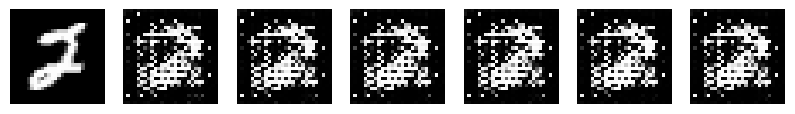

Epoch 4621 g_loss= 3.9413195 d_loss= 0.022129573 real_acc= 1.0 fake_acc= 1.0
Epoch 4622 g_loss= 3.9116092 d_loss= 0.020448238 real_acc= 1.0 fake_acc= 1.0
Epoch 4623 g_loss= 3.9292054 d_loss= 0.020178845 real_acc= 1.0 fake_acc= 1.0
Epoch 4624 g_loss= 3.923743 d_loss= 0.020271584 real_acc= 1.0 fake_acc= 1.0
Epoch 4625 g_loss= 3.9495673 d_loss= 0.019646656 real_acc= 1.0 fake_acc= 1.0
Epoch 4626 g_loss= 3.9220688 d_loss= 0.020214867 real_acc= 1.0 fake_acc= 1.0
Epoch 4627 g_loss= 3.9274414 d_loss= 0.020146206 real_acc= 1.0 fake_acc= 1.0
Epoch 4628 g_loss= 3.9254873 d_loss= 0.020194976 real_acc= 1.0 fake_acc= 1.0
Epoch 4629 g_loss= 3.9407163 d_loss= 0.019868229 real_acc= 1.0 fake_acc= 1.0
Epoch 4630 g_loss= 3.9463687 d_loss= 0.019782573 real_acc= 1.0 fake_acc= 1.0


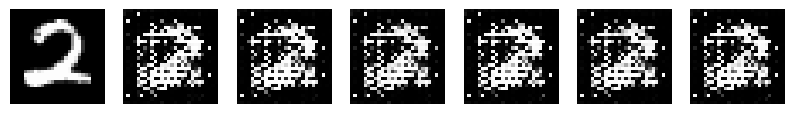

Epoch 4631 g_loss= 3.9509716 d_loss= 0.019660743 real_acc= 1.0 fake_acc= 1.0
Epoch 4632 g_loss= 3.9745505 d_loss= 0.019188272 real_acc= 1.0 fake_acc= 1.0
Epoch 4633 g_loss= 3.9473944 d_loss= 0.019650701 real_acc= 1.0 fake_acc= 1.0
Epoch 4634 g_loss= 3.9821796 d_loss= 0.019034768 real_acc= 1.0 fake_acc= 1.0
Epoch 4635 g_loss= 4.0189843 d_loss= 0.018462693 real_acc= 1.0 fake_acc= 1.0
Epoch 4636 g_loss= 3.9715307 d_loss= 0.019222457 real_acc= 1.0 fake_acc= 1.0
Epoch 4637 g_loss= 4.003572 d_loss= 0.018636573 real_acc= 1.0 fake_acc= 1.0
Epoch 4638 g_loss= 4.0222077 d_loss= 0.021341119 real_acc= 1.0 fake_acc= 1.0
Epoch 4639 g_loss= 4.0234084 d_loss= 0.01831497 real_acc= 1.0 fake_acc= 1.0
Epoch 4640 g_loss= 4.020213 d_loss= 0.018376028 real_acc= 1.0 fake_acc= 1.0


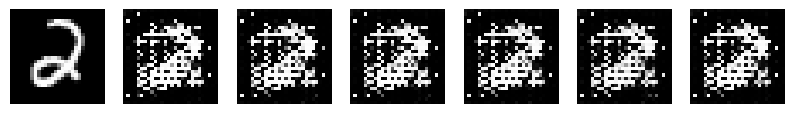

Epoch 4641 g_loss= 4.0162807 d_loss= 0.01833693 real_acc= 1.0 fake_acc= 1.0
Epoch 4642 g_loss= 4.0092006 d_loss= 0.01856041 real_acc= 1.0 fake_acc= 1.0
Epoch 4643 g_loss= 4.0390916 d_loss= 0.017976612 real_acc= 1.0 fake_acc= 1.0
Epoch 4644 g_loss= 4.0625644 d_loss= 0.017542373 real_acc= 1.0 fake_acc= 1.0
Epoch 4645 g_loss= 4.106508 d_loss= 0.016758531 real_acc= 1.0 fake_acc= 1.0
Epoch 4646 g_loss= 4.039428 d_loss= 0.018002441 real_acc= 1.0 fake_acc= 1.0
Epoch 4647 g_loss= 4.0415 d_loss= 0.01798434 real_acc= 1.0 fake_acc= 1.0
Epoch 4648 g_loss= 4.0904284 d_loss= 0.017069714 real_acc= 1.0 fake_acc= 1.0
Epoch 4649 g_loss= 4.1175003 d_loss= 0.016585898 real_acc= 1.0 fake_acc= 1.0
Epoch 4650 g_loss= 4.11339 d_loss= 0.016751261 real_acc= 1.0 fake_acc= 1.0


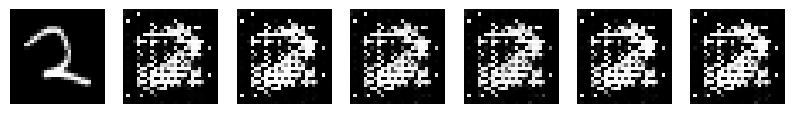

Epoch 4651 g_loss= 4.0986085 d_loss= 0.016980855 real_acc= 1.0 fake_acc= 1.0
Epoch 4652 g_loss= 4.1320934 d_loss= 0.016345076 real_acc= 1.0 fake_acc= 1.0
Epoch 4653 g_loss= 4.1460924 d_loss= 0.016208893 real_acc= 1.0 fake_acc= 1.0
Epoch 4654 g_loss= 4.111064 d_loss= 0.01685302 real_acc= 1.0 fake_acc= 1.0
Epoch 4655 g_loss= 4.127399 d_loss= 0.016402777 real_acc= 1.0 fake_acc= 1.0
Epoch 4656 g_loss= 4.179585 d_loss= 0.015627122 real_acc= 1.0 fake_acc= 1.0
Epoch 4657 g_loss= 4.1755834 d_loss= 0.01571954 real_acc= 1.0 fake_acc= 1.0
Epoch 4658 g_loss= 4.139063 d_loss= 0.016221134 real_acc= 1.0 fake_acc= 1.0
Epoch 4659 g_loss= 4.1817837 d_loss= 0.0156183215 real_acc= 1.0 fake_acc= 1.0
Epoch 4660 g_loss= 4.1836667 d_loss= 0.015490495 real_acc= 1.0 fake_acc= 1.0


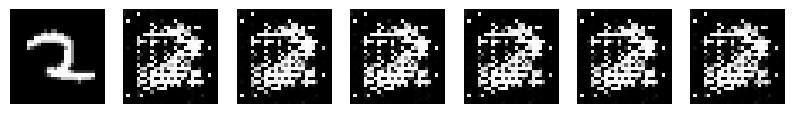

Epoch 4661 g_loss= 4.163238 d_loss= 0.015923362 real_acc= 1.0 fake_acc= 1.0
Epoch 4662 g_loss= 4.2109814 d_loss= 0.015098709 real_acc= 1.0 fake_acc= 1.0
Epoch 4663 g_loss= 4.1637306 d_loss= 0.015840068 real_acc= 1.0 fake_acc= 1.0
Epoch 4664 g_loss= 4.215155 d_loss= 0.01505268 real_acc= 1.0 fake_acc= 1.0
Epoch 4665 g_loss= 4.224469 d_loss= 0.014963985 real_acc= 1.0 fake_acc= 1.0
Epoch 4666 g_loss= 4.206184 d_loss= 0.015173679 real_acc= 1.0 fake_acc= 1.0
Epoch 4667 g_loss= 4.2201266 d_loss= 0.015023561 real_acc= 1.0 fake_acc= 1.0
Epoch 4668 g_loss= 4.234633 d_loss= 0.014726829 real_acc= 1.0 fake_acc= 1.0
Epoch 4669 g_loss= 4.238127 d_loss= 0.014752568 real_acc= 1.0 fake_acc= 1.0
Epoch 4670 g_loss= 4.2415943 d_loss= 0.014775605 real_acc= 1.0 fake_acc= 1.0


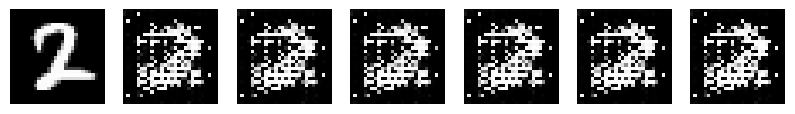

Epoch 4671 g_loss= 4.2540536 d_loss= 0.0145512745 real_acc= 1.0 fake_acc= 1.0
Epoch 4672 g_loss= 4.2676005 d_loss= 0.014263966 real_acc= 1.0 fake_acc= 1.0
Epoch 4673 g_loss= 4.2579536 d_loss= 0.014486522 real_acc= 1.0 fake_acc= 1.0
Epoch 4674 g_loss= 4.2718887 d_loss= 0.014229934 real_acc= 1.0 fake_acc= 1.0
Epoch 4675 g_loss= 4.320336 d_loss= 0.013560401 real_acc= 1.0 fake_acc= 1.0
Epoch 4676 g_loss= 4.3155613 d_loss= 0.013590111 real_acc= 1.0 fake_acc= 1.0
Epoch 4677 g_loss= 4.284302 d_loss= 0.014037336 real_acc= 1.0 fake_acc= 1.0
Epoch 4678 g_loss= 4.3060665 d_loss= 0.013792745 real_acc= 1.0 fake_acc= 1.0
Epoch 4679 g_loss= 4.298546 d_loss= 0.013829481 real_acc= 1.0 fake_acc= 1.0
Epoch 4680 g_loss= 4.323274 d_loss= 0.013498518 real_acc= 1.0 fake_acc= 1.0


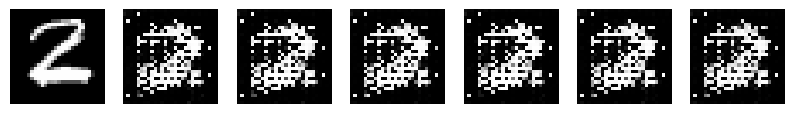

Epoch 4681 g_loss= 4.30259 d_loss= 0.013839142 real_acc= 1.0 fake_acc= 1.0
Epoch 4682 g_loss= 4.3011537 d_loss= 0.013858685 real_acc= 1.0 fake_acc= 1.0
Epoch 4683 g_loss= 4.37012 d_loss= 0.012923429 real_acc= 1.0 fake_acc= 1.0
Epoch 4684 g_loss= 4.3433137 d_loss= 0.0132149765 real_acc= 1.0 fake_acc= 1.0
Epoch 4685 g_loss= 4.3375664 d_loss= 0.013373116 real_acc= 1.0 fake_acc= 1.0
Epoch 4686 g_loss= 4.3933973 d_loss= 0.012597427 real_acc= 1.0 fake_acc= 1.0
Epoch 4687 g_loss= 4.3685203 d_loss= 0.012928848 real_acc= 1.0 fake_acc= 1.0
Epoch 4688 g_loss= 4.3584056 d_loss= 0.0131214345 real_acc= 1.0 fake_acc= 1.0
Epoch 4689 g_loss= 4.3910866 d_loss= 0.012616488 real_acc= 1.0 fake_acc= 1.0
Epoch 4690 g_loss= 4.4103956 d_loss= 0.012390163 real_acc= 1.0 fake_acc= 1.0


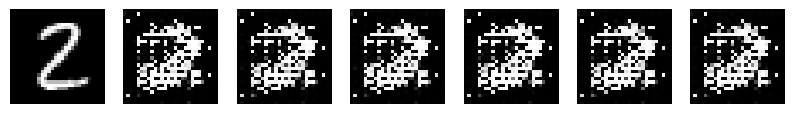

Epoch 4691 g_loss= 4.406671 d_loss= 0.012417572 real_acc= 1.0 fake_acc= 1.0
Epoch 4692 g_loss= 4.346927 d_loss= 0.013177847 real_acc= 1.0 fake_acc= 1.0
Epoch 4693 g_loss= 4.425612 d_loss= 0.0122233145 real_acc= 1.0 fake_acc= 1.0
Epoch 4694 g_loss= 4.426453 d_loss= 0.012231838 real_acc= 1.0 fake_acc= 1.0
Epoch 4695 g_loss= 4.4126606 d_loss= 0.012407475 real_acc= 1.0 fake_acc= 1.0
Epoch 4696 g_loss= 4.4111853 d_loss= 0.012445889 real_acc= 1.0 fake_acc= 1.0
Epoch 4697 g_loss= 4.4517074 d_loss= 0.011887328 real_acc= 1.0 fake_acc= 1.0
Epoch 4698 g_loss= 4.424169 d_loss= 0.012248416 real_acc= 1.0 fake_acc= 1.0
Epoch 4699 g_loss= 4.394681 d_loss= 0.012643974 real_acc= 1.0 fake_acc= 1.0
Epoch 4700 g_loss= 4.46799 d_loss= 0.011659057 real_acc= 1.0 fake_acc= 1.0


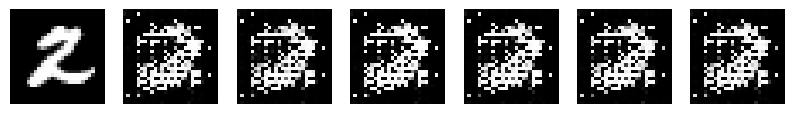

Epoch 4701 g_loss= 4.472765 d_loss= 0.011625421 real_acc= 1.0 fake_acc= 1.0
Epoch 4702 g_loss= 4.4843626 d_loss= 0.080876514 real_acc= 0.98 fake_acc= 1.0
Epoch 4703 g_loss= 4.481205 d_loss= 0.011559658 real_acc= 1.0 fake_acc= 1.0
Epoch 4704 g_loss= 4.4376845 d_loss= 0.012006725 real_acc= 1.0 fake_acc= 1.0
Epoch 4705 g_loss= 4.4382534 d_loss= 0.012071608 real_acc= 1.0 fake_acc= 1.0
Epoch 4706 g_loss= 4.4952836 d_loss= 0.011401152 real_acc= 1.0 fake_acc= 1.0
Epoch 4707 g_loss= 4.4143233 d_loss= 0.012394372 real_acc= 1.0 fake_acc= 1.0
Epoch 4708 g_loss= 4.4235115 d_loss= 0.012189733 real_acc= 1.0 fake_acc= 1.0
Epoch 4709 g_loss= 4.408728 d_loss= 0.012391321 real_acc= 1.0 fake_acc= 1.0
Epoch 4710 g_loss= 4.4066787 d_loss= 0.012407196 real_acc= 1.0 fake_acc= 1.0


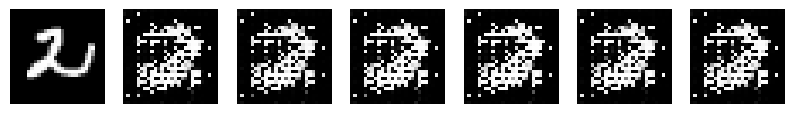

Epoch 4711 g_loss= 4.4374447 d_loss= 0.012059108 real_acc= 1.0 fake_acc= 1.0
Epoch 4712 g_loss= 4.40747 d_loss= 0.012405948 real_acc= 1.0 fake_acc= 1.0
Epoch 4713 g_loss= 4.3936048 d_loss= 0.012556609 real_acc= 1.0 fake_acc= 1.0
Epoch 4714 g_loss= 4.4051476 d_loss= 0.012416265 real_acc= 1.0 fake_acc= 1.0
Epoch 4715 g_loss= 4.409967 d_loss= 0.01237059 real_acc= 1.0 fake_acc= 1.0
Epoch 4716 g_loss= 4.4351854 d_loss= 0.012013972 real_acc= 1.0 fake_acc= 1.0
Epoch 4717 g_loss= 4.41188 d_loss= 0.012386003 real_acc= 1.0 fake_acc= 1.0
Epoch 4718 g_loss= 4.4345455 d_loss= 0.012167097 real_acc= 1.0 fake_acc= 1.0
Epoch 4719 g_loss= 4.379239 d_loss= 0.012796762 real_acc= 1.0 fake_acc= 1.0
Epoch 4720 g_loss= 4.4029818 d_loss= 0.012445373 real_acc= 1.0 fake_acc= 1.0


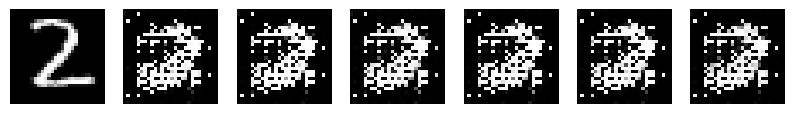

Epoch 4721 g_loss= 4.4343724 d_loss= 0.012131769 real_acc= 1.0 fake_acc= 1.0
Epoch 4722 g_loss= 4.423208 d_loss= 0.012286642 real_acc= 1.0 fake_acc= 1.0
Epoch 4723 g_loss= 4.4331355 d_loss= 0.012115847 real_acc= 1.0 fake_acc= 1.0
Epoch 4724 g_loss= 4.4379325 d_loss= 0.012097441 real_acc= 1.0 fake_acc= 1.0
Epoch 4725 g_loss= 4.4084587 d_loss= 0.012399797 real_acc= 1.0 fake_acc= 1.0
Epoch 4726 g_loss= 4.4483695 d_loss= 0.011923118 real_acc= 1.0 fake_acc= 1.0
Epoch 4727 g_loss= 4.470156 d_loss= 0.011654027 real_acc= 1.0 fake_acc= 1.0
Epoch 4728 g_loss= 4.406675 d_loss= 0.012414822 real_acc= 1.0 fake_acc= 1.0
Epoch 4729 g_loss= 4.4517097 d_loss= 0.011860264 real_acc= 1.0 fake_acc= 1.0
Epoch 4730 g_loss= 4.4673533 d_loss= 0.011652312 real_acc= 1.0 fake_acc= 1.0


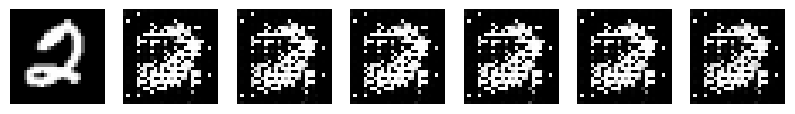

Epoch 4731 g_loss= 4.4979076 d_loss= 0.011387604 real_acc= 1.0 fake_acc= 1.0
Epoch 4732 g_loss= 4.504473 d_loss= 0.01130271 real_acc= 1.0 fake_acc= 1.0
Epoch 4733 g_loss= 4.4691224 d_loss= 0.011725434 real_acc= 1.0 fake_acc= 1.0
Epoch 4734 g_loss= 4.498556 d_loss= 0.011332314 real_acc= 1.0 fake_acc= 1.0
Epoch 4735 g_loss= 4.5108585 d_loss= 0.011225884 real_acc= 1.0 fake_acc= 1.0
Epoch 4736 g_loss= 4.5210376 d_loss= 0.011113063 real_acc= 1.0 fake_acc= 1.0
Epoch 4737 g_loss= 4.5065694 d_loss= 0.011281598 real_acc= 1.0 fake_acc= 1.0
Epoch 4738 g_loss= 4.52607 d_loss= 0.011028746 real_acc= 1.0 fake_acc= 1.0
Epoch 4739 g_loss= 4.4929385 d_loss= 0.011415433 real_acc= 1.0 fake_acc= 1.0
Epoch 4740 g_loss= 4.543047 d_loss= 0.010862894 real_acc= 1.0 fake_acc= 1.0


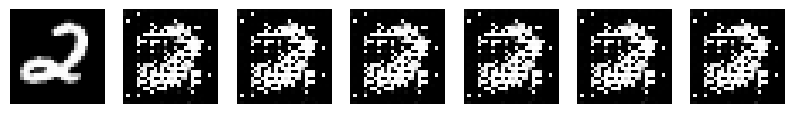

Epoch 4741 g_loss= 4.537194 d_loss= 0.010958254 real_acc= 1.0 fake_acc= 1.0
Epoch 4742 g_loss= 4.5664687 d_loss= 0.010619176 real_acc= 1.0 fake_acc= 1.0
Epoch 4743 g_loss= 4.5742564 d_loss= 0.010561002 real_acc= 1.0 fake_acc= 1.0
Epoch 4744 g_loss= 4.5351877 d_loss= 0.010980441 real_acc= 1.0 fake_acc= 1.0
Epoch 4745 g_loss= 4.5156255 d_loss= 0.013178622 real_acc= 1.0 fake_acc= 1.0
Epoch 4746 g_loss= 4.588981 d_loss= 0.010353427 real_acc= 1.0 fake_acc= 1.0
Epoch 4747 g_loss= 4.5805016 d_loss= 0.010431074 real_acc= 1.0 fake_acc= 1.0
Epoch 4748 g_loss= 4.5622177 d_loss= 0.010705088 real_acc= 1.0 fake_acc= 1.0
Epoch 4749 g_loss= 4.5467787 d_loss= 0.010805964 real_acc= 1.0 fake_acc= 1.0
Epoch 4750 g_loss= 4.603246 d_loss= 0.010223917 real_acc= 1.0 fake_acc= 1.0


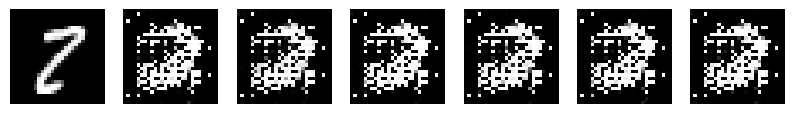

Epoch 4751 g_loss= 4.5983696 d_loss= 0.010305426 real_acc= 1.0 fake_acc= 1.0
Epoch 4752 g_loss= 4.6510763 d_loss= 0.009731732 real_acc= 1.0 fake_acc= 1.0
Epoch 4753 g_loss= 4.6037903 d_loss= 0.010189032 real_acc= 1.0 fake_acc= 1.0
Epoch 4754 g_loss= 4.629094 d_loss= 0.00997315 real_acc= 1.0 fake_acc= 1.0
Epoch 4755 g_loss= 4.6386714 d_loss= 0.009894297 real_acc= 1.0 fake_acc= 1.0
Epoch 4756 g_loss= 4.6092935 d_loss= 0.010201977 real_acc= 1.0 fake_acc= 1.0
Epoch 4757 g_loss= 4.6799192 d_loss= 0.0094609335 real_acc= 1.0 fake_acc= 1.0
Epoch 4758 g_loss= 4.63383 d_loss= 0.009955184 real_acc= 1.0 fake_acc= 1.0
Epoch 4759 g_loss= 4.6323013 d_loss= 0.009921908 real_acc= 1.0 fake_acc= 1.0
Epoch 4760 g_loss= 4.6914635 d_loss= 0.009391679 real_acc= 1.0 fake_acc= 1.0


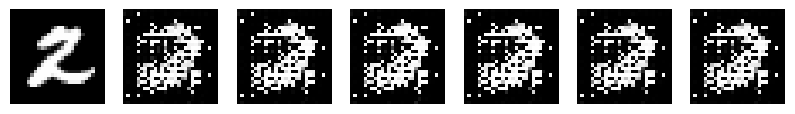

Epoch 4761 g_loss= 4.6286836 d_loss= 0.009983868 real_acc= 1.0 fake_acc= 1.0
Epoch 4762 g_loss= 4.6920466 d_loss= 0.009325945 real_acc= 1.0 fake_acc= 1.0
Epoch 4763 g_loss= 4.629829 d_loss= 0.009990095 real_acc= 1.0 fake_acc= 1.0
Epoch 4764 g_loss= 4.676432 d_loss= 0.009469781 real_acc= 1.0 fake_acc= 1.0
Epoch 4765 g_loss= 4.645903 d_loss= 0.009764325 real_acc= 1.0 fake_acc= 1.0
Epoch 4766 g_loss= 4.6734843 d_loss= 0.009535053 real_acc= 1.0 fake_acc= 1.0
Epoch 4767 g_loss= 4.6508117 d_loss= 0.009703741 real_acc= 1.0 fake_acc= 1.0
Epoch 4768 g_loss= 4.7230625 d_loss= 0.0090993 real_acc= 1.0 fake_acc= 1.0
Epoch 4769 g_loss= 4.6901627 d_loss= 0.009394317 real_acc= 1.0 fake_acc= 1.0
Epoch 4770 g_loss= 4.717283 d_loss= 0.009253945 real_acc= 1.0 fake_acc= 1.0


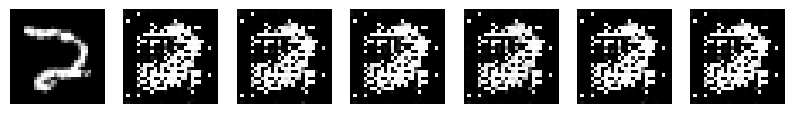

Epoch 4771 g_loss= 4.7083144 d_loss= 0.009251592 real_acc= 1.0 fake_acc= 1.0
Epoch 4772 g_loss= 4.7439055 d_loss= 0.008842457 real_acc= 1.0 fake_acc= 1.0
Epoch 4773 g_loss= 4.7646103 d_loss= 0.008697211 real_acc= 1.0 fake_acc= 1.0
Epoch 4774 g_loss= 4.7272615 d_loss= 0.009029208 real_acc= 1.0 fake_acc= 1.0
Epoch 4775 g_loss= 4.6919236 d_loss= 0.00936189 real_acc= 1.0 fake_acc= 1.0
Epoch 4776 g_loss= 4.7190833 d_loss= 0.009109507 real_acc= 1.0 fake_acc= 1.0
Epoch 4777 g_loss= 4.7345276 d_loss= 0.009038443 real_acc= 1.0 fake_acc= 1.0
Epoch 4778 g_loss= 4.772161 d_loss= 0.008626284 real_acc= 1.0 fake_acc= 1.0
Epoch 4779 g_loss= 4.742088 d_loss= 0.008893908 real_acc= 1.0 fake_acc= 1.0
Epoch 4780 g_loss= 4.763185 d_loss= 0.0086996015 real_acc= 1.0 fake_acc= 1.0


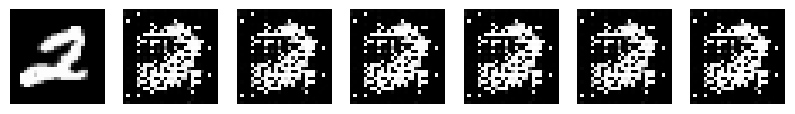

Epoch 4781 g_loss= 4.736051 d_loss= 0.008965443 real_acc= 1.0 fake_acc= 1.0
Epoch 4782 g_loss= 4.80012 d_loss= 0.008364483 real_acc= 1.0 fake_acc= 1.0
Epoch 4783 g_loss= 4.7409925 d_loss= 0.008891752 real_acc= 1.0 fake_acc= 1.0
Epoch 4784 g_loss= 4.7327 d_loss= 0.008940425 real_acc= 1.0 fake_acc= 1.0
Epoch 4785 g_loss= 4.774701 d_loss= 0.0085968785 real_acc= 1.0 fake_acc= 1.0
Epoch 4786 g_loss= 4.8480353 d_loss= 0.008019663 real_acc= 1.0 fake_acc= 1.0
Epoch 4787 g_loss= 4.7764783 d_loss= 0.008623156 real_acc= 1.0 fake_acc= 1.0
Epoch 4788 g_loss= 4.8270473 d_loss= 0.008177829 real_acc= 1.0 fake_acc= 1.0
Epoch 4789 g_loss= 4.853588 d_loss= 0.007979244 real_acc= 1.0 fake_acc= 1.0
Epoch 4790 g_loss= 4.861147 d_loss= 0.0079347035 real_acc= 1.0 fake_acc= 1.0


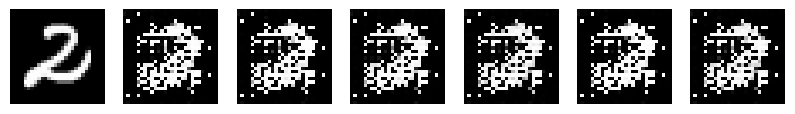

Epoch 4791 g_loss= 4.788919 d_loss= 0.008492884 real_acc= 1.0 fake_acc= 1.0
Epoch 4792 g_loss= 4.8419094 d_loss= 0.008069168 real_acc= 1.0 fake_acc= 1.0
Epoch 4793 g_loss= 4.848966 d_loss= 0.00798249 real_acc= 1.0 fake_acc= 1.0
Epoch 4794 g_loss= 4.792586 d_loss= 0.008480368 real_acc= 1.0 fake_acc= 1.0
Epoch 4795 g_loss= 4.8576474 d_loss= 0.007897761 real_acc= 1.0 fake_acc= 1.0
Epoch 4796 g_loss= 4.861727 d_loss= 0.007845299 real_acc= 1.0 fake_acc= 1.0
Epoch 4797 g_loss= 4.85626 d_loss= 0.0079352055 real_acc= 1.0 fake_acc= 1.0
Epoch 4798 g_loss= 4.8685203 d_loss= 0.007804358 real_acc= 1.0 fake_acc= 1.0
Epoch 4799 g_loss= 4.8659916 d_loss= 0.007823064 real_acc= 1.0 fake_acc= 1.0
Epoch 4800 g_loss= 4.898737 d_loss= 0.0076496885 real_acc= 1.0 fake_acc= 1.0


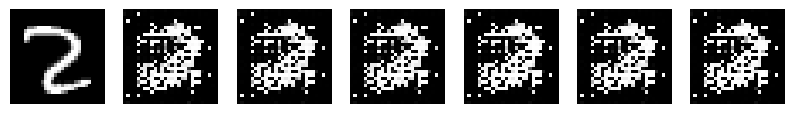

Epoch 4801 g_loss= 4.899226 d_loss= 0.007638576 real_acc= 1.0 fake_acc= 1.0
Epoch 4802 g_loss= 4.8948784 d_loss= 0.0076520173 real_acc= 1.0 fake_acc= 1.0
Epoch 4803 g_loss= 4.8514967 d_loss= 0.007986904 real_acc= 1.0 fake_acc= 1.0
Epoch 4804 g_loss= 4.9180136 d_loss= 0.0074405535 real_acc= 1.0 fake_acc= 1.0
Epoch 4805 g_loss= 4.9457235 d_loss= 0.007244401 real_acc= 1.0 fake_acc= 1.0
Epoch 4806 g_loss= 4.9110417 d_loss= 0.0075393114 real_acc= 1.0 fake_acc= 1.0
Epoch 4807 g_loss= 4.9218445 d_loss= 0.0074171224 real_acc= 1.0 fake_acc= 1.0
Epoch 4808 g_loss= 4.9386787 d_loss= 0.0072770687 real_acc= 1.0 fake_acc= 1.0
Epoch 4809 g_loss= 4.9282537 d_loss= 0.0073569915 real_acc= 1.0 fake_acc= 1.0
Epoch 4810 g_loss= 4.9322767 d_loss= 0.0073489677 real_acc= 1.0 fake_acc= 1.0


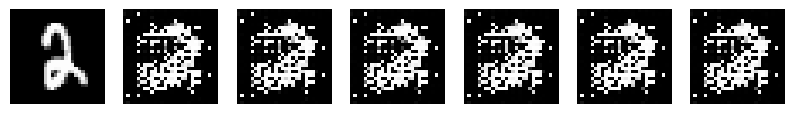

Epoch 4811 g_loss= 4.8882365 d_loss= 0.007683365 real_acc= 1.0 fake_acc= 1.0
Epoch 4812 g_loss= 4.9569263 d_loss= 0.0071824836 real_acc= 1.0 fake_acc= 1.0
Epoch 4813 g_loss= 4.9449043 d_loss= 0.007243869 real_acc= 1.0 fake_acc= 1.0
Epoch 4814 g_loss= 4.968233 d_loss= 0.007071418 real_acc= 1.0 fake_acc= 1.0
Epoch 4815 g_loss= 5.0056224 d_loss= 0.0068042176 real_acc= 1.0 fake_acc= 1.0
Epoch 4816 g_loss= 4.9554462 d_loss= 0.007165648 real_acc= 1.0 fake_acc= 1.0
Epoch 4817 g_loss= 4.949422 d_loss= 0.0072033163 real_acc= 1.0 fake_acc= 1.0
Epoch 4818 g_loss= 5.0166993 d_loss= 0.0067144735 real_acc= 1.0 fake_acc= 1.0
Epoch 4819 g_loss= 4.9661317 d_loss= 0.007127246 real_acc= 1.0 fake_acc= 1.0
Epoch 4820 g_loss= 5.0309315 d_loss= 0.006670026 real_acc= 1.0 fake_acc= 1.0


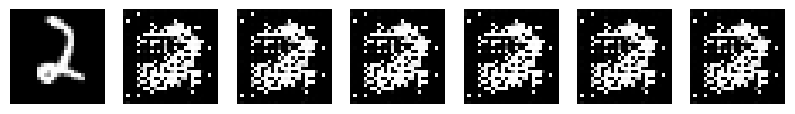

Epoch 4821 g_loss= 5.0516596 d_loss= 0.006549273 real_acc= 1.0 fake_acc= 1.0
Epoch 4822 g_loss= 4.973323 d_loss= 0.007073606 real_acc= 1.0 fake_acc= 1.0
Epoch 4823 g_loss= 5.0332613 d_loss= 0.006657931 real_acc= 1.0 fake_acc= 1.0
Epoch 4824 g_loss= 5.0373597 d_loss= 0.006595242 real_acc= 1.0 fake_acc= 1.0
Epoch 4825 g_loss= 4.9933233 d_loss= 0.006910782 real_acc= 1.0 fake_acc= 1.0
Epoch 4826 g_loss= 4.9745812 d_loss= 0.007072926 real_acc= 1.0 fake_acc= 1.0
Epoch 4827 g_loss= 5.0523252 d_loss= 0.006567514 real_acc= 1.0 fake_acc= 1.0
Epoch 4828 g_loss= 5.023393 d_loss= 0.00696382 real_acc= 1.0 fake_acc= 1.0
Epoch 4829 g_loss= 5.023558 d_loss= 0.006729574 real_acc= 1.0 fake_acc= 1.0
Epoch 4830 g_loss= 5.0286183 d_loss= 0.0066791936 real_acc= 1.0 fake_acc= 1.0


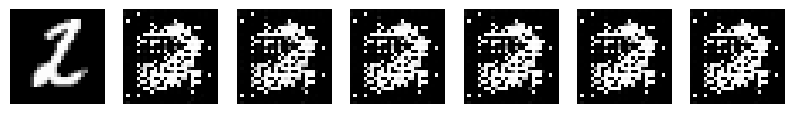

Epoch 4831 g_loss= 5.0470033 d_loss= 0.0066280323 real_acc= 1.0 fake_acc= 1.0
Epoch 4832 g_loss= 5.044482 d_loss= 0.007333493 real_acc= 1.0 fake_acc= 1.0
Epoch 4833 g_loss= 5.0522842 d_loss= 0.006534193 real_acc= 1.0 fake_acc= 1.0
Epoch 4834 g_loss= 5.0807686 d_loss= 0.019642264 real_acc= 1.0 fake_acc= 1.0
Epoch 4835 g_loss= 5.0437703 d_loss= 0.0065902965 real_acc= 1.0 fake_acc= 1.0
Epoch 4836 g_loss= 5.027109 d_loss= 0.0072497902 real_acc= 1.0 fake_acc= 1.0
Epoch 4837 g_loss= 5.049317 d_loss= 0.0065162377 real_acc= 1.0 fake_acc= 1.0
Epoch 4838 g_loss= 5.0224147 d_loss= 0.006790722 real_acc= 1.0 fake_acc= 1.0
Epoch 4839 g_loss= 5.0191174 d_loss= 0.006728335 real_acc= 1.0 fake_acc= 1.0
Epoch 4840 g_loss= 4.997061 d_loss= 0.006897528 real_acc= 1.0 fake_acc= 1.0


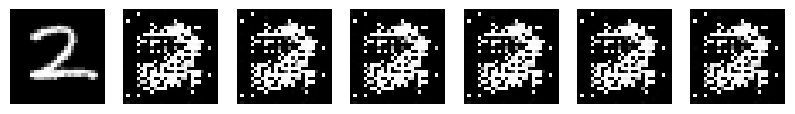

Epoch 4841 g_loss= 5.0558367 d_loss= 0.0064804195 real_acc= 1.0 fake_acc= 1.0
Epoch 4842 g_loss= 5.010779 d_loss= 0.0068319608 real_acc= 1.0 fake_acc= 1.0
Epoch 4843 g_loss= 4.9972615 d_loss= 0.006930357 real_acc= 1.0 fake_acc= 1.0
Epoch 4844 g_loss= 4.9858623 d_loss= 0.007000521 real_acc= 1.0 fake_acc= 1.0
Epoch 4845 g_loss= 5.0155888 d_loss= 0.0067838053 real_acc= 1.0 fake_acc= 1.0
Epoch 4846 g_loss= 5.070257 d_loss= 0.006444261 real_acc= 1.0 fake_acc= 1.0
Epoch 4847 g_loss= 5.031971 d_loss= 0.006639985 real_acc= 1.0 fake_acc= 1.0
Epoch 4848 g_loss= 5.012157 d_loss= 0.0068200557 real_acc= 1.0 fake_acc= 1.0
Epoch 4849 g_loss= 4.990032 d_loss= 0.0069302917 real_acc= 1.0 fake_acc= 1.0
Epoch 4850 g_loss= 5.0259337 d_loss= 0.0066821664 real_acc= 1.0 fake_acc= 1.0


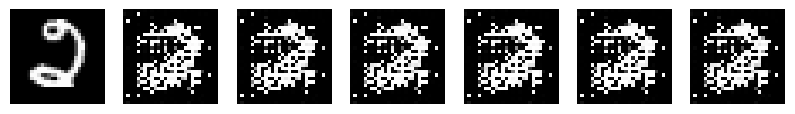

Epoch 4851 g_loss= 4.989912 d_loss= 0.0068966355 real_acc= 1.0 fake_acc= 1.0
Epoch 4852 g_loss= 5.0445285 d_loss= 0.006577059 real_acc= 1.0 fake_acc= 1.0
Epoch 4853 g_loss= 5.0367312 d_loss= 0.0066154576 real_acc= 1.0 fake_acc= 1.0
Epoch 4854 g_loss= 5.024914 d_loss= 0.0067426115 real_acc= 1.0 fake_acc= 1.0
Epoch 4855 g_loss= 5.048701 d_loss= 0.006561675 real_acc= 1.0 fake_acc= 1.0
Epoch 4856 g_loss= 5.0193324 d_loss= 0.006766766 real_acc= 1.0 fake_acc= 1.0
Epoch 4857 g_loss= 5.02561 d_loss= 0.0067226645 real_acc= 1.0 fake_acc= 1.0
Epoch 4858 g_loss= 5.037308 d_loss= 0.0066119526 real_acc= 1.0 fake_acc= 1.0
Epoch 4859 g_loss= 5.0146055 d_loss= 0.006752855 real_acc= 1.0 fake_acc= 1.0
Epoch 4860 g_loss= 4.984126 d_loss= 0.00699451 real_acc= 1.0 fake_acc= 1.0


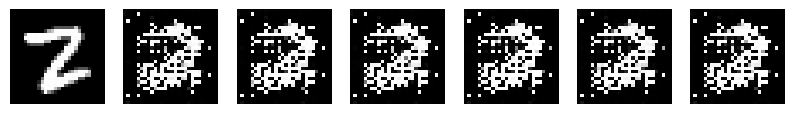

Epoch 4861 g_loss= 5.0540066 d_loss= 0.0065110475 real_acc= 1.0 fake_acc= 1.0
Epoch 4862 g_loss= 5.0336328 d_loss= 0.0066886465 real_acc= 1.0 fake_acc= 1.0
Epoch 4863 g_loss= 5.015086 d_loss= 0.006792698 real_acc= 1.0 fake_acc= 1.0
Epoch 4864 g_loss= 5.032139 d_loss= 0.006641164 real_acc= 1.0 fake_acc= 1.0
Epoch 4865 g_loss= 5.054671 d_loss= 0.006508213 real_acc= 1.0 fake_acc= 1.0
Epoch 4866 g_loss= 5.0871625 d_loss= 0.0062885596 real_acc= 1.0 fake_acc= 1.0
Epoch 4867 g_loss= 5.0787487 d_loss= 0.006381951 real_acc= 1.0 fake_acc= 1.0
Epoch 4868 g_loss= 5.0991583 d_loss= 0.006218909 real_acc= 1.0 fake_acc= 1.0
Epoch 4869 g_loss= 5.108426 d_loss= 0.0061617317 real_acc= 1.0 fake_acc= 1.0
Epoch 4870 g_loss= 5.0971904 d_loss= 0.00623742 real_acc= 1.0 fake_acc= 1.0


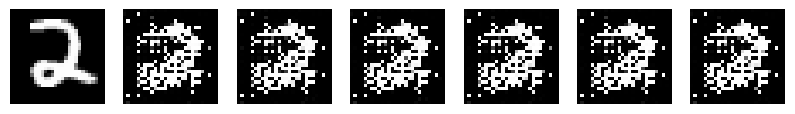

Epoch 4871 g_loss= 5.0962844 d_loss= 0.0062557664 real_acc= 1.0 fake_acc= 1.0
Epoch 4872 g_loss= 5.1013155 d_loss= 0.006210426 real_acc= 1.0 fake_acc= 1.0
Epoch 4873 g_loss= 5.104807 d_loss= 0.006177924 real_acc= 1.0 fake_acc= 1.0
Epoch 4874 g_loss= 5.0920396 d_loss= 0.0062626125 real_acc= 1.0 fake_acc= 1.0
Epoch 4875 g_loss= 5.1258807 d_loss= 0.0060743755 real_acc= 1.0 fake_acc= 1.0
Epoch 4876 g_loss= 5.132566 d_loss= 0.005988112 real_acc= 1.0 fake_acc= 1.0
Epoch 4877 g_loss= 5.091337 d_loss= 0.0062545985 real_acc= 1.0 fake_acc= 1.0
Epoch 4878 g_loss= 5.094928 d_loss= 0.006230931 real_acc= 1.0 fake_acc= 1.0
Epoch 4879 g_loss= 5.1077666 d_loss= 0.0061893896 real_acc= 1.0 fake_acc= 1.0
Epoch 4880 g_loss= 5.137711 d_loss= 0.005970788 real_acc= 1.0 fake_acc= 1.0


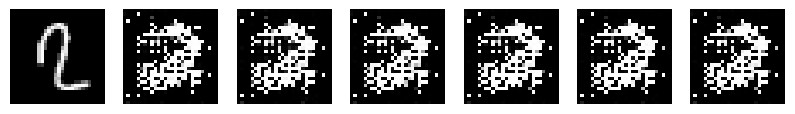

Epoch 4881 g_loss= 5.109417 d_loss= 0.0061646407 real_acc= 1.0 fake_acc= 1.0
Epoch 4882 g_loss= 5.1190853 d_loss= 0.00613752 real_acc= 1.0 fake_acc= 1.0
Epoch 4883 g_loss= 5.154978 d_loss= 0.0058544623 real_acc= 1.0 fake_acc= 1.0
Epoch 4884 g_loss= 5.148765 d_loss= 0.005951762 real_acc= 1.0 fake_acc= 1.0
Epoch 4885 g_loss= 5.178963 d_loss= 0.0057500433 real_acc= 1.0 fake_acc= 1.0
Epoch 4886 g_loss= 5.1638875 d_loss= 0.005826771 real_acc= 1.0 fake_acc= 1.0
Epoch 4887 g_loss= 5.184989 d_loss= 0.0056765457 real_acc= 1.0 fake_acc= 1.0
Epoch 4888 g_loss= 5.1942487 d_loss= 0.0056730853 real_acc= 1.0 fake_acc= 1.0
Epoch 4889 g_loss= 5.16375 d_loss= 0.0058427337 real_acc= 1.0 fake_acc= 1.0
Epoch 4890 g_loss= 5.1826005 d_loss= 0.005752334 real_acc= 1.0 fake_acc= 1.0


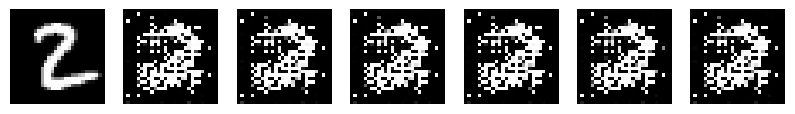

Epoch 4891 g_loss= 5.1757054 d_loss= 0.0057994365 real_acc= 1.0 fake_acc= 1.0
Epoch 4892 g_loss= 5.1809564 d_loss= 0.0057528727 real_acc= 1.0 fake_acc= 1.0
Epoch 4893 g_loss= 5.198172 d_loss= 0.005620455 real_acc= 1.0 fake_acc= 1.0
Epoch 4894 g_loss= 5.231999 d_loss= 0.0054275664 real_acc= 1.0 fake_acc= 1.0
Epoch 4895 g_loss= 5.205634 d_loss= 0.0055809557 real_acc= 1.0 fake_acc= 1.0
Epoch 4896 g_loss= 5.215541 d_loss= 0.0055600363 real_acc= 1.0 fake_acc= 1.0
Epoch 4897 g_loss= 5.253702 d_loss= 0.005328819 real_acc= 1.0 fake_acc= 1.0
Epoch 4898 g_loss= 5.258667 d_loss= 0.0052846526 real_acc= 1.0 fake_acc= 1.0
Epoch 4899 g_loss= 5.225629 d_loss= 0.005498903 real_acc= 1.0 fake_acc= 1.0
Epoch 4900 g_loss= 5.2224126 d_loss= 0.005515577 real_acc= 1.0 fake_acc= 1.0


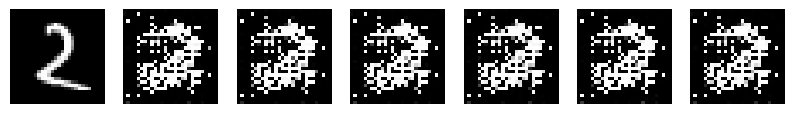

Epoch 4901 g_loss= 5.2302785 d_loss= 0.19495493 real_acc= 0.98 fake_acc= 1.0
Epoch 4902 g_loss= 5.213505 d_loss= 0.005550289 real_acc= 1.0 fake_acc= 1.0
Epoch 4903 g_loss= 5.2032323 d_loss= 0.005604218 real_acc= 1.0 fake_acc= 1.0
Epoch 4904 g_loss= 5.1725574 d_loss= 0.005772867 real_acc= 1.0 fake_acc= 1.0
Epoch 4905 g_loss= 5.1843476 d_loss= 0.005745031 real_acc= 1.0 fake_acc= 1.0
Epoch 4906 g_loss= 5.0952206 d_loss= 0.0062436294 real_acc= 1.0 fake_acc= 1.0
Epoch 4907 g_loss= 5.0476427 d_loss= 0.0065421415 real_acc= 1.0 fake_acc= 1.0
Epoch 4908 g_loss= 5.068025 d_loss= 0.0064423056 real_acc= 1.0 fake_acc= 1.0
Epoch 4909 g_loss= 5.111612 d_loss= 0.00615097 real_acc= 1.0 fake_acc= 1.0
Epoch 4910 g_loss= 4.9751825 d_loss= 0.0070772795 real_acc= 1.0 fake_acc= 1.0


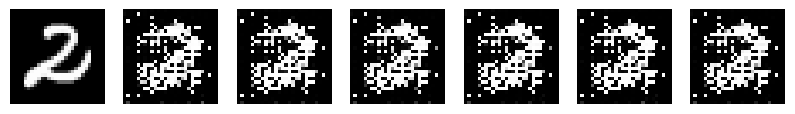

Epoch 4911 g_loss= 4.9987535 d_loss= 0.006899318 real_acc= 1.0 fake_acc= 1.0
Epoch 4912 g_loss= 5.022954 d_loss= 0.006776863 real_acc= 1.0 fake_acc= 1.0
Epoch 4913 g_loss= 5.03707 d_loss= 0.006619106 real_acc= 1.0 fake_acc= 1.0
Epoch 4914 g_loss= 5.0201974 d_loss= 0.00670803 real_acc= 1.0 fake_acc= 1.0
Epoch 4915 g_loss= 4.9698086 d_loss= 0.0070883874 real_acc= 1.0 fake_acc= 1.0
Epoch 4916 g_loss= 5.0160017 d_loss= 0.0067606596 real_acc= 1.0 fake_acc= 1.0
Epoch 4917 g_loss= 4.9593344 d_loss= 0.0071621235 real_acc= 1.0 fake_acc= 1.0
Epoch 4918 g_loss= 5.01837 d_loss= 0.006768495 real_acc= 1.0 fake_acc= 1.0
Epoch 4919 g_loss= 4.9786367 d_loss= 0.007057229 real_acc= 1.0 fake_acc= 1.0
Epoch 4920 g_loss= 5.0099225 d_loss= 0.0067972285 real_acc= 1.0 fake_acc= 1.0


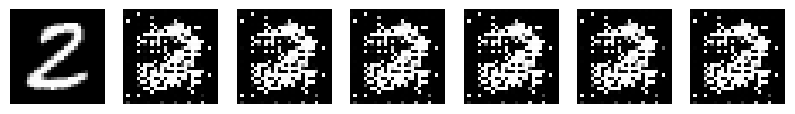

Epoch 4921 g_loss= 4.941765 d_loss= 0.0073061083 real_acc= 1.0 fake_acc= 1.0
Epoch 4922 g_loss= 4.9320607 d_loss= 0.007331823 real_acc= 1.0 fake_acc= 1.0
Epoch 4923 g_loss= 4.963699 d_loss= 0.007139775 real_acc= 1.0 fake_acc= 1.0
Epoch 4924 g_loss= 4.93875 d_loss= 0.007318521 real_acc= 1.0 fake_acc= 1.0
Epoch 4925 g_loss= 4.931752 d_loss= 0.007338541 real_acc= 1.0 fake_acc= 1.0
Epoch 4926 g_loss= 4.951937 d_loss= 0.0072387774 real_acc= 1.0 fake_acc= 1.0
Epoch 4927 g_loss= 4.9933577 d_loss= 0.006892352 real_acc= 1.0 fake_acc= 1.0
Epoch 4928 g_loss= 4.963786 d_loss= 0.0071526235 real_acc= 1.0 fake_acc= 1.0
Epoch 4929 g_loss= 4.9775853 d_loss= 0.0070349462 real_acc= 1.0 fake_acc= 1.0
Epoch 4930 g_loss= 5.0113173 d_loss= 0.0067853313 real_acc= 1.0 fake_acc= 1.0


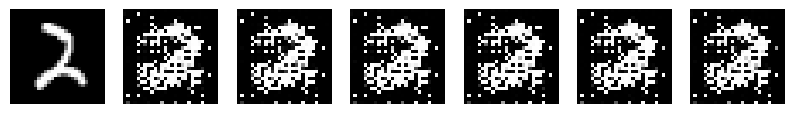

Epoch 4931 g_loss= 4.977945 d_loss= 0.007036528 real_acc= 1.0 fake_acc= 1.0
Epoch 4932 g_loss= 4.970764 d_loss= 0.007069911 real_acc= 1.0 fake_acc= 1.0
Epoch 4933 g_loss= 4.9998674 d_loss= 0.0068563195 real_acc= 1.0 fake_acc= 1.0
Epoch 4934 g_loss= 4.969661 d_loss= 0.0070883967 real_acc= 1.0 fake_acc= 1.0
Epoch 4935 g_loss= 5.025483 d_loss= 0.006730113 real_acc= 1.0 fake_acc= 1.0
Epoch 4936 g_loss= 5.007119 d_loss= 0.0068472754 real_acc= 1.0 fake_acc= 1.0
Epoch 4937 g_loss= 5.014971 d_loss= 0.0067742 real_acc= 1.0 fake_acc= 1.0
Epoch 4938 g_loss= 5.02613 d_loss= 0.006690918 real_acc= 1.0 fake_acc= 1.0
Epoch 4939 g_loss= 5.0365376 d_loss= 0.006618564 real_acc= 1.0 fake_acc= 1.0
Epoch 4940 g_loss= 5.0483456 d_loss= 0.0065390114 real_acc= 1.0 fake_acc= 1.0


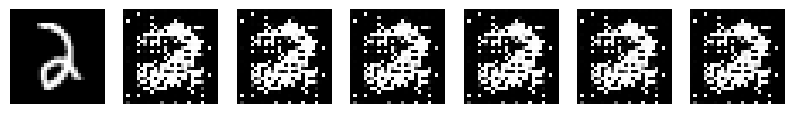

Epoch 4941 g_loss= 5.0399313 d_loss= 0.0065999753 real_acc= 1.0 fake_acc= 1.0
Epoch 4942 g_loss= 5.028142 d_loss= 0.0066865594 real_acc= 1.0 fake_acc= 1.0
Epoch 4943 g_loss= 5.048803 d_loss= 0.0065814517 real_acc= 1.0 fake_acc= 1.0
Epoch 4944 g_loss= 5.0676804 d_loss= 0.0064047994 real_acc= 1.0 fake_acc= 1.0
Epoch 4945 g_loss= 5.044272 d_loss= 0.006609018 real_acc= 1.0 fake_acc= 1.0
Epoch 4946 g_loss= 5.096441 d_loss= 0.006229339 real_acc= 1.0 fake_acc= 1.0
Epoch 4947 g_loss= 5.0956535 d_loss= 0.006219311 real_acc= 1.0 fake_acc= 1.0
Epoch 4948 g_loss= 5.0346847 d_loss= 0.006644766 real_acc= 1.0 fake_acc= 1.0
Epoch 4949 g_loss= 5.064177 d_loss= 0.006508374 real_acc= 1.0 fake_acc= 1.0
Epoch 4950 g_loss= 5.0720963 d_loss= 0.006390673 real_acc= 1.0 fake_acc= 1.0


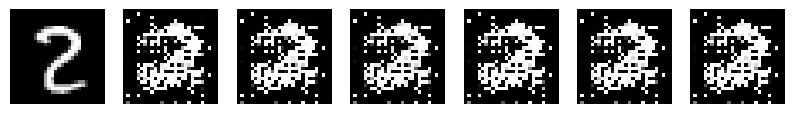

Epoch 4951 g_loss= 5.092864 d_loss= 0.006284496 real_acc= 1.0 fake_acc= 1.0
Epoch 4952 g_loss= 5.084646 d_loss= 0.0063033886 real_acc= 1.0 fake_acc= 1.0
Epoch 4953 g_loss= 5.106851 d_loss= 0.0061589135 real_acc= 1.0 fake_acc= 1.0
Epoch 4954 g_loss= 5.1112947 d_loss= 0.0061110067 real_acc= 1.0 fake_acc= 1.0
Epoch 4955 g_loss= 5.1101093 d_loss= 0.0061903615 real_acc= 1.0 fake_acc= 1.0
Epoch 4956 g_loss= 5.1331224 d_loss= 0.0060858917 real_acc= 1.0 fake_acc= 1.0
Epoch 4957 g_loss= 5.1200104 d_loss= 0.00610778 real_acc= 1.0 fake_acc= 1.0
Epoch 4958 g_loss= 5.1744146 d_loss= 0.005766553 real_acc= 1.0 fake_acc= 1.0
Epoch 4959 g_loss= 5.118505 d_loss= 0.0061185663 real_acc= 1.0 fake_acc= 1.0
Epoch 4960 g_loss= 5.079451 d_loss= 0.006355879 real_acc= 1.0 fake_acc= 1.0


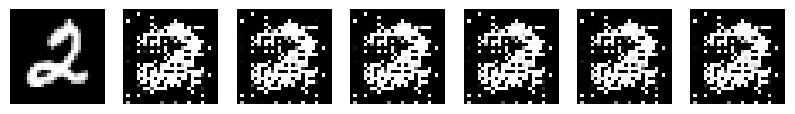

Epoch 4961 g_loss= 5.1920714 d_loss= 0.005697669 real_acc= 1.0 fake_acc= 1.0
Epoch 4962 g_loss= 5.155454 d_loss= 0.0058962284 real_acc= 1.0 fake_acc= 1.0
Epoch 4963 g_loss= 5.169621 d_loss= 0.0058055897 real_acc= 1.0 fake_acc= 1.0
Epoch 4964 g_loss= 5.198075 d_loss= 0.0056308825 real_acc= 1.0 fake_acc= 1.0
Epoch 4965 g_loss= 5.146844 d_loss= 0.005910286 real_acc= 1.0 fake_acc= 1.0
Epoch 4966 g_loss= 5.1581903 d_loss= 0.0058893566 real_acc= 1.0 fake_acc= 1.0
Epoch 4967 g_loss= 5.1570864 d_loss= 0.005865869 real_acc= 1.0 fake_acc= 1.0
Epoch 4968 g_loss= 5.2003856 d_loss= 0.005648466 real_acc= 1.0 fake_acc= 1.0
Epoch 4969 g_loss= 5.1326733 d_loss= 0.006031658 real_acc= 1.0 fake_acc= 1.0
Epoch 4970 g_loss= 5.1403728 d_loss= 0.006008355 real_acc= 1.0 fake_acc= 1.0


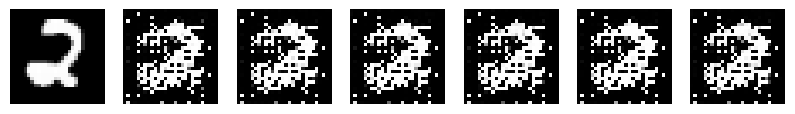

Epoch 4971 g_loss= 5.191334 d_loss= 0.005652746 real_acc= 1.0 fake_acc= 1.0
Epoch 4972 g_loss= 5.1500897 d_loss= 0.005901187 real_acc= 1.0 fake_acc= 1.0
Epoch 4973 g_loss= 5.249502 d_loss= 0.005387611 real_acc= 1.0 fake_acc= 1.0
Epoch 4974 g_loss= 5.193483 d_loss= 0.005704731 real_acc= 1.0 fake_acc= 1.0
Epoch 4975 g_loss= 5.182872 d_loss= 0.005707171 real_acc= 1.0 fake_acc= 1.0
Epoch 4976 g_loss= 5.213569 d_loss= 0.0055411714 real_acc= 1.0 fake_acc= 1.0
Epoch 4977 g_loss= 5.281271 d_loss= 0.0052077253 real_acc= 1.0 fake_acc= 1.0
Epoch 4978 g_loss= 5.247436 d_loss= 0.005344398 real_acc= 1.0 fake_acc= 1.0
Epoch 4979 g_loss= 5.2176557 d_loss= 0.0055545433 real_acc= 1.0 fake_acc= 1.0
Epoch 4980 g_loss= 5.25367 d_loss= 0.0053516184 real_acc= 1.0 fake_acc= 1.0


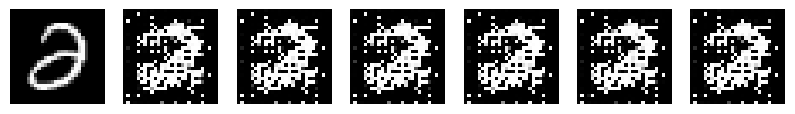

Epoch 4981 g_loss= 5.210436 d_loss= 0.0055912076 real_acc= 1.0 fake_acc= 1.0
Epoch 4982 g_loss= 5.282131 d_loss= 0.005191398 real_acc= 1.0 fake_acc= 1.0
Epoch 4983 g_loss= 5.2346797 d_loss= 0.0054169525 real_acc= 1.0 fake_acc= 1.0
Epoch 4984 g_loss= 5.2366295 d_loss= 0.0054447707 real_acc= 1.0 fake_acc= 1.0
Epoch 4985 g_loss= 5.217466 d_loss= 0.005567372 real_acc= 1.0 fake_acc= 1.0
Epoch 4986 g_loss= 5.2578664 d_loss= 0.0052992348 real_acc= 1.0 fake_acc= 1.0
Epoch 4987 g_loss= 5.31258 d_loss= 0.005060185 real_acc= 1.0 fake_acc= 1.0
Epoch 4988 g_loss= 5.2624574 d_loss= 0.0053122747 real_acc= 1.0 fake_acc= 1.0
Epoch 4989 g_loss= 5.26449 d_loss= 0.0053088404 real_acc= 1.0 fake_acc= 1.0
Epoch 4990 g_loss= 5.2493925 d_loss= 0.005357802 real_acc= 1.0 fake_acc= 1.0


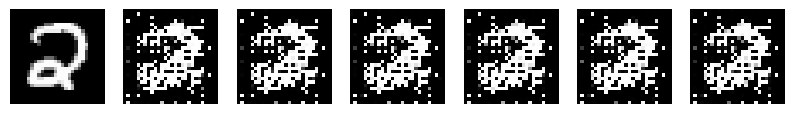

Epoch 4991 g_loss= 5.2675905 d_loss= 0.0052714455 real_acc= 1.0 fake_acc= 1.0
Epoch 4992 g_loss= 5.31257 d_loss= 0.0050580585 real_acc= 1.0 fake_acc= 1.0
Epoch 4993 g_loss= 5.246335 d_loss= 0.005361036 real_acc= 1.0 fake_acc= 1.0
Epoch 4994 g_loss= 5.284629 d_loss= 0.0051864195 real_acc= 1.0 fake_acc= 1.0
Epoch 4995 g_loss= 5.298991 d_loss= 0.0050888527 real_acc= 1.0 fake_acc= 1.0
Epoch 4996 g_loss= 5.2925177 d_loss= 0.0051217214 real_acc= 1.0 fake_acc= 1.0
Epoch 4997 g_loss= 5.2720876 d_loss= 0.0052202106 real_acc= 1.0 fake_acc= 1.0
Epoch 4998 g_loss= 5.351889 d_loss= 0.004861246 real_acc= 1.0 fake_acc= 1.0
Epoch 4999 g_loss= 5.310083 d_loss= 0.00502798 real_acc= 1.0 fake_acc= 1.0
Epoch 5000 g_loss= 5.367429 d_loss= 0.0047372133 real_acc= 1.0 fake_acc= 1.0


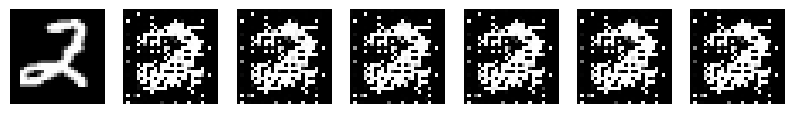

Epoch 5001 g_loss= 5.323691 d_loss= 0.0049861725 real_acc= 1.0 fake_acc= 1.0
Epoch 5002 g_loss= 5.3448076 d_loss= 0.0048710075 real_acc= 1.0 fake_acc= 1.0
Epoch 5003 g_loss= 5.3460693 d_loss= 0.004895578 real_acc= 1.0 fake_acc= 1.0
Epoch 5004 g_loss= 5.3782506 d_loss= 0.004720016 real_acc= 1.0 fake_acc= 1.0
Epoch 5005 g_loss= 5.338003 d_loss= 0.00490214 real_acc= 1.0 fake_acc= 1.0
Epoch 5006 g_loss= 5.3085637 d_loss= 0.005047851 real_acc= 1.0 fake_acc= 1.0
Epoch 5007 g_loss= 5.3528285 d_loss= 0.0048085954 real_acc= 1.0 fake_acc= 1.0
Epoch 5008 g_loss= 5.3737726 d_loss= 0.004756268 real_acc= 1.0 fake_acc= 1.0
Epoch 5009 g_loss= 5.378583 d_loss= 0.004719069 real_acc= 1.0 fake_acc= 1.0
Epoch 5010 g_loss= 5.3477645 d_loss= 0.0048555504 real_acc= 1.0 fake_acc= 1.0


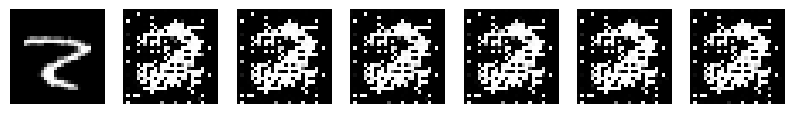

Epoch 5011 g_loss= 5.40155 d_loss= 0.0045951535 real_acc= 1.0 fake_acc= 1.0
Epoch 5012 g_loss= 5.359235 d_loss= 0.0047795232 real_acc= 1.0 fake_acc= 1.0
Epoch 5013 g_loss= 5.4172387 d_loss= 0.0045326212 real_acc= 1.0 fake_acc= 1.0
Epoch 5014 g_loss= 5.3916993 d_loss= 0.00465735 real_acc= 1.0 fake_acc= 1.0
Epoch 5015 g_loss= 5.423538 d_loss= 0.0045114933 real_acc= 1.0 fake_acc= 1.0
Epoch 5016 g_loss= 5.4057045 d_loss= 0.004566806 real_acc= 1.0 fake_acc= 1.0
Epoch 5017 g_loss= 5.4031544 d_loss= 0.0045691635 real_acc= 1.0 fake_acc= 1.0
Epoch 5018 g_loss= 5.4031353 d_loss= 0.004604966 real_acc= 1.0 fake_acc= 1.0
Epoch 5019 g_loss= 5.3936915 d_loss= 0.004673021 real_acc= 1.0 fake_acc= 1.0
Epoch 5020 g_loss= 5.4242897 d_loss= 0.0044817054 real_acc= 1.0 fake_acc= 1.0


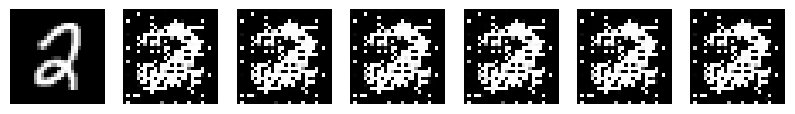

Epoch 5021 g_loss= 5.3789535 d_loss= 0.004719785 real_acc= 1.0 fake_acc= 1.0
Epoch 5022 g_loss= 5.44421 d_loss= 0.0044212528 real_acc= 1.0 fake_acc= 1.0
Epoch 5023 g_loss= 5.4086595 d_loss= 0.0045889374 real_acc= 1.0 fake_acc= 1.0
Epoch 5024 g_loss= 5.438531 d_loss= 0.0044196215 real_acc= 1.0 fake_acc= 1.0
Epoch 5025 g_loss= 5.467728 d_loss= 0.0042999424 real_acc= 1.0 fake_acc= 1.0
Epoch 5026 g_loss= 5.4682612 d_loss= 0.004316014 real_acc= 1.0 fake_acc= 1.0
Epoch 5027 g_loss= 5.4717727 d_loss= 0.0042881095 real_acc= 1.0 fake_acc= 1.0
Epoch 5028 g_loss= 5.487362 d_loss= 0.0042497125 real_acc= 1.0 fake_acc= 1.0
Epoch 5029 g_loss= 5.489361 d_loss= 0.0042073415 real_acc= 1.0 fake_acc= 1.0
Epoch 5030 g_loss= 5.506234 d_loss= 0.0041469247 real_acc= 1.0 fake_acc= 1.0


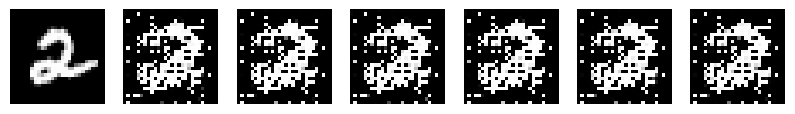

Epoch 5031 g_loss= 5.439812 d_loss= 0.0044140257 real_acc= 1.0 fake_acc= 1.0
Epoch 5032 g_loss= 5.468266 d_loss= 0.004289951 real_acc= 1.0 fake_acc= 1.0
Epoch 5033 g_loss= 5.4967046 d_loss= 0.004185066 real_acc= 1.0 fake_acc= 1.0
Epoch 5034 g_loss= 5.5135274 d_loss= 0.0041342424 real_acc= 1.0 fake_acc= 1.0
Epoch 5035 g_loss= 5.4744997 d_loss= 0.004301049 real_acc= 1.0 fake_acc= 1.0
Epoch 5036 g_loss= 5.5050073 d_loss= 0.004165715 real_acc= 1.0 fake_acc= 1.0
Epoch 5037 g_loss= 5.486421 d_loss= 0.0042173243 real_acc= 1.0 fake_acc= 1.0
Epoch 5038 g_loss= 5.5078673 d_loss= 0.0041377475 real_acc= 1.0 fake_acc= 1.0
Epoch 5039 g_loss= 5.4949837 d_loss= 0.0042266054 real_acc= 1.0 fake_acc= 1.0
Epoch 5040 g_loss= 5.497587 d_loss= 0.0041929684 real_acc= 1.0 fake_acc= 1.0


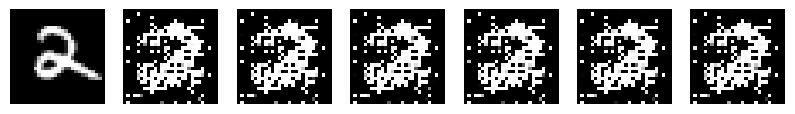

Epoch 5041 g_loss= 5.555884 d_loss= 0.00395069 real_acc= 1.0 fake_acc= 1.0
Epoch 5042 g_loss= 5.528272 d_loss= 0.0040523023 real_acc= 1.0 fake_acc= 1.0
Epoch 5043 g_loss= 5.5527544 d_loss= 0.003952874 real_acc= 1.0 fake_acc= 1.0
Epoch 5044 g_loss= 5.5494814 d_loss= 0.003959215 real_acc= 1.0 fake_acc= 1.0
Epoch 5045 g_loss= 5.5434575 d_loss= 0.0039944076 real_acc= 1.0 fake_acc= 1.0
Epoch 5046 g_loss= 5.5769844 d_loss= 0.0038532496 real_acc= 1.0 fake_acc= 1.0
Epoch 5047 g_loss= 5.5860834 d_loss= 0.0038194812 real_acc= 1.0 fake_acc= 1.0
Epoch 5048 g_loss= 5.5722246 d_loss= 0.0039174934 real_acc= 1.0 fake_acc= 1.0
Epoch 5049 g_loss= 5.533796 d_loss= 0.0040394333 real_acc= 1.0 fake_acc= 1.0
Epoch 5050 g_loss= 5.606781 d_loss= 0.0037732543 real_acc= 1.0 fake_acc= 1.0


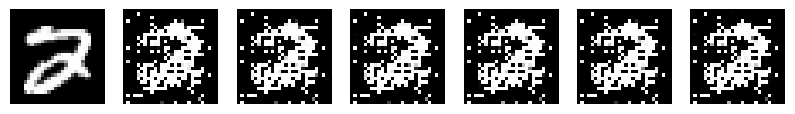

Epoch 5051 g_loss= 5.591611 d_loss= 0.0038165376 real_acc= 1.0 fake_acc= 1.0
Epoch 5052 g_loss= 5.596383 d_loss= 0.0037949828 real_acc= 1.0 fake_acc= 1.0
Epoch 5053 g_loss= 5.5478516 d_loss= 0.0039886325 real_acc= 1.0 fake_acc= 1.0
Epoch 5054 g_loss= 5.5918093 d_loss= 0.0038169292 real_acc= 1.0 fake_acc= 1.0
Epoch 5055 g_loss= 5.587392 d_loss= 0.0038343284 real_acc= 1.0 fake_acc= 1.0
Epoch 5056 g_loss= 5.5831623 d_loss= 0.0038373426 real_acc= 1.0 fake_acc= 1.0
Epoch 5057 g_loss= 5.574119 d_loss= 0.0038715005 real_acc= 1.0 fake_acc= 1.0
Epoch 5058 g_loss= 5.5609875 d_loss= 0.0039360006 real_acc= 1.0 fake_acc= 1.0
Epoch 5059 g_loss= 5.529096 d_loss= 0.004054177 real_acc= 1.0 fake_acc= 1.0
Epoch 5060 g_loss= 5.5704026 d_loss= 0.003912268 real_acc= 1.0 fake_acc= 1.0


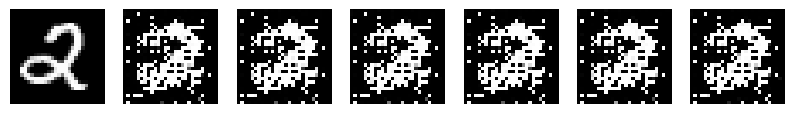

Epoch 5061 g_loss= 5.5588837 d_loss= 0.0039408556 real_acc= 1.0 fake_acc= 1.0
Epoch 5062 g_loss= 5.5901117 d_loss= 0.0037861394 real_acc= 1.0 fake_acc= 1.0
Epoch 5063 g_loss= 5.599341 d_loss= 0.0038202412 real_acc= 1.0 fake_acc= 1.0
Epoch 5064 g_loss= 5.596712 d_loss= 0.0038170356 real_acc= 1.0 fake_acc= 1.0
Epoch 5065 g_loss= 5.6200924 d_loss= 0.0037293208 real_acc= 1.0 fake_acc= 1.0
Epoch 5066 g_loss= 5.6743493 d_loss= 0.0035074407 real_acc= 1.0 fake_acc= 1.0
Epoch 5067 g_loss= 5.656802 d_loss= 0.0035681934 real_acc= 1.0 fake_acc= 1.0
Epoch 5068 g_loss= 5.633318 d_loss= 0.0036999136 real_acc= 1.0 fake_acc= 1.0
Epoch 5069 g_loss= 5.6723676 d_loss= 0.0035173274 real_acc= 1.0 fake_acc= 1.0
Epoch 5070 g_loss= 5.62735 d_loss= 0.0036734333 real_acc= 1.0 fake_acc= 1.0


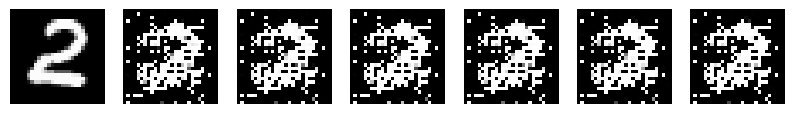

Epoch 5071 g_loss= 5.670547 d_loss= 0.003549431 real_acc= 1.0 fake_acc= 1.0
Epoch 5072 g_loss= 5.6885924 d_loss= 0.0034332054 real_acc= 1.0 fake_acc= 1.0
Epoch 5073 g_loss= 5.6375237 d_loss= 0.0036428284 real_acc= 1.0 fake_acc= 1.0
Epoch 5074 g_loss= 5.6869984 d_loss= 0.0034553013 real_acc= 1.0 fake_acc= 1.0
Epoch 5075 g_loss= 5.637842 d_loss= 0.0036255175 real_acc= 1.0 fake_acc= 1.0
Epoch 5076 g_loss= 5.6671934 d_loss= 0.0035346253 real_acc= 1.0 fake_acc= 1.0
Epoch 5077 g_loss= 5.6971345 d_loss= 0.003425597 real_acc= 1.0 fake_acc= 1.0
Epoch 5078 g_loss= 5.6885858 d_loss= 0.0034610443 real_acc= 1.0 fake_acc= 1.0
Epoch 5079 g_loss= 5.7041345 d_loss= 0.0034193732 real_acc= 1.0 fake_acc= 1.0
Epoch 5080 g_loss= 5.7247267 d_loss= 0.003338185 real_acc= 1.0 fake_acc= 1.0


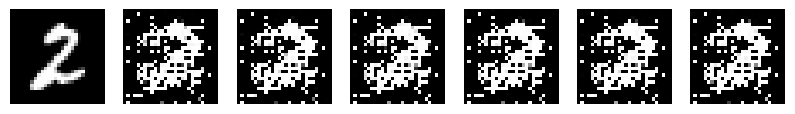

Epoch 5081 g_loss= 5.7499614 d_loss= 0.0032464222 real_acc= 1.0 fake_acc= 1.0
Epoch 5082 g_loss= 5.6361656 d_loss= 0.0036533806 real_acc= 1.0 fake_acc= 1.0
Epoch 5083 g_loss= 5.7855296 d_loss= 0.003151121 real_acc= 1.0 fake_acc= 1.0
Epoch 5084 g_loss= 5.719155 d_loss= 0.0033492714 real_acc= 1.0 fake_acc= 1.0
Epoch 5085 g_loss= 5.7230835 d_loss= 0.0033246577 real_acc= 1.0 fake_acc= 1.0
Epoch 5086 g_loss= 5.763544 d_loss= 0.0032089052 real_acc= 1.0 fake_acc= 1.0
Epoch 5087 g_loss= 5.726733 d_loss= 0.0033429868 real_acc= 1.0 fake_acc= 1.0
Epoch 5088 g_loss= 5.690492 d_loss= 0.00343939 real_acc= 1.0 fake_acc= 1.0
Epoch 5089 g_loss= 5.7312226 d_loss= 0.0033011362 real_acc= 1.0 fake_acc= 1.0
Epoch 5090 g_loss= 5.708895 d_loss= 0.0034026045 real_acc= 1.0 fake_acc= 1.0


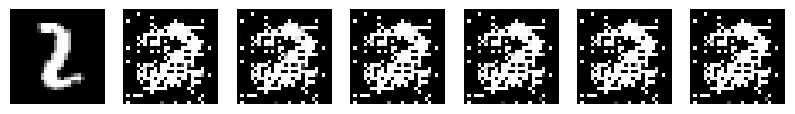

Epoch 5091 g_loss= 5.7201824 d_loss= 0.0033369244 real_acc= 1.0 fake_acc= 1.0
Epoch 5092 g_loss= 5.7580104 d_loss= 0.0032462305 real_acc= 1.0 fake_acc= 1.0
Epoch 5093 g_loss= 5.7692595 d_loss= 0.0031791357 real_acc= 1.0 fake_acc= 1.0
Epoch 5094 g_loss= 5.767691 d_loss= 0.0031953794 real_acc= 1.0 fake_acc= 1.0
Epoch 5095 g_loss= 5.754833 d_loss= 0.0032394952 real_acc= 1.0 fake_acc= 1.0
Epoch 5096 g_loss= 5.7961383 d_loss= 0.003112645 real_acc= 1.0 fake_acc= 1.0
Epoch 5097 g_loss= 5.7946625 d_loss= 0.00309203 real_acc= 1.0 fake_acc= 1.0
Epoch 5098 g_loss= 5.7860174 d_loss= 0.0031299782 real_acc= 1.0 fake_acc= 1.0
Epoch 5099 g_loss= 5.7963324 d_loss= 0.0030840272 real_acc= 1.0 fake_acc= 1.0
Epoch 5100 g_loss= 5.8690004 d_loss= 0.0029022456 real_acc= 1.0 fake_acc= 1.0


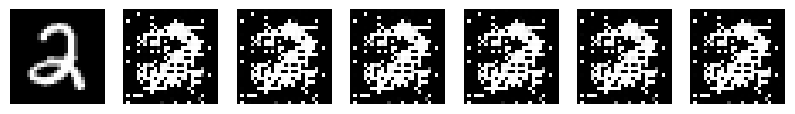

Epoch 5101 g_loss= 5.7419996 d_loss= 0.00329847 real_acc= 1.0 fake_acc= 1.0
Epoch 5102 g_loss= 5.806192 d_loss= 0.003071096 real_acc= 1.0 fake_acc= 1.0
Epoch 5103 g_loss= 5.8097935 d_loss= 0.0030704094 real_acc= 1.0 fake_acc= 1.0
Epoch 5104 g_loss= 5.833852 d_loss= 0.0030299125 real_acc= 1.0 fake_acc= 1.0
Epoch 5105 g_loss= 5.795186 d_loss= 0.0031153238 real_acc= 1.0 fake_acc= 1.0
Epoch 5106 g_loss= 5.7939644 d_loss= 0.003115309 real_acc= 1.0 fake_acc= 1.0
Epoch 5107 g_loss= 5.7804217 d_loss= 0.0031667892 real_acc= 1.0 fake_acc= 1.0
Epoch 5108 g_loss= 5.774179 d_loss= 0.0031590522 real_acc= 1.0 fake_acc= 1.0
Epoch 5109 g_loss= 5.848046 d_loss= 0.0029618551 real_acc= 1.0 fake_acc= 1.0
Epoch 5110 g_loss= 5.8573775 d_loss= 0.0029094473 real_acc= 1.0 fake_acc= 1.0


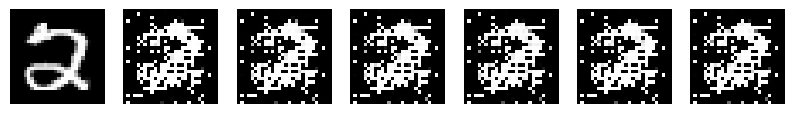

Epoch 5111 g_loss= 5.855842 d_loss= 0.0029281583 real_acc= 1.0 fake_acc= 1.0
Epoch 5112 g_loss= 5.780261 d_loss= 0.0031562545 real_acc= 1.0 fake_acc= 1.0
Epoch 5113 g_loss= 5.8532495 d_loss= 0.0029289022 real_acc= 1.0 fake_acc= 1.0
Epoch 5114 g_loss= 5.773265 d_loss= 0.0031797588 real_acc= 1.0 fake_acc= 1.0
Epoch 5115 g_loss= 5.8541193 d_loss= 0.002937847 real_acc= 1.0 fake_acc= 1.0
Epoch 5116 g_loss= 5.854986 d_loss= 0.002915246 real_acc= 1.0 fake_acc= 1.0
Epoch 5117 g_loss= 5.8240952 d_loss= 0.0030003027 real_acc= 1.0 fake_acc= 1.0
Epoch 5118 g_loss= 5.878588 d_loss= 0.002883318 real_acc= 1.0 fake_acc= 1.0
Epoch 5119 g_loss= 5.8300714 d_loss= 0.0030031723 real_acc= 1.0 fake_acc= 1.0
Epoch 5120 g_loss= 5.8921905 d_loss= 0.0028138533 real_acc= 1.0 fake_acc= 1.0


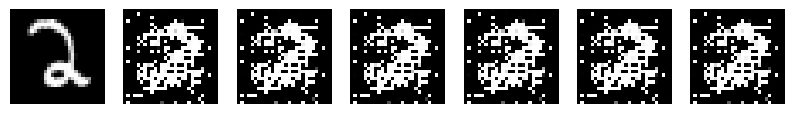

Epoch 5121 g_loss= 5.8646593 d_loss= 0.002881407 real_acc= 1.0 fake_acc= 1.0
Epoch 5122 g_loss= 5.863041 d_loss= 0.002904751 real_acc= 1.0 fake_acc= 1.0
Epoch 5123 g_loss= 5.8710613 d_loss= 0.0028736503 real_acc= 1.0 fake_acc= 1.0
Epoch 5124 g_loss= 5.9060497 d_loss= 0.0027814512 real_acc= 1.0 fake_acc= 1.0
Epoch 5125 g_loss= 5.8504515 d_loss= 0.0029593809 real_acc= 1.0 fake_acc= 1.0
Epoch 5126 g_loss= 5.8499575 d_loss= 0.002939932 real_acc= 1.0 fake_acc= 1.0
Epoch 5127 g_loss= 5.9053407 d_loss= 0.0027951405 real_acc= 1.0 fake_acc= 1.0
Epoch 5128 g_loss= 5.907772 d_loss= 0.0027840794 real_acc= 1.0 fake_acc= 1.0
Epoch 5129 g_loss= 5.8994093 d_loss= 0.002801791 real_acc= 1.0 fake_acc= 1.0
Epoch 5130 g_loss= 5.8723793 d_loss= 0.0028906155 real_acc= 1.0 fake_acc= 1.0


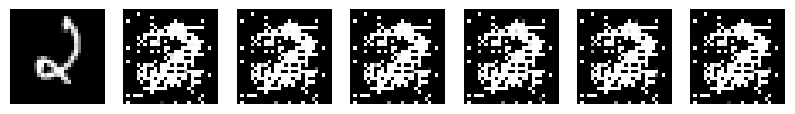

Epoch 5131 g_loss= 5.917577 d_loss= 0.002764474 real_acc= 1.0 fake_acc= 1.0
Epoch 5132 g_loss= 5.857114 d_loss= 0.0029487135 real_acc= 1.0 fake_acc= 1.0
Epoch 5133 g_loss= 5.935203 d_loss= 0.0026813028 real_acc= 1.0 fake_acc= 1.0
Epoch 5134 g_loss= 5.959351 d_loss= 0.002619703 real_acc= 1.0 fake_acc= 1.0
Epoch 5135 g_loss= 5.902487 d_loss= 0.0028267023 real_acc= 1.0 fake_acc= 1.0
Epoch 5136 g_loss= 5.865039 d_loss= 0.00290086 real_acc= 1.0 fake_acc= 1.0
Epoch 5137 g_loss= 5.9482536 d_loss= 0.0026752218 real_acc= 1.0 fake_acc= 1.0
Epoch 5138 g_loss= 5.846665 d_loss= 0.0029618314 real_acc= 1.0 fake_acc= 1.0
Epoch 5139 g_loss= 5.8480797 d_loss= 0.002985204 real_acc= 1.0 fake_acc= 1.0
Epoch 5140 g_loss= 6.0043535 d_loss= 0.002519008 real_acc= 1.0 fake_acc= 1.0


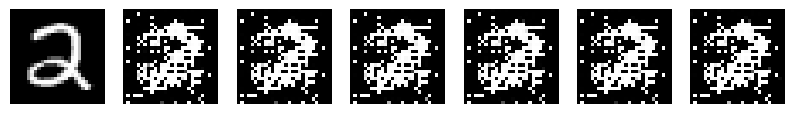

Epoch 5141 g_loss= 5.922879 d_loss= 0.0027595155 real_acc= 1.0 fake_acc= 1.0
Epoch 5142 g_loss= 5.948486 d_loss= 0.0026505508 real_acc= 1.0 fake_acc= 1.0
Epoch 5143 g_loss= 5.9417267 d_loss= 0.0026750853 real_acc= 1.0 fake_acc= 1.0
Epoch 5144 g_loss= 5.9290547 d_loss= 0.0027295125 real_acc= 1.0 fake_acc= 1.0
Epoch 5145 g_loss= 5.909184 d_loss= 0.0027739992 real_acc= 1.0 fake_acc= 1.0
Epoch 5146 g_loss= 5.988591 d_loss= 0.0025533175 real_acc= 1.0 fake_acc= 1.0
Epoch 5147 g_loss= 5.939259 d_loss= 0.0026796996 real_acc= 1.0 fake_acc= 1.0
Epoch 5148 g_loss= 5.941886 d_loss= 0.002677584 real_acc= 1.0 fake_acc= 1.0
Epoch 5149 g_loss= 5.9673977 d_loss= 0.0026186053 real_acc= 1.0 fake_acc= 1.0
Epoch 5150 g_loss= 5.9609294 d_loss= 0.0026429263 real_acc= 1.0 fake_acc= 1.0


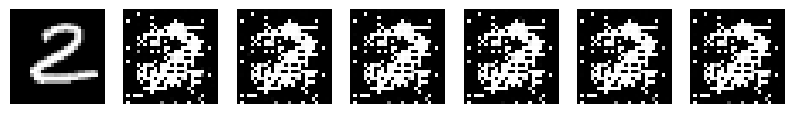

Epoch 5151 g_loss= 5.945055 d_loss= 0.002674177 real_acc= 1.0 fake_acc= 1.0
Epoch 5152 g_loss= 5.966483 d_loss= 0.0026426795 real_acc= 1.0 fake_acc= 1.0
Epoch 5153 g_loss= 6.028287 d_loss= 0.002466231 real_acc= 1.0 fake_acc= 1.0
Epoch 5154 g_loss= 5.9595537 d_loss= 0.002624054 real_acc= 1.0 fake_acc= 1.0
Epoch 5155 g_loss= 5.969898 d_loss= 0.002628926 real_acc= 1.0 fake_acc= 1.0
Epoch 5156 g_loss= 6.014897 d_loss= 0.0024877978 real_acc= 1.0 fake_acc= 1.0
Epoch 5157 g_loss= 6.0007777 d_loss= 0.0025465921 real_acc= 1.0 fake_acc= 1.0
Epoch 5158 g_loss= 5.9965343 d_loss= 0.0025308637 real_acc= 1.0 fake_acc= 1.0
Epoch 5159 g_loss= 6.0064178 d_loss= 0.0025275433 real_acc= 1.0 fake_acc= 1.0
Epoch 5160 g_loss= 5.922747 d_loss= 0.0027482533 real_acc= 1.0 fake_acc= 1.0


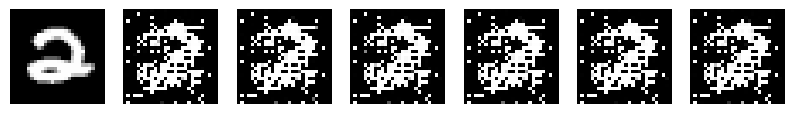

Epoch 5161 g_loss= 6.0228276 d_loss= 0.0024719692 real_acc= 1.0 fake_acc= 1.0
Epoch 5162 g_loss= 5.997531 d_loss= 0.0025389106 real_acc= 1.0 fake_acc= 1.0
Epoch 5163 g_loss= 6.020263 d_loss= 0.0024888287 real_acc= 1.0 fake_acc= 1.0
Epoch 5164 g_loss= 6.0705986 d_loss= 0.0023561048 real_acc= 1.0 fake_acc= 1.0
Epoch 5165 g_loss= 6.0410438 d_loss= 0.0024551933 real_acc= 1.0 fake_acc= 1.0
Epoch 5166 g_loss= 6.0346737 d_loss= 0.0024667268 real_acc= 1.0 fake_acc= 1.0
Epoch 5167 g_loss= 6.072243 d_loss= 0.002358592 real_acc= 1.0 fake_acc= 1.0
Epoch 5168 g_loss= 6.0289903 d_loss= 0.0024533612 real_acc= 1.0 fake_acc= 1.0
Epoch 5169 g_loss= 5.9962153 d_loss= 0.0025714242 real_acc= 1.0 fake_acc= 1.0
Epoch 5170 g_loss= 6.0313487 d_loss= 0.0024516913 real_acc= 1.0 fake_acc= 1.0


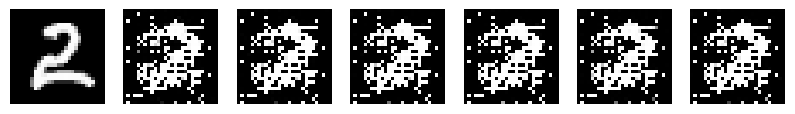

Epoch 5171 g_loss= 6.1034408 d_loss= 0.0022772502 real_acc= 1.0 fake_acc= 1.0
Epoch 5172 g_loss= 6.064159 d_loss= 0.0023842326 real_acc= 1.0 fake_acc= 1.0
Epoch 5173 g_loss= 6.0441694 d_loss= 0.002444814 real_acc= 1.0 fake_acc= 1.0
Epoch 5174 g_loss= 6.037031 d_loss= 0.0024233304 real_acc= 1.0 fake_acc= 1.0
Epoch 5175 g_loss= 5.990701 d_loss= 0.0025675022 real_acc= 1.0 fake_acc= 1.0
Epoch 5176 g_loss= 6.0706506 d_loss= 0.0025015592 real_acc= 1.0 fake_acc= 1.0
Epoch 5177 g_loss= 6.0487404 d_loss= 0.0024186596 real_acc= 1.0 fake_acc= 1.0
Epoch 5178 g_loss= 6.0624905 d_loss= 0.0023861742 real_acc= 1.0 fake_acc= 1.0
Epoch 5179 g_loss= 6.0546284 d_loss= 0.0023847853 real_acc= 1.0 fake_acc= 1.0
Epoch 5180 g_loss= 6.0919843 d_loss= 0.0023217553 real_acc= 1.0 fake_acc= 1.0


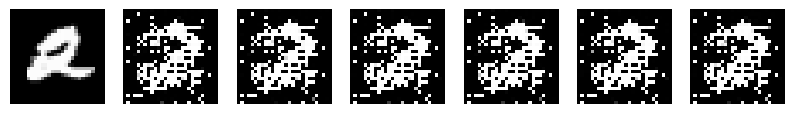

Epoch 5181 g_loss= 6.077139 d_loss= 0.0023556137 real_acc= 1.0 fake_acc= 1.0
Epoch 5182 g_loss= 6.053042 d_loss= 0.002401495 real_acc= 1.0 fake_acc= 1.0
Epoch 5183 g_loss= 6.0661736 d_loss= 0.0023783713 real_acc= 1.0 fake_acc= 1.0
Epoch 5184 g_loss= 6.07527 d_loss= 0.0023523907 real_acc= 1.0 fake_acc= 1.0
Epoch 5185 g_loss= 6.0837955 d_loss= 0.002317848 real_acc= 1.0 fake_acc= 1.0
Epoch 5186 g_loss= 6.0748706 d_loss= 0.0023374797 real_acc= 1.0 fake_acc= 1.0
Epoch 5187 g_loss= 6.0981336 d_loss= 0.0022959022 real_acc= 1.0 fake_acc= 1.0
Epoch 5188 g_loss= 6.0899415 d_loss= 0.0023141014 real_acc= 1.0 fake_acc= 1.0
Epoch 5189 g_loss= 6.123344 d_loss= 0.002246585 real_acc= 1.0 fake_acc= 1.0
Epoch 5190 g_loss= 6.1143694 d_loss= 0.0022528132 real_acc= 1.0 fake_acc= 1.0


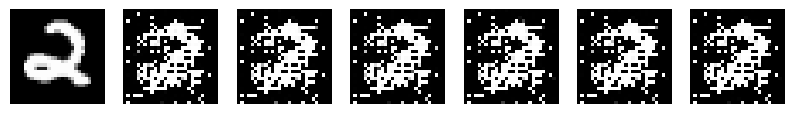

Epoch 5191 g_loss= 6.122884 d_loss= 0.002267874 real_acc= 1.0 fake_acc= 1.0
Epoch 5192 g_loss= 6.1161413 d_loss= 0.0022758397 real_acc= 1.0 fake_acc= 1.0
Epoch 5193 g_loss= 6.1137366 d_loss= 0.0022602407 real_acc= 1.0 fake_acc= 1.0
Epoch 5194 g_loss= 6.113441 d_loss= 0.0022822476 real_acc= 1.0 fake_acc= 1.0
Epoch 5195 g_loss= 6.150277 d_loss= 0.0021673033 real_acc= 1.0 fake_acc= 1.0
Epoch 5196 g_loss= 6.1504426 d_loss= 0.0021781782 real_acc= 1.0 fake_acc= 1.0
Epoch 5197 g_loss= 6.092851 d_loss= 0.0023296287 real_acc= 1.0 fake_acc= 1.0
Epoch 5198 g_loss= 6.1261706 d_loss= 0.0022299911 real_acc= 1.0 fake_acc= 1.0
Epoch 5199 g_loss= 6.1643987 d_loss= 0.0021552988 real_acc= 1.0 fake_acc= 1.0
Epoch 5200 g_loss= 6.133513 d_loss= 0.0022333763 real_acc= 1.0 fake_acc= 1.0


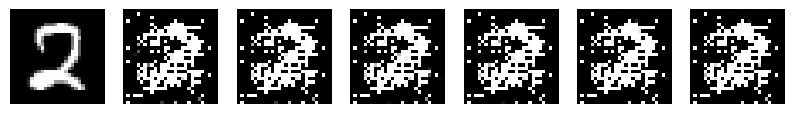

Epoch 5201 g_loss= 6.1763787 d_loss= 0.0021250532 real_acc= 1.0 fake_acc= 1.0
Epoch 5202 g_loss= 6.086439 d_loss= 0.0023252307 real_acc= 1.0 fake_acc= 1.0
Epoch 5203 g_loss= 6.1732693 d_loss= 0.0021449276 real_acc= 1.0 fake_acc= 1.0
Epoch 5204 g_loss= 6.1095486 d_loss= 0.00226825 real_acc= 1.0 fake_acc= 1.0
Epoch 5205 g_loss= 6.1766243 d_loss= 0.0021143958 real_acc= 1.0 fake_acc= 1.0
Epoch 5206 g_loss= 6.153045 d_loss= 0.0021764948 real_acc= 1.0 fake_acc= 1.0
Epoch 5207 g_loss= 6.1887374 d_loss= 0.05278034 real_acc= 0.98 fake_acc= 1.0
Epoch 5208 g_loss= 6.0839467 d_loss= 0.0023202137 real_acc= 1.0 fake_acc= 1.0
Epoch 5209 g_loss= 6.014093 d_loss= 0.0025122198 real_acc= 1.0 fake_acc= 1.0
Epoch 5210 g_loss= 6.0080395 d_loss= 0.002504547 real_acc= 1.0 fake_acc= 1.0


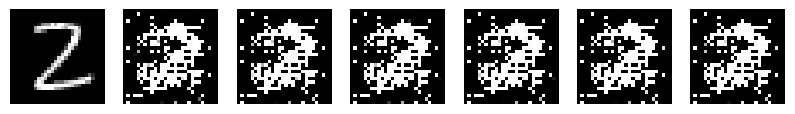

Epoch 5211 g_loss= 6.058302 d_loss= 0.0023940585 real_acc= 1.0 fake_acc= 1.0
Epoch 5212 g_loss= 5.9286346 d_loss= 0.002713201 real_acc= 1.0 fake_acc= 1.0
Epoch 5213 g_loss= 5.9496465 d_loss= 0.0026720031 real_acc= 1.0 fake_acc= 1.0
Epoch 5214 g_loss= 5.9114017 d_loss= 0.0027794223 real_acc= 1.0 fake_acc= 1.0
Epoch 5215 g_loss= 5.8633595 d_loss= 0.0029122552 real_acc= 1.0 fake_acc= 1.0
Epoch 5216 g_loss= 5.8578925 d_loss= 0.0029081912 real_acc= 1.0 fake_acc= 1.0
Epoch 5217 g_loss= 5.863258 d_loss= 0.0028857053 real_acc= 1.0 fake_acc= 1.0
Epoch 5218 g_loss= 5.842115 d_loss= 0.0029850837 real_acc= 1.0 fake_acc= 1.0
Epoch 5219 g_loss= 5.797487 d_loss= 0.0030964809 real_acc= 1.0 fake_acc= 1.0
Epoch 5220 g_loss= 5.8077087 d_loss= 0.0031115264 real_acc= 1.0 fake_acc= 1.0


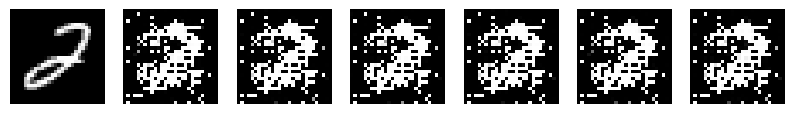

Epoch 5221 g_loss= 5.8135667 d_loss= 0.003047258 real_acc= 1.0 fake_acc= 1.0
Epoch 5222 g_loss= 5.7847466 d_loss= 0.0031475348 real_acc= 1.0 fake_acc= 1.0
Epoch 5223 g_loss= 5.747137 d_loss= 0.0032498366 real_acc= 1.0 fake_acc= 1.0
Epoch 5224 g_loss= 5.7501454 d_loss= 0.0032549321 real_acc= 1.0 fake_acc= 1.0
Epoch 5225 g_loss= 5.815027 d_loss= 0.0030506537 real_acc= 1.0 fake_acc= 1.0
Epoch 5226 g_loss= 5.777808 d_loss= 0.003174754 real_acc= 1.0 fake_acc= 1.0
Epoch 5227 g_loss= 5.74231 d_loss= 0.0032773393 real_acc= 1.0 fake_acc= 1.0
Epoch 5228 g_loss= 5.7377906 d_loss= 0.0032837777 real_acc= 1.0 fake_acc= 1.0
Epoch 5229 g_loss= 5.7658577 d_loss= 0.003204431 real_acc= 1.0 fake_acc= 1.0
Epoch 5230 g_loss= 5.7550197 d_loss= 0.003231959 real_acc= 1.0 fake_acc= 1.0


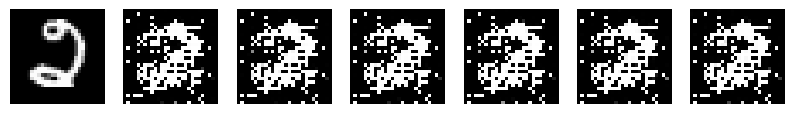

Epoch 5231 g_loss= 5.7524586 d_loss= 0.0032621291 real_acc= 1.0 fake_acc= 1.0
Epoch 5232 g_loss= 5.740806 d_loss= 0.0032781393 real_acc= 1.0 fake_acc= 1.0
Epoch 5233 g_loss= 5.741994 d_loss= 0.0032778454 real_acc= 1.0 fake_acc= 1.0
Epoch 5234 g_loss= 5.7325554 d_loss= 0.0033196502 real_acc= 1.0 fake_acc= 1.0
Epoch 5235 g_loss= 5.784816 d_loss= 0.0031429 real_acc= 1.0 fake_acc= 1.0
Epoch 5236 g_loss= 5.7551403 d_loss= 0.0032346214 real_acc= 1.0 fake_acc= 1.0
Epoch 5237 g_loss= 5.8063674 d_loss= 0.0030720762 real_acc= 1.0 fake_acc= 1.0
Epoch 5238 g_loss= 5.7225075 d_loss= 0.0033361388 real_acc= 1.0 fake_acc= 1.0
Epoch 5239 g_loss= 5.7463245 d_loss= 0.0032819044 real_acc= 1.0 fake_acc= 1.0
Epoch 5240 g_loss= 5.7575765 d_loss= 0.0032203386 real_acc= 1.0 fake_acc= 1.0


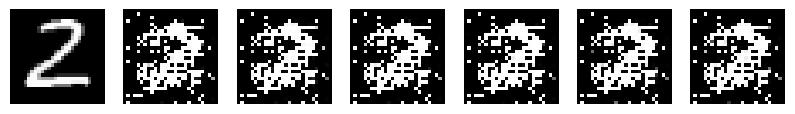

Epoch 5241 g_loss= 5.7944317 d_loss= 0.0031125823 real_acc= 1.0 fake_acc= 1.0
Epoch 5242 g_loss= 5.7220626 d_loss= 0.0033591338 real_acc= 1.0 fake_acc= 1.0
Epoch 5243 g_loss= 5.6918993 d_loss= 0.0034360108 real_acc= 1.0 fake_acc= 1.0
Epoch 5244 g_loss= 5.7799544 d_loss= 0.0031636897 real_acc= 1.0 fake_acc= 1.0
Epoch 5245 g_loss= 5.7772784 d_loss= 0.0031434852 real_acc= 1.0 fake_acc= 1.0
Epoch 5246 g_loss= 5.7446356 d_loss= 0.0032633862 real_acc= 1.0 fake_acc= 1.0
Epoch 5247 g_loss= 5.782167 d_loss= 0.003149467 real_acc= 1.0 fake_acc= 1.0
Epoch 5248 g_loss= 5.771382 d_loss= 0.003174971 real_acc= 1.0 fake_acc= 1.0
Epoch 5249 g_loss= 5.808347 d_loss= 0.0030769724 real_acc= 1.0 fake_acc= 1.0
Epoch 5250 g_loss= 5.8031025 d_loss= 0.003110896 real_acc= 1.0 fake_acc= 1.0


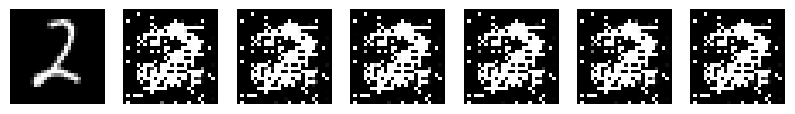

Epoch 5251 g_loss= 5.7952952 d_loss= 0.0031018322 real_acc= 1.0 fake_acc= 1.0
Epoch 5252 g_loss= 5.784174 d_loss= 0.0031480344 real_acc= 1.0 fake_acc= 1.0
Epoch 5253 g_loss= 5.796522 d_loss= 0.0031137522 real_acc= 1.0 fake_acc= 1.0
Epoch 5254 g_loss= 5.783495 d_loss= 0.0031501106 real_acc= 1.0 fake_acc= 1.0
Epoch 5255 g_loss= 5.8000593 d_loss= 0.0031049382 real_acc= 1.0 fake_acc= 1.0
Epoch 5256 g_loss= 5.748404 d_loss= 0.0032951022 real_acc= 1.0 fake_acc= 1.0
Epoch 5257 g_loss= 5.7626424 d_loss= 0.0032056163 real_acc= 1.0 fake_acc= 1.0
Epoch 5258 g_loss= 5.83529 d_loss= 0.0030135952 real_acc= 1.0 fake_acc= 1.0
Epoch 5259 g_loss= 5.8302364 d_loss= 0.002993198 real_acc= 1.0 fake_acc= 1.0
Epoch 5260 g_loss= 5.8225 d_loss= 0.003026207 real_acc= 1.0 fake_acc= 1.0


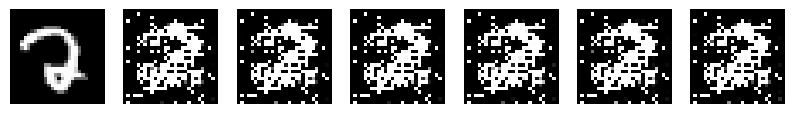

Epoch 5261 g_loss= 5.893025 d_loss= 0.0028225086 real_acc= 1.0 fake_acc= 1.0
Epoch 5262 g_loss= 5.7944207 d_loss= 0.0031247372 real_acc= 1.0 fake_acc= 1.0
Epoch 5263 g_loss= 5.8529267 d_loss= 0.002946017 real_acc= 1.0 fake_acc= 1.0
Epoch 5264 g_loss= 5.8661113 d_loss= 0.0029005602 real_acc= 1.0 fake_acc= 1.0
Epoch 5265 g_loss= 5.782584 d_loss= 0.0031770924 real_acc= 1.0 fake_acc= 1.0
Epoch 5266 g_loss= 5.865243 d_loss= 0.002892761 real_acc= 1.0 fake_acc= 1.0
Epoch 5267 g_loss= 5.841634 d_loss= 0.0029732394 real_acc= 1.0 fake_acc= 1.0
Epoch 5268 g_loss= 5.8900495 d_loss= 0.002816425 real_acc= 1.0 fake_acc= 1.0
Epoch 5269 g_loss= 5.795429 d_loss= 0.0031354623 real_acc= 1.0 fake_acc= 1.0
Epoch 5270 g_loss= 5.8602924 d_loss= 0.0029093793 real_acc= 1.0 fake_acc= 1.0


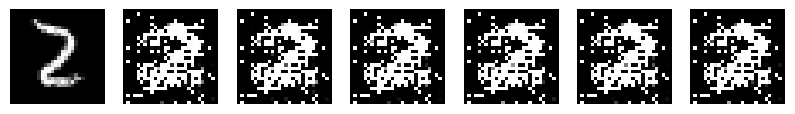

Epoch 5271 g_loss= 5.828057 d_loss= 0.0030284654 real_acc= 1.0 fake_acc= 1.0
Epoch 5272 g_loss= 5.8653355 d_loss= 0.00288965 real_acc= 1.0 fake_acc= 1.0
Epoch 5273 g_loss= 5.8696637 d_loss= 0.0028972374 real_acc= 1.0 fake_acc= 1.0
Epoch 5274 g_loss= 5.909254 d_loss= 0.0027872429 real_acc= 1.0 fake_acc= 1.0
Epoch 5275 g_loss= 5.8402667 d_loss= 0.00295705 real_acc= 1.0 fake_acc= 1.0
Epoch 5276 g_loss= 5.8949847 d_loss= 0.0028234005 real_acc= 1.0 fake_acc= 1.0
Epoch 5277 g_loss= 5.897066 d_loss= 0.0028150787 real_acc= 1.0 fake_acc= 1.0
Epoch 5278 g_loss= 5.9209995 d_loss= 0.0027542585 real_acc= 1.0 fake_acc= 1.0
Epoch 5279 g_loss= 5.883743 d_loss= 0.0028828299 real_acc= 1.0 fake_acc= 1.0
Epoch 5280 g_loss= 5.9321394 d_loss= 0.0027172458 real_acc= 1.0 fake_acc= 1.0


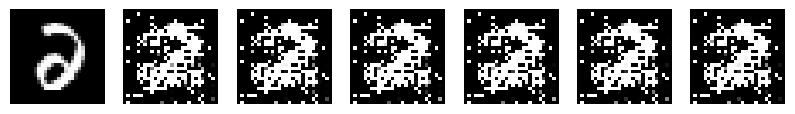

Epoch 5281 g_loss= 5.944646 d_loss= 0.0026673132 real_acc= 1.0 fake_acc= 1.0
Epoch 5282 g_loss= 5.89001 d_loss= 0.0028258266 real_acc= 1.0 fake_acc= 1.0
Epoch 5283 g_loss= 5.8547997 d_loss= 0.0029394198 real_acc= 1.0 fake_acc= 1.0
Epoch 5284 g_loss= 5.916225 d_loss= 0.0027504524 real_acc= 1.0 fake_acc= 1.0
Epoch 5285 g_loss= 5.905158 d_loss= 0.0027732989 real_acc= 1.0 fake_acc= 1.0
Epoch 5286 g_loss= 5.862727 d_loss= 0.002908385 real_acc= 1.0 fake_acc= 1.0
Epoch 5287 g_loss= 5.941968 d_loss= 0.002690464 real_acc= 1.0 fake_acc= 1.0
Epoch 5288 g_loss= 5.882111 d_loss= 0.0028705841 real_acc= 1.0 fake_acc= 1.0
Epoch 5289 g_loss= 5.953574 d_loss= 0.002676832 real_acc= 1.0 fake_acc= 1.0
Epoch 5290 g_loss= 5.9316444 d_loss= 0.0027247532 real_acc= 1.0 fake_acc= 1.0


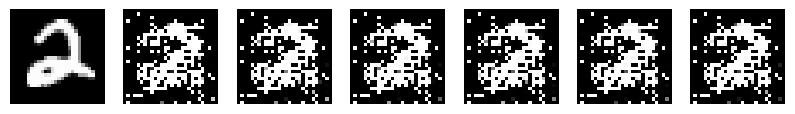

Epoch 5291 g_loss= 5.960591 d_loss= 0.0026246058 real_acc= 1.0 fake_acc= 1.0
Epoch 5292 g_loss= 5.9544277 d_loss= 0.0026513904 real_acc= 1.0 fake_acc= 1.0
Epoch 5293 g_loss= 5.913501 d_loss= 0.0027921053 real_acc= 1.0 fake_acc= 1.0
Epoch 5294 g_loss= 6.004286 d_loss= 0.0025217289 real_acc= 1.0 fake_acc= 1.0
Epoch 5295 g_loss= 5.9350867 d_loss= 0.0026970115 real_acc= 1.0 fake_acc= 1.0
Epoch 5296 g_loss= 5.954793 d_loss= 0.0026502707 real_acc= 1.0 fake_acc= 1.0
Epoch 5297 g_loss= 5.9484887 d_loss= 0.0026902915 real_acc= 1.0 fake_acc= 1.0
Epoch 5298 g_loss= 5.9080367 d_loss= 0.002783536 real_acc= 1.0 fake_acc= 1.0
Epoch 5299 g_loss= 5.998038 d_loss= 0.002547835 real_acc= 1.0 fake_acc= 1.0
Epoch 5300 g_loss= 6.0038743 d_loss= 0.0025290197 real_acc= 1.0 fake_acc= 1.0


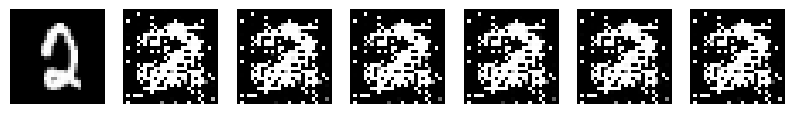

Epoch 5301 g_loss= 5.9726915 d_loss= 0.0026038566 real_acc= 1.0 fake_acc= 1.0
Epoch 5302 g_loss= 5.9727807 d_loss= 0.002586265 real_acc= 1.0 fake_acc= 1.0
Epoch 5303 g_loss= 5.9756975 d_loss= 0.0026011113 real_acc= 1.0 fake_acc= 1.0
Epoch 5304 g_loss= 5.9861174 d_loss= 0.002570386 real_acc= 1.0 fake_acc= 1.0
Epoch 5305 g_loss= 6.0074334 d_loss= 0.0025092324 real_acc= 1.0 fake_acc= 1.0
Epoch 5306 g_loss= 5.953253 d_loss= 0.0026680944 real_acc= 1.0 fake_acc= 1.0
Epoch 5307 g_loss= 6.003708 d_loss= 0.002522378 real_acc= 1.0 fake_acc= 1.0
Epoch 5308 g_loss= 5.980888 d_loss= 0.0025769288 real_acc= 1.0 fake_acc= 1.0
Epoch 5309 g_loss= 6.022931 d_loss= 0.00249137 real_acc= 1.0 fake_acc= 1.0
Epoch 5310 g_loss= 6.0038447 d_loss= 0.002514123 real_acc= 1.0 fake_acc= 1.0


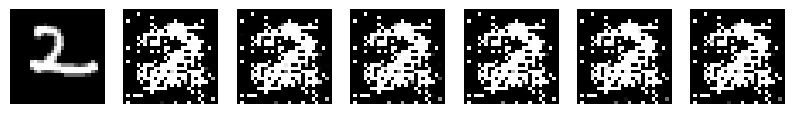

Epoch 5311 g_loss= 6.0290346 d_loss= 0.002473469 real_acc= 1.0 fake_acc= 1.0
Epoch 5312 g_loss= 6.0649366 d_loss= 0.0023757457 real_acc= 1.0 fake_acc= 1.0
Epoch 5313 g_loss= 6.0220113 d_loss= 0.00249072 real_acc= 1.0 fake_acc= 1.0
Epoch 5314 g_loss= 6.0677853 d_loss= 0.0023816894 real_acc= 1.0 fake_acc= 1.0
Epoch 5315 g_loss= 6.0432854 d_loss= 0.002431574 real_acc= 1.0 fake_acc= 1.0
Epoch 5316 g_loss= 6.033121 d_loss= 0.0024512846 real_acc= 1.0 fake_acc= 1.0
Epoch 5317 g_loss= 6.0427065 d_loss= 0.0024382276 real_acc= 1.0 fake_acc= 1.0
Epoch 5318 g_loss= 6.0510774 d_loss= 0.0024115448 real_acc= 1.0 fake_acc= 1.0
Epoch 5319 g_loss= 5.9964724 d_loss= 0.0025721476 real_acc= 1.0 fake_acc= 1.0
Epoch 5320 g_loss= 6.013587 d_loss= 0.0025024891 real_acc= 1.0 fake_acc= 1.0


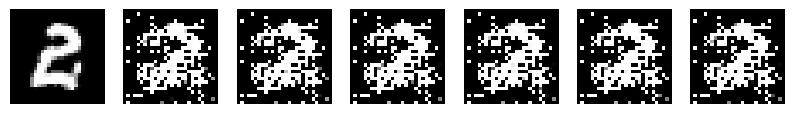

Epoch 5321 g_loss= 6.0230937 d_loss= 0.0024769595 real_acc= 1.0 fake_acc= 1.0
Epoch 5322 g_loss= 6.050609 d_loss= 0.0024253086 real_acc= 1.0 fake_acc= 1.0
Epoch 5323 g_loss= 6.0931563 d_loss= 0.0023107983 real_acc= 1.0 fake_acc= 1.0
Epoch 5324 g_loss= 6.056491 d_loss= 0.0024194168 real_acc= 1.0 fake_acc= 1.0
Epoch 5325 g_loss= 6.0889196 d_loss= 0.0023283274 real_acc= 1.0 fake_acc= 1.0
Epoch 5326 g_loss= 6.017201 d_loss= 0.0024910327 real_acc= 1.0 fake_acc= 1.0
Epoch 5327 g_loss= 6.097761 d_loss= 0.0022968992 real_acc= 1.0 fake_acc= 1.0
Epoch 5328 g_loss= 6.0727277 d_loss= 0.0023471904 real_acc= 1.0 fake_acc= 1.0
Epoch 5329 g_loss= 6.080939 d_loss= 0.0023245 real_acc= 1.0 fake_acc= 1.0
Epoch 5330 g_loss= 6.1356444 d_loss= 0.0022211082 real_acc= 1.0 fake_acc= 1.0


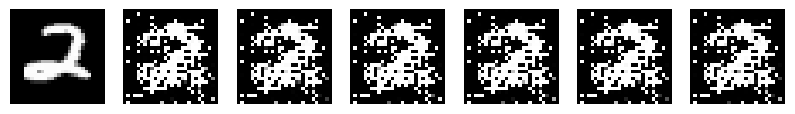

Epoch 5331 g_loss= 6.1114283 d_loss= 0.002275861 real_acc= 1.0 fake_acc= 1.0
Epoch 5332 g_loss= 6.0803328 d_loss= 0.0023406227 real_acc= 1.0 fake_acc= 1.0
Epoch 5333 g_loss= 6.150421 d_loss= 0.0021713653 real_acc= 1.0 fake_acc= 1.0
Epoch 5334 g_loss= 6.122971 d_loss= 0.0022499345 real_acc= 1.0 fake_acc= 1.0
Epoch 5335 g_loss= 6.110482 d_loss= 0.0022805368 real_acc= 1.0 fake_acc= 1.0
Epoch 5336 g_loss= 6.056067 d_loss= 0.0024073222 real_acc= 1.0 fake_acc= 1.0
Epoch 5337 g_loss= 6.140536 d_loss= 0.002194312 real_acc= 1.0 fake_acc= 1.0
Epoch 5338 g_loss= 6.1461086 d_loss= 0.00218479 real_acc= 1.0 fake_acc= 1.0
Epoch 5339 g_loss= 6.0601463 d_loss= 0.0023885912 real_acc= 1.0 fake_acc= 1.0
Epoch 5340 g_loss= 6.136118 d_loss= 0.0022342538 real_acc= 1.0 fake_acc= 1.0


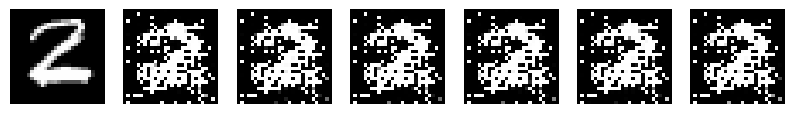

Epoch 5341 g_loss= 6.0891323 d_loss= 0.0023376895 real_acc= 1.0 fake_acc= 1.0
Epoch 5342 g_loss= 6.1197686 d_loss= 0.0022555625 real_acc= 1.0 fake_acc= 1.0
Epoch 5343 g_loss= 6.1474047 d_loss= 0.0021926537 real_acc= 1.0 fake_acc= 1.0
Epoch 5344 g_loss= 6.1503096 d_loss= 0.0021893138 real_acc= 1.0 fake_acc= 1.0
Epoch 5345 g_loss= 6.164435 d_loss= 0.00217081 real_acc= 1.0 fake_acc= 1.0
Epoch 5346 g_loss= 6.1221952 d_loss= 0.0022518265 real_acc= 1.0 fake_acc= 1.0
Epoch 5347 g_loss= 6.1612 d_loss= 0.0021894183 real_acc= 1.0 fake_acc= 1.0
Epoch 5348 g_loss= 6.123758 d_loss= 0.0022782597 real_acc= 1.0 fake_acc= 1.0
Epoch 5349 g_loss= 6.1365356 d_loss= 0.0022150248 real_acc= 1.0 fake_acc= 1.0
Epoch 5350 g_loss= 6.1766834 d_loss= 0.002119657 real_acc= 1.0 fake_acc= 1.0


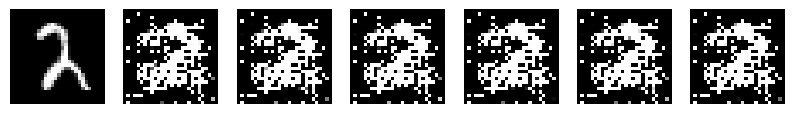

Epoch 5351 g_loss= 6.1623464 d_loss= 0.0021483374 real_acc= 1.0 fake_acc= 1.0
Epoch 5352 g_loss= 6.152095 d_loss= 0.002216315 real_acc= 1.0 fake_acc= 1.0
Epoch 5353 g_loss= 6.1602893 d_loss= 0.0021741136 real_acc= 1.0 fake_acc= 1.0
Epoch 5354 g_loss= 6.200632 d_loss= 0.0020960323 real_acc= 1.0 fake_acc= 1.0
Epoch 5355 g_loss= 6.165148 d_loss= 0.0021705066 real_acc= 1.0 fake_acc= 1.0
Epoch 5356 g_loss= 6.211541 d_loss= 0.002064625 real_acc= 1.0 fake_acc= 1.0
Epoch 5357 g_loss= 6.2089095 d_loss= 0.0020696837 real_acc= 1.0 fake_acc= 1.0
Epoch 5358 g_loss= 6.1364446 d_loss= 0.0022245124 real_acc= 1.0 fake_acc= 1.0
Epoch 5359 g_loss= 6.187832 d_loss= 0.0021016202 real_acc= 1.0 fake_acc= 1.0
Epoch 5360 g_loss= 6.1640644 d_loss= 0.0021525822 real_acc= 1.0 fake_acc= 1.0


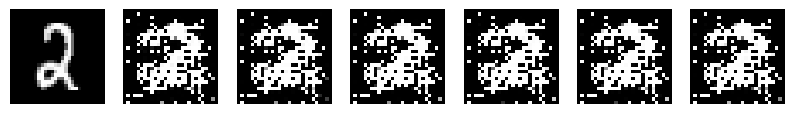

Epoch 5361 g_loss= 6.18139 d_loss= 0.0021267615 real_acc= 1.0 fake_acc= 1.0
Epoch 5362 g_loss= 6.1788683 d_loss= 0.0021281803 real_acc= 1.0 fake_acc= 1.0
Epoch 5363 g_loss= 6.190059 d_loss= 0.0021069143 real_acc= 1.0 fake_acc= 1.0
Epoch 5364 g_loss= 6.2453437 d_loss= 0.0019839043 real_acc= 1.0 fake_acc= 1.0
Epoch 5365 g_loss= 6.2056255 d_loss= 0.002083703 real_acc= 1.0 fake_acc= 1.0
Epoch 5366 g_loss= 6.1976566 d_loss= 0.0020786882 real_acc= 1.0 fake_acc= 1.0
Epoch 5367 g_loss= 6.257065 d_loss= 0.0019667547 real_acc= 1.0 fake_acc= 1.0
Epoch 5368 g_loss= 6.2454114 d_loss= 0.0019913078 real_acc= 1.0 fake_acc= 1.0
Epoch 5369 g_loss= 6.240226 d_loss= 0.002004047 real_acc= 1.0 fake_acc= 1.0
Epoch 5370 g_loss= 6.223233 d_loss= 0.0020339922 real_acc= 1.0 fake_acc= 1.0


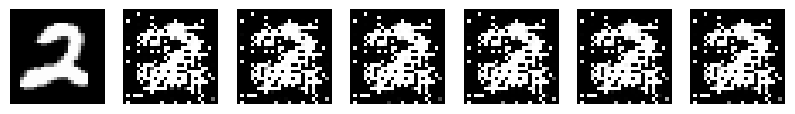

Epoch 5371 g_loss= 6.2066984 d_loss= 0.0020739937 real_acc= 1.0 fake_acc= 1.0
Epoch 5372 g_loss= 6.196876 d_loss= 0.002097619 real_acc= 1.0 fake_acc= 1.0
Epoch 5373 g_loss= 6.17901 d_loss= 0.0021260777 real_acc= 1.0 fake_acc= 1.0
Epoch 5374 g_loss= 6.270118 d_loss= 0.0019311887 real_acc= 1.0 fake_acc= 1.0
Epoch 5375 g_loss= 6.185057 d_loss= 0.0021267699 real_acc= 1.0 fake_acc= 1.0
Epoch 5376 g_loss= 6.248167 d_loss= 0.0019753128 real_acc= 1.0 fake_acc= 1.0
Epoch 5377 g_loss= 6.2574506 d_loss= 0.0019688467 real_acc= 1.0 fake_acc= 1.0
Epoch 5378 g_loss= 6.280356 d_loss= 0.0019393924 real_acc= 1.0 fake_acc= 1.0
Epoch 5379 g_loss= 6.163088 d_loss= 0.0021578376 real_acc= 1.0 fake_acc= 1.0
Epoch 5380 g_loss= 6.200295 d_loss= 0.002074174 real_acc= 1.0 fake_acc= 1.0


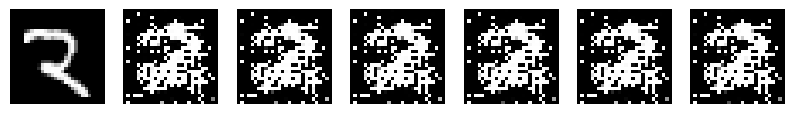

Epoch 5381 g_loss= 6.226273 d_loss= 0.0020332967 real_acc= 1.0 fake_acc= 1.0
Epoch 5382 g_loss= 6.2323065 d_loss= 0.0020425513 real_acc= 1.0 fake_acc= 1.0
Epoch 5383 g_loss= 6.2896285 d_loss= 0.0018932931 real_acc= 1.0 fake_acc= 1.0
Epoch 5384 g_loss= 6.2839117 d_loss= 0.0019123931 real_acc= 1.0 fake_acc= 1.0
Epoch 5385 g_loss= 6.313194 d_loss= 0.001854844 real_acc= 1.0 fake_acc= 1.0
Epoch 5386 g_loss= 6.2358074 d_loss= 0.0020055822 real_acc= 1.0 fake_acc= 1.0
Epoch 5387 g_loss= 6.2446027 d_loss= 0.001981444 real_acc= 1.0 fake_acc= 1.0
Epoch 5388 g_loss= 6.289839 d_loss= 0.0019112745 real_acc= 1.0 fake_acc= 1.0
Epoch 5389 g_loss= 6.32356 d_loss= 0.0018349166 real_acc= 1.0 fake_acc= 1.0
Epoch 5390 g_loss= 6.3172107 d_loss= 0.0018293579 real_acc= 1.0 fake_acc= 1.0


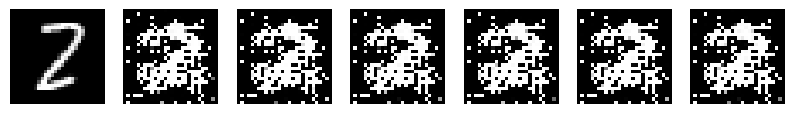

Epoch 5391 g_loss= 6.302588 d_loss= 0.0018774047 real_acc= 1.0 fake_acc= 1.0
Epoch 5392 g_loss= 6.27075 d_loss= 0.0019358832 real_acc= 1.0 fake_acc= 1.0
Epoch 5393 g_loss= 6.337394 d_loss= 0.0018087283 real_acc= 1.0 fake_acc= 1.0
Epoch 5394 g_loss= 6.2872834 d_loss= 0.001908066 real_acc= 1.0 fake_acc= 1.0
Epoch 5395 g_loss= 6.3274493 d_loss= 0.0018223046 real_acc= 1.0 fake_acc= 1.0
Epoch 5396 g_loss= 6.2841444 d_loss= 0.0019338807 real_acc= 1.0 fake_acc= 1.0
Epoch 5397 g_loss= 6.340846 d_loss= 0.0018002375 real_acc= 1.0 fake_acc= 1.0
Epoch 5398 g_loss= 6.269228 d_loss= 0.0019340961 real_acc= 1.0 fake_acc= 1.0
Epoch 5399 g_loss= 6.3528633 d_loss= 0.0017977956 real_acc= 1.0 fake_acc= 1.0
Epoch 5400 g_loss= 6.3507757 d_loss= 0.001793976 real_acc= 1.0 fake_acc= 1.0


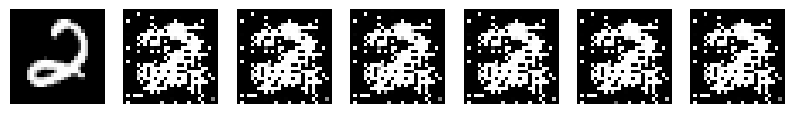

Epoch 5401 g_loss= 6.306517 d_loss= 0.0018709429 real_acc= 1.0 fake_acc= 1.0
Epoch 5402 g_loss= 6.385663 d_loss= 0.0017441034 real_acc= 1.0 fake_acc= 1.0
Epoch 5403 g_loss= 6.352593 d_loss= 0.0017836117 real_acc= 1.0 fake_acc= 1.0
Epoch 5404 g_loss= 6.3297753 d_loss= 0.0018282455 real_acc= 1.0 fake_acc= 1.0
Epoch 5405 g_loss= 6.3331547 d_loss= 0.0018264556 real_acc= 1.0 fake_acc= 1.0
Epoch 5406 g_loss= 6.392218 d_loss= 0.0017368869 real_acc= 1.0 fake_acc= 1.0
Epoch 5407 g_loss= 6.362016 d_loss= 0.0017810276 real_acc= 1.0 fake_acc= 1.0
Epoch 5408 g_loss= 6.349873 d_loss= 0.0018024185 real_acc= 1.0 fake_acc= 1.0
Epoch 5409 g_loss= 6.3579273 d_loss= 0.001775537 real_acc= 1.0 fake_acc= 1.0
Epoch 5410 g_loss= 6.3581066 d_loss= 0.0017671415 real_acc= 1.0 fake_acc= 1.0


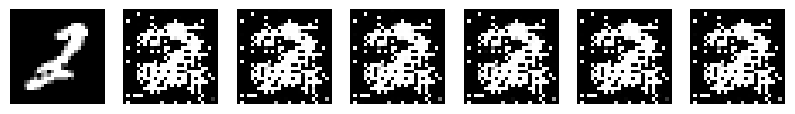

Epoch 5411 g_loss= 6.31407 d_loss= 0.0018633454 real_acc= 1.0 fake_acc= 1.0
Epoch 5412 g_loss= 6.37753 d_loss= 0.0017394392 real_acc= 1.0 fake_acc= 1.0
Epoch 5413 g_loss= 6.3375053 d_loss= 0.0018197951 real_acc= 1.0 fake_acc= 1.0
Epoch 5414 g_loss= 6.3214445 d_loss= 0.0018538074 real_acc= 1.0 fake_acc= 1.0
Epoch 5415 g_loss= 6.332221 d_loss= 0.0018128944 real_acc= 1.0 fake_acc= 1.0
Epoch 5416 g_loss= 6.3611574 d_loss= 0.0017725861 real_acc= 1.0 fake_acc= 1.0
Epoch 5417 g_loss= 6.39626 d_loss= 0.0017149256 real_acc= 1.0 fake_acc= 1.0
Epoch 5418 g_loss= 6.347548 d_loss= 0.0017868397 real_acc= 1.0 fake_acc= 1.0
Epoch 5419 g_loss= 6.4226165 d_loss= 0.0016725068 real_acc= 1.0 fake_acc= 1.0
Epoch 5420 g_loss= 6.4283485 d_loss= 0.001650673 real_acc= 1.0 fake_acc= 1.0


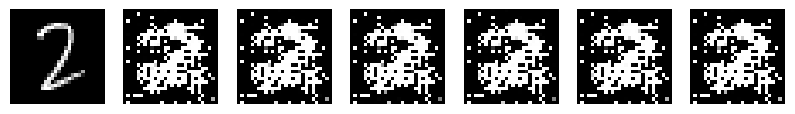

Epoch 5421 g_loss= 6.3939705 d_loss= 0.0017131065 real_acc= 1.0 fake_acc= 1.0
Epoch 5422 g_loss= 6.4082646 d_loss= 0.0016907506 real_acc= 1.0 fake_acc= 1.0
Epoch 5423 g_loss= 6.4499865 d_loss= 0.0016231749 real_acc= 1.0 fake_acc= 1.0
Epoch 5424 g_loss= 6.450232 d_loss= 0.001609188 real_acc= 1.0 fake_acc= 1.0
Epoch 5425 g_loss= 6.453476 d_loss= 0.0016280088 real_acc= 1.0 fake_acc= 1.0
Epoch 5426 g_loss= 6.4068146 d_loss= 0.0016873936 real_acc= 1.0 fake_acc= 1.0
Epoch 5427 g_loss= 6.4075923 d_loss= 0.0016872293 real_acc= 1.0 fake_acc= 1.0
Epoch 5428 g_loss= 6.4181147 d_loss= 0.0016725882 real_acc= 1.0 fake_acc= 1.0
Epoch 5429 g_loss= 6.406684 d_loss= 0.0017054852 real_acc= 1.0 fake_acc= 1.0
Epoch 5430 g_loss= 6.3796406 d_loss= 0.0017443543 real_acc= 1.0 fake_acc= 1.0


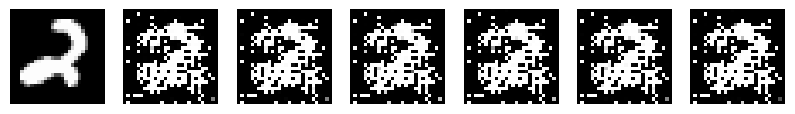

Epoch 5431 g_loss= 6.449274 d_loss= 0.001626956 real_acc= 1.0 fake_acc= 1.0
Epoch 5432 g_loss= 6.436384 d_loss= 0.0016262592 real_acc= 1.0 fake_acc= 1.0
Epoch 5433 g_loss= 6.4354234 d_loss= 0.0016489854 real_acc= 1.0 fake_acc= 1.0
Epoch 5434 g_loss= 6.4402614 d_loss= 0.0016289001 real_acc= 1.0 fake_acc= 1.0
Epoch 5435 g_loss= 6.4617305 d_loss= 0.001604553 real_acc= 1.0 fake_acc= 1.0
Epoch 5436 g_loss= 6.4399767 d_loss= 0.0016394986 real_acc= 1.0 fake_acc= 1.0
Epoch 5437 g_loss= 6.5076995 d_loss= 0.0015291099 real_acc= 1.0 fake_acc= 1.0
Epoch 5438 g_loss= 6.493082 d_loss= 0.0015459186 real_acc= 1.0 fake_acc= 1.0
Epoch 5439 g_loss= 6.440432 d_loss= 0.0016363375 real_acc= 1.0 fake_acc= 1.0
Epoch 5440 g_loss= 6.4691515 d_loss= 0.0015868382 real_acc= 1.0 fake_acc= 1.0


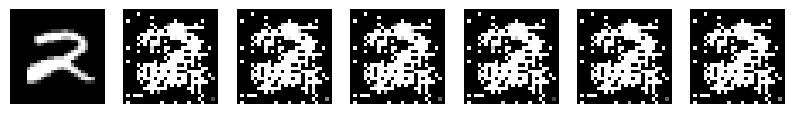

Epoch 5441 g_loss= 6.468757 d_loss= 0.0015938076 real_acc= 1.0 fake_acc= 1.0
Epoch 5442 g_loss= 6.4797335 d_loss= 0.001572436 real_acc= 1.0 fake_acc= 1.0
Epoch 5443 g_loss= 6.4803452 d_loss= 0.0015642554 real_acc= 1.0 fake_acc= 1.0
Epoch 5444 g_loss= 6.468656 d_loss= 0.0015907962 real_acc= 1.0 fake_acc= 1.0
Epoch 5445 g_loss= 6.4119964 d_loss= 0.0016701702 real_acc= 1.0 fake_acc= 1.0
Epoch 5446 g_loss= 6.49354 d_loss= 0.0015460547 real_acc= 1.0 fake_acc= 1.0
Epoch 5447 g_loss= 6.528294 d_loss= 0.0015105957 real_acc= 1.0 fake_acc= 1.0
Epoch 5448 g_loss= 6.4669538 d_loss= 0.0016017214 real_acc= 1.0 fake_acc= 1.0
Epoch 5449 g_loss= 6.4906983 d_loss= 0.0015527155 real_acc= 1.0 fake_acc= 1.0
Epoch 5450 g_loss= 6.4844723 d_loss= 0.0015673891 real_acc= 1.0 fake_acc= 1.0


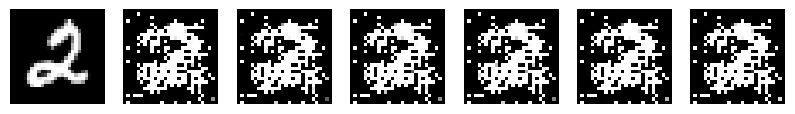

Epoch 5451 g_loss= 6.4411635 d_loss= 0.00164424 real_acc= 1.0 fake_acc= 1.0
Epoch 5452 g_loss= 6.5343294 d_loss= 0.0014983332 real_acc= 1.0 fake_acc= 1.0
Epoch 5453 g_loss= 6.523799 d_loss= 0.00150122 real_acc= 1.0 fake_acc= 1.0
Epoch 5454 g_loss= 6.434997 d_loss= 0.0016428228 real_acc= 1.0 fake_acc= 1.0
Epoch 5455 g_loss= 6.5564213 d_loss= 0.0014589161 real_acc= 1.0 fake_acc= 1.0
Epoch 5456 g_loss= 6.478327 d_loss= 0.001590904 real_acc= 1.0 fake_acc= 1.0
Epoch 5457 g_loss= 6.486428 d_loss= 0.0015660427 real_acc= 1.0 fake_acc= 1.0
Epoch 5458 g_loss= 6.482597 d_loss= 0.0015592799 real_acc= 1.0 fake_acc= 1.0
Epoch 5459 g_loss= 6.532167 d_loss= 0.0014880425 real_acc= 1.0 fake_acc= 1.0
Epoch 5460 g_loss= 6.551649 d_loss= 0.0014543729 real_acc= 1.0 fake_acc= 1.0


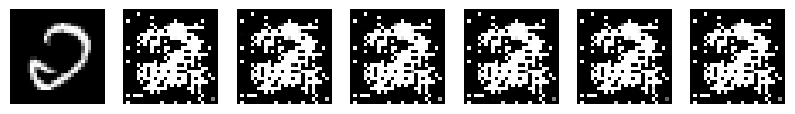

Epoch 5461 g_loss= 6.567483 d_loss= 0.0014452569 real_acc= 1.0 fake_acc= 1.0
Epoch 5462 g_loss= 6.537653 d_loss= 0.0014951214 real_acc= 1.0 fake_acc= 1.0
Epoch 5463 g_loss= 6.5461082 d_loss= 0.0014930665 real_acc= 1.0 fake_acc= 1.0
Epoch 5464 g_loss= 6.526151 d_loss= 0.0015063827 real_acc= 1.0 fake_acc= 1.0
Epoch 5465 g_loss= 6.5613313 d_loss= 0.0014426697 real_acc= 1.0 fake_acc= 1.0
Epoch 5466 g_loss= 6.6041436 d_loss= 0.0013877547 real_acc= 1.0 fake_acc= 1.0
Epoch 5467 g_loss= 6.5888286 d_loss= 0.0014195925 real_acc= 1.0 fake_acc= 1.0
Epoch 5468 g_loss= 6.5758667 d_loss= 0.0014220825 real_acc= 1.0 fake_acc= 1.0
Epoch 5469 g_loss= 6.5901403 d_loss= 0.0014073723 real_acc= 1.0 fake_acc= 1.0
Epoch 5470 g_loss= 6.628222 d_loss= 0.0013604813 real_acc= 1.0 fake_acc= 1.0


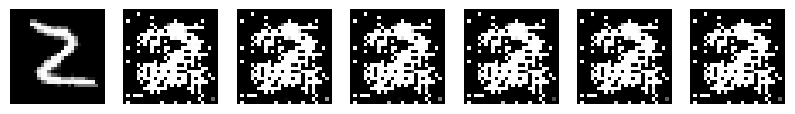

Epoch 5471 g_loss= 6.5592384 d_loss= 0.001489881 real_acc= 1.0 fake_acc= 1.0
Epoch 5472 g_loss= 6.566339 d_loss= 0.0014466228 real_acc= 1.0 fake_acc= 1.0
Epoch 5473 g_loss= 6.5205703 d_loss= 0.0015149186 real_acc= 1.0 fake_acc= 1.0
Epoch 5474 g_loss= 6.614347 d_loss= 0.0013923186 real_acc= 1.0 fake_acc= 1.0
Epoch 5475 g_loss= 6.51943 d_loss= 0.0015011078 real_acc= 1.0 fake_acc= 1.0
Epoch 5476 g_loss= 6.531595 d_loss= 0.0014977743 real_acc= 1.0 fake_acc= 1.0
Epoch 5477 g_loss= 6.6027403 d_loss= 0.0013926941 real_acc= 1.0 fake_acc= 1.0
Epoch 5478 g_loss= 6.5936646 d_loss= 0.0013955485 real_acc= 1.0 fake_acc= 1.0
Epoch 5479 g_loss= 6.505997 d_loss= 0.0015321702 real_acc= 1.0 fake_acc= 1.0
Epoch 5480 g_loss= 6.6092534 d_loss= 0.0013924186 real_acc= 1.0 fake_acc= 1.0


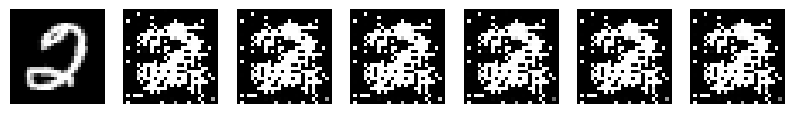

Epoch 5481 g_loss= 6.5796986 d_loss= 0.001438981 real_acc= 1.0 fake_acc= 1.0
Epoch 5482 g_loss= 6.5749965 d_loss= 0.0014364526 real_acc= 1.0 fake_acc= 1.0
Epoch 5483 g_loss= 6.609104 d_loss= 0.0013871666 real_acc= 1.0 fake_acc= 1.0
Epoch 5484 g_loss= 6.568086 d_loss= 0.0014435482 real_acc= 1.0 fake_acc= 1.0
Epoch 5485 g_loss= 6.5734487 d_loss= 0.0014218163 real_acc= 1.0 fake_acc= 1.0
Epoch 5486 g_loss= 6.6111407 d_loss= 0.0013890953 real_acc= 1.0 fake_acc= 1.0
Epoch 5487 g_loss= 6.6525702 d_loss= 0.001328391 real_acc= 1.0 fake_acc= 1.0
Epoch 5488 g_loss= 6.60447 d_loss= 0.0013955253 real_acc= 1.0 fake_acc= 1.0
Epoch 5489 g_loss= 6.6339235 d_loss= 0.0013555955 real_acc= 1.0 fake_acc= 1.0
Epoch 5490 g_loss= 6.596662 d_loss= 0.0013992633 real_acc= 1.0 fake_acc= 1.0


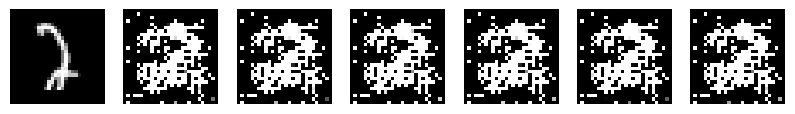

Epoch 5491 g_loss= 6.6657634 d_loss= 0.0013195229 real_acc= 1.0 fake_acc= 1.0
Epoch 5492 g_loss= 6.595481 d_loss= 0.0014030864 real_acc= 1.0 fake_acc= 1.0
Epoch 5493 g_loss= 6.619626 d_loss= 0.0013759702 real_acc= 1.0 fake_acc= 1.0
Epoch 5494 g_loss= 6.5570545 d_loss= 0.0014716404 real_acc= 1.0 fake_acc= 1.0
Epoch 5495 g_loss= 6.6122937 d_loss= 0.0013718713 real_acc= 1.0 fake_acc= 1.0
Epoch 5496 g_loss= 6.656291 d_loss= 0.0013139662 real_acc= 1.0 fake_acc= 1.0
Epoch 5497 g_loss= 6.600604 d_loss= 0.0013940088 real_acc= 1.0 fake_acc= 1.0
Epoch 5498 g_loss= 6.6411304 d_loss= 0.001341625 real_acc= 1.0 fake_acc= 1.0
Epoch 5499 g_loss= 6.630909 d_loss= 0.0013632674 real_acc= 1.0 fake_acc= 1.0
Epoch 5500 g_loss= 6.6252675 d_loss= 0.001354548 real_acc= 1.0 fake_acc= 1.0


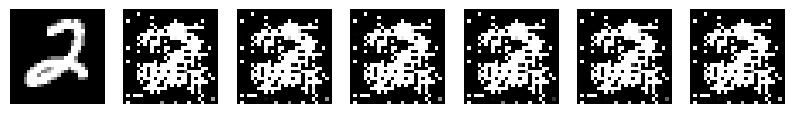

Epoch 5501 g_loss= 6.6449933 d_loss= 0.0013344529 real_acc= 1.0 fake_acc= 1.0
Epoch 5502 g_loss= 6.6389647 d_loss= 0.0013439214 real_acc= 1.0 fake_acc= 1.0
Epoch 5503 g_loss= 6.6968412 d_loss= 0.0012580927 real_acc= 1.0 fake_acc= 1.0
Epoch 5504 g_loss= 6.6452546 d_loss= 0.0013323907 real_acc= 1.0 fake_acc= 1.0
Epoch 5505 g_loss= 6.713139 d_loss= 0.0012330314 real_acc= 1.0 fake_acc= 1.0
Epoch 5506 g_loss= 6.695917 d_loss= 0.001275726 real_acc= 1.0 fake_acc= 1.0
Epoch 5507 g_loss= 6.6574125 d_loss= 0.0013135752 real_acc= 1.0 fake_acc= 1.0
Epoch 5508 g_loss= 6.6597133 d_loss= 0.0013132461 real_acc= 1.0 fake_acc= 1.0
Epoch 5509 g_loss= 6.699614 d_loss= 0.0012563722 real_acc= 1.0 fake_acc= 1.0
Epoch 5510 g_loss= 6.6801786 d_loss= 0.001292762 real_acc= 1.0 fake_acc= 1.0


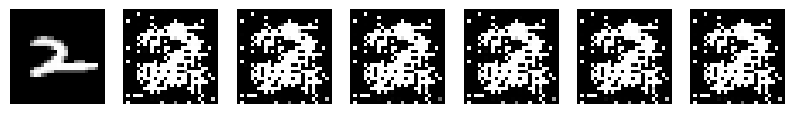

Epoch 5511 g_loss= 6.685512 d_loss= 0.0012846206 real_acc= 1.0 fake_acc= 1.0
Epoch 5512 g_loss= 6.6370254 d_loss= 0.0013424079 real_acc= 1.0 fake_acc= 1.0
Epoch 5513 g_loss= 6.7355676 d_loss= 0.0012284409 real_acc= 1.0 fake_acc= 1.0
Epoch 5514 g_loss= 6.68202 d_loss= 0.0012858935 real_acc= 1.0 fake_acc= 1.0
Epoch 5515 g_loss= 6.650711 d_loss= 0.0013265931 real_acc= 1.0 fake_acc= 1.0
Epoch 5516 g_loss= 6.71844 d_loss= 0.0012326362 real_acc= 1.0 fake_acc= 1.0
Epoch 5517 g_loss= 6.6541395 d_loss= 0.0013158877 real_acc= 1.0 fake_acc= 1.0
Epoch 5518 g_loss= 6.6783986 d_loss= 0.0012947922 real_acc= 1.0 fake_acc= 1.0
Epoch 5519 g_loss= 6.7015886 d_loss= 0.0012821102 real_acc= 1.0 fake_acc= 1.0
Epoch 5520 g_loss= 6.7186804 d_loss= 0.001231373 real_acc= 1.0 fake_acc= 1.0


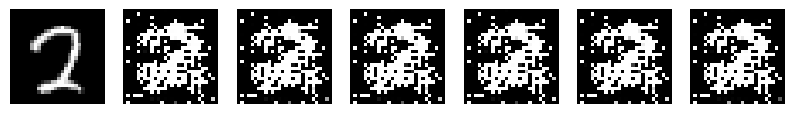

Epoch 5521 g_loss= 6.7552266 d_loss= 0.0012029065 real_acc= 1.0 fake_acc= 1.0
Epoch 5522 g_loss= 6.725354 d_loss= 0.0012339302 real_acc= 1.0 fake_acc= 1.0
Epoch 5523 g_loss= 6.6845174 d_loss= 0.0012811368 real_acc= 1.0 fake_acc= 1.0
Epoch 5524 g_loss= 6.7223706 d_loss= 0.0012494043 real_acc= 1.0 fake_acc= 1.0
Epoch 5525 g_loss= 6.724419 d_loss= 0.0012417093 real_acc= 1.0 fake_acc= 1.0
Epoch 5526 g_loss= 6.6903505 d_loss= 0.0012691722 real_acc= 1.0 fake_acc= 1.0
Epoch 5527 g_loss= 6.7084565 d_loss= 0.0012524903 real_acc= 1.0 fake_acc= 1.0
Epoch 5528 g_loss= 6.6837316 d_loss= 0.0012908595 real_acc= 1.0 fake_acc= 1.0
Epoch 5529 g_loss= 6.7461653 d_loss= 0.0011990658 real_acc= 1.0 fake_acc= 1.0
Epoch 5530 g_loss= 6.668829 d_loss= 0.0013008486 real_acc= 1.0 fake_acc= 1.0


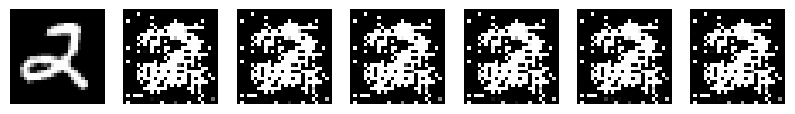

Epoch 5531 g_loss= 6.7520766 d_loss= 0.0012014582 real_acc= 1.0 fake_acc= 1.0
Epoch 5532 g_loss= 6.7575727 d_loss= 0.0012007881 real_acc= 1.0 fake_acc= 1.0
Epoch 5533 g_loss= 6.7767553 d_loss= 0.0011634441 real_acc= 1.0 fake_acc= 1.0
Epoch 5534 g_loss= 6.759352 d_loss= 0.001182794 real_acc= 1.0 fake_acc= 1.0
Epoch 5535 g_loss= 6.7827053 d_loss= 0.0011647964 real_acc= 1.0 fake_acc= 1.0
Epoch 5536 g_loss= 6.771414 d_loss= 0.0011711916 real_acc= 1.0 fake_acc= 1.0
Epoch 5537 g_loss= 6.7761097 d_loss= 0.0011794595 real_acc= 1.0 fake_acc= 1.0
Epoch 5538 g_loss= 6.6966567 d_loss= 0.0012700723 real_acc= 1.0 fake_acc= 1.0
Epoch 5539 g_loss= 6.754916 d_loss= 0.0012028266 real_acc= 1.0 fake_acc= 1.0
Epoch 5540 g_loss= 6.7475624 d_loss= 0.0012110493 real_acc= 1.0 fake_acc= 1.0


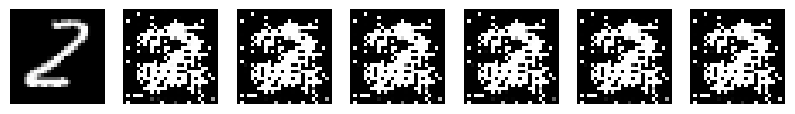

Epoch 5541 g_loss= 6.7534156 d_loss= 0.0012018443 real_acc= 1.0 fake_acc= 1.0
Epoch 5542 g_loss= 6.7769423 d_loss= 0.0011675754 real_acc= 1.0 fake_acc= 1.0
Epoch 5543 g_loss= 6.786843 d_loss= 0.00115094 real_acc= 1.0 fake_acc= 1.0
Epoch 5544 g_loss= 6.7833705 d_loss= 0.0011534357 real_acc= 1.0 fake_acc= 1.0
Epoch 5545 g_loss= 6.7830687 d_loss= 0.0011614972 real_acc= 1.0 fake_acc= 1.0
Epoch 5546 g_loss= 6.7788563 d_loss= 0.0011745621 real_acc= 1.0 fake_acc= 1.0
Epoch 5547 g_loss= 6.7579045 d_loss= 0.0011927807 real_acc= 1.0 fake_acc= 1.0
Epoch 5548 g_loss= 6.784201 d_loss= 0.001171973 real_acc= 1.0 fake_acc= 1.0
Epoch 5549 g_loss= 6.7955685 d_loss= 0.0011527593 real_acc= 1.0 fake_acc= 1.0
Epoch 5550 g_loss= 6.8043056 d_loss= 0.0011439177 real_acc= 1.0 fake_acc= 1.0


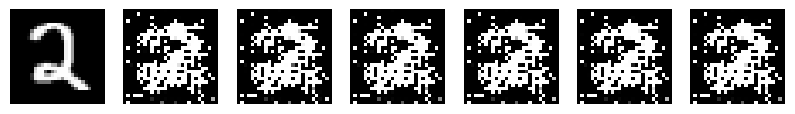

Epoch 5551 g_loss= 6.8096375 d_loss= 0.0011343427 real_acc= 1.0 fake_acc= 1.0
Epoch 5552 g_loss= 6.7820635 d_loss= 0.0011663211 real_acc= 1.0 fake_acc= 1.0
Epoch 5553 g_loss= 6.803306 d_loss= 0.0011298894 real_acc= 1.0 fake_acc= 1.0
Epoch 5554 g_loss= 6.804092 d_loss= 0.001136524 real_acc= 1.0 fake_acc= 1.0
Epoch 5555 g_loss= 6.791857 d_loss= 0.0011532463 real_acc= 1.0 fake_acc= 1.0
Epoch 5556 g_loss= 6.873718 d_loss= 0.001055418 real_acc= 1.0 fake_acc= 1.0
Epoch 5557 g_loss= 6.7601457 d_loss= 0.0011909596 real_acc= 1.0 fake_acc= 1.0
Epoch 5558 g_loss= 6.874089 d_loss= 0.0010591517 real_acc= 1.0 fake_acc= 1.0
Epoch 5559 g_loss= 6.8145947 d_loss= 0.0011270981 real_acc= 1.0 fake_acc= 1.0
Epoch 5560 g_loss= 6.860343 d_loss= 0.0010793 real_acc= 1.0 fake_acc= 1.0


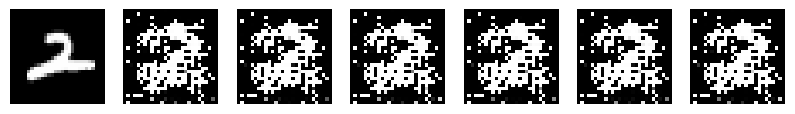

Epoch 5561 g_loss= 6.808173 d_loss= 0.0011334721 real_acc= 1.0 fake_acc= 1.0
Epoch 5562 g_loss= 6.847964 d_loss= 0.0010894544 real_acc= 1.0 fake_acc= 1.0
Epoch 5563 g_loss= 6.769616 d_loss= 0.0011835811 real_acc= 1.0 fake_acc= 1.0
Epoch 5564 g_loss= 6.8690057 d_loss= 0.0010764779 real_acc= 1.0 fake_acc= 1.0
Epoch 5565 g_loss= 6.785034 d_loss= 0.0011755461 real_acc= 1.0 fake_acc= 1.0
Epoch 5566 g_loss= 6.853049 d_loss= 0.001092094 real_acc= 1.0 fake_acc= 1.0
Epoch 5567 g_loss= 6.794878 d_loss= 0.0011532992 real_acc= 1.0 fake_acc= 1.0
Epoch 5568 g_loss= 6.921744 d_loss= 0.0010135239 real_acc= 1.0 fake_acc= 1.0
Epoch 5569 g_loss= 6.863137 d_loss= 0.0010668113 real_acc= 1.0 fake_acc= 1.0
Epoch 5570 g_loss= 6.761572 d_loss= 0.0011898007 real_acc= 1.0 fake_acc= 1.0


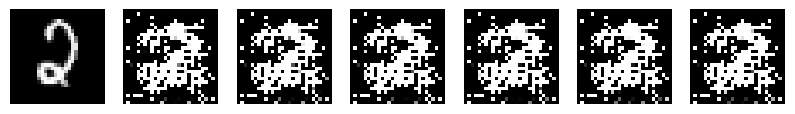

Epoch 5571 g_loss= 6.8128123 d_loss= 0.001131979 real_acc= 1.0 fake_acc= 1.0
Epoch 5572 g_loss= 6.8700604 d_loss= 0.0010609763 real_acc= 1.0 fake_acc= 1.0
Epoch 5573 g_loss= 6.8498425 d_loss= 0.001081623 real_acc= 1.0 fake_acc= 1.0
Epoch 5574 g_loss= 6.846487 d_loss= 0.0011008225 real_acc= 1.0 fake_acc= 1.0
Epoch 5575 g_loss= 6.799164 d_loss= 0.0011409932 real_acc= 1.0 fake_acc= 1.0
Epoch 5576 g_loss= 6.92693 d_loss= 0.0010069163 real_acc= 1.0 fake_acc= 1.0
Epoch 5577 g_loss= 6.8810406 d_loss= 0.0010606307 real_acc= 1.0 fake_acc= 1.0
Epoch 5578 g_loss= 6.8246517 d_loss= 0.0011098721 real_acc= 1.0 fake_acc= 1.0
Epoch 5579 g_loss= 6.8917828 d_loss= 0.0010439842 real_acc= 1.0 fake_acc= 1.0
Epoch 5580 g_loss= 6.8810062 d_loss= 0.0010542041 real_acc= 1.0 fake_acc= 1.0


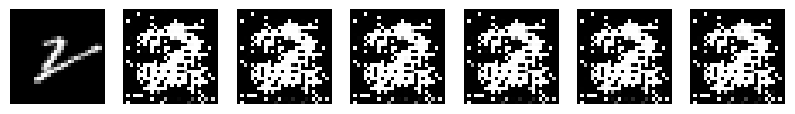

Epoch 5581 g_loss= 6.89517 d_loss= 0.0010369588 real_acc= 1.0 fake_acc= 1.0
Epoch 5582 g_loss= 6.8252845 d_loss= 0.001126489 real_acc= 1.0 fake_acc= 1.0
Epoch 5583 g_loss= 6.855561 d_loss= 0.0010813393 real_acc= 1.0 fake_acc= 1.0
Epoch 5584 g_loss= 6.8412876 d_loss= 0.0010964707 real_acc= 1.0 fake_acc= 1.0
Epoch 5585 g_loss= 6.876413 d_loss= 0.0010621283 real_acc= 1.0 fake_acc= 1.0
Epoch 5586 g_loss= 6.863675 d_loss= 0.0010790474 real_acc= 1.0 fake_acc= 1.0
Epoch 5587 g_loss= 6.906792 d_loss= 0.0010284386 real_acc= 1.0 fake_acc= 1.0
Epoch 5588 g_loss= 6.8851085 d_loss= 0.0010660213 real_acc= 1.0 fake_acc= 1.0
Epoch 5589 g_loss= 6.886465 d_loss= 0.0010551905 real_acc= 1.0 fake_acc= 1.0
Epoch 5590 g_loss= 6.874021 d_loss= 0.0010536045 real_acc= 1.0 fake_acc= 1.0


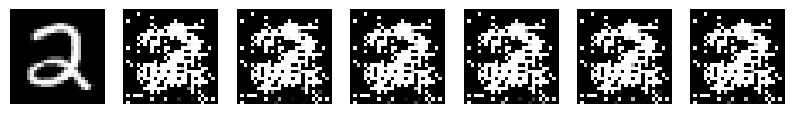

Epoch 5591 g_loss= 6.9335604 d_loss= 0.0010099646 real_acc= 1.0 fake_acc= 1.0
Epoch 5592 g_loss= 6.9307404 d_loss= 0.0010097309 real_acc= 1.0 fake_acc= 1.0
Epoch 5593 g_loss= 6.8570585 d_loss= 0.0010917131 real_acc= 1.0 fake_acc= 1.0
Epoch 5594 g_loss= 6.8858852 d_loss= 0.0010453269 real_acc= 1.0 fake_acc= 1.0
Epoch 5595 g_loss= 6.878677 d_loss= 0.0010595629 real_acc= 1.0 fake_acc= 1.0
Epoch 5596 g_loss= 6.884962 d_loss= 0.0010594557 real_acc= 1.0 fake_acc= 1.0
Epoch 5597 g_loss= 6.914208 d_loss= 0.0010380016 real_acc= 1.0 fake_acc= 1.0
Epoch 5598 g_loss= 6.9188247 d_loss= 0.0010079971 real_acc= 1.0 fake_acc= 1.0
Epoch 5599 g_loss= 6.961777 d_loss= 0.0009797607 real_acc= 1.0 fake_acc= 1.0
Epoch 5600 g_loss= 6.8886747 d_loss= 0.0010552016 real_acc= 1.0 fake_acc= 1.0


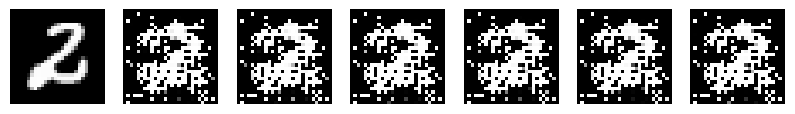

Epoch 5601 g_loss= 6.949821 d_loss= 0.0009756762 real_acc= 1.0 fake_acc= 1.0
Epoch 5602 g_loss= 6.896467 d_loss= 0.0010363136 real_acc= 1.0 fake_acc= 1.0
Epoch 5603 g_loss= 6.9588923 d_loss= 0.0009792624 real_acc= 1.0 fake_acc= 1.0
Epoch 5604 g_loss= 6.8729954 d_loss= 0.001080288 real_acc= 1.0 fake_acc= 1.0
Epoch 5605 g_loss= 6.919294 d_loss= 0.0010106148 real_acc= 1.0 fake_acc= 1.0
Epoch 5606 g_loss= 6.8928165 d_loss= 0.001043763 real_acc= 1.0 fake_acc= 1.0
Epoch 5607 g_loss= 6.9371867 d_loss= 0.0009980557 real_acc= 1.0 fake_acc= 1.0
Epoch 5608 g_loss= 6.8711333 d_loss= 0.001073165 real_acc= 1.0 fake_acc= 1.0
Epoch 5609 g_loss= 6.920959 d_loss= 0.0010205354 real_acc= 1.0 fake_acc= 1.0
Epoch 5610 g_loss= 6.9807625 d_loss= 0.00095870433 real_acc= 1.0 fake_acc= 1.0


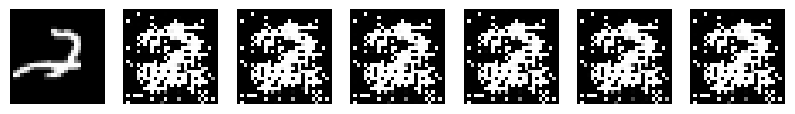

Epoch 5611 g_loss= 6.925199 d_loss= 0.0010138229 real_acc= 1.0 fake_acc= 1.0
Epoch 5612 g_loss= 6.9503894 d_loss= 0.0009825459 real_acc= 1.0 fake_acc= 1.0
Epoch 5613 g_loss= 7.015775 d_loss= 0.00092147855 real_acc= 1.0 fake_acc= 1.0
Epoch 5614 g_loss= 6.9594765 d_loss= 0.0009774427 real_acc= 1.0 fake_acc= 1.0
Epoch 5615 g_loss= 6.939811 d_loss= 0.0010023917 real_acc= 1.0 fake_acc= 1.0
Epoch 5616 g_loss= 6.939521 d_loss= 0.0009909008 real_acc= 1.0 fake_acc= 1.0
Epoch 5617 g_loss= 7.0044208 d_loss= 0.00092616834 real_acc= 1.0 fake_acc= 1.0
Epoch 5618 g_loss= 6.9480133 d_loss= 0.0009819976 real_acc= 1.0 fake_acc= 1.0
Epoch 5619 g_loss= 6.973723 d_loss= 0.00096483534 real_acc= 1.0 fake_acc= 1.0
Epoch 5620 g_loss= 6.969728 d_loss= 0.0009723427 real_acc= 1.0 fake_acc= 1.0


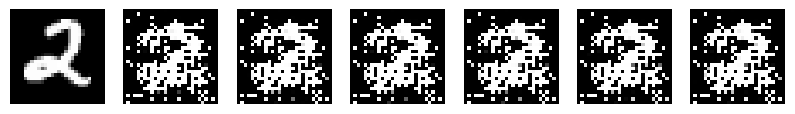

Epoch 5621 g_loss= 6.972963 d_loss= 0.0009648158 real_acc= 1.0 fake_acc= 1.0
Epoch 5622 g_loss= 6.925067 d_loss= 0.0010069725 real_acc= 1.0 fake_acc= 1.0
Epoch 5623 g_loss= 7.010179 d_loss= 0.00093843706 real_acc= 1.0 fake_acc= 1.0
Epoch 5624 g_loss= 6.960791 d_loss= 0.000988926 real_acc= 1.0 fake_acc= 1.0
Epoch 5625 g_loss= 6.9870358 d_loss= 0.0009509146 real_acc= 1.0 fake_acc= 1.0
Epoch 5626 g_loss= 7.0039787 d_loss= 0.0009421276 real_acc= 1.0 fake_acc= 1.0
Epoch 5627 g_loss= 6.928926 d_loss= 0.0010183527 real_acc= 1.0 fake_acc= 1.0
Epoch 5628 g_loss= 6.965958 d_loss= 0.0009714395 real_acc= 1.0 fake_acc= 1.0
Epoch 5629 g_loss= 6.9194117 d_loss= 0.0010260404 real_acc= 1.0 fake_acc= 1.0
Epoch 5630 g_loss= 6.963205 d_loss= 0.0009704448 real_acc= 1.0 fake_acc= 1.0


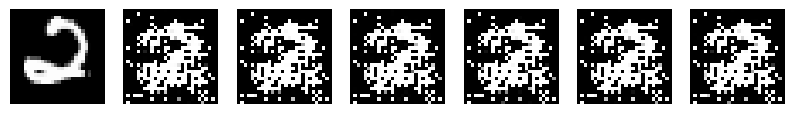

Epoch 5631 g_loss= 6.9810696 d_loss= 0.0009512825 real_acc= 1.0 fake_acc= 1.0
Epoch 5632 g_loss= 6.8982477 d_loss= 0.0010363348 real_acc= 1.0 fake_acc= 1.0
Epoch 5633 g_loss= 6.990836 d_loss= 0.0009441705 real_acc= 1.0 fake_acc= 1.0
Epoch 5634 g_loss= 7.0270367 d_loss= 0.00091530883 real_acc= 1.0 fake_acc= 1.0
Epoch 5635 g_loss= 6.9638186 d_loss= 0.0009676535 real_acc= 1.0 fake_acc= 1.0
Epoch 5636 g_loss= 6.963119 d_loss= 0.00096381997 real_acc= 1.0 fake_acc= 1.0
Epoch 5637 g_loss= 6.985559 d_loss= 0.0009430065 real_acc= 1.0 fake_acc= 1.0
Epoch 5638 g_loss= 6.934935 d_loss= 0.0010029883 real_acc= 1.0 fake_acc= 1.0
Epoch 5639 g_loss= 6.9932575 d_loss= 0.0009505362 real_acc= 1.0 fake_acc= 1.0
Epoch 5640 g_loss= 7.017445 d_loss= 0.00091933407 real_acc= 1.0 fake_acc= 1.0


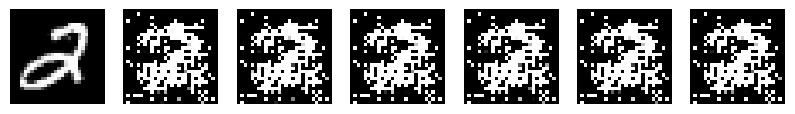

Epoch 5641 g_loss= 7.05394 d_loss= 0.00088519446 real_acc= 1.0 fake_acc= 1.0
Epoch 5642 g_loss= 7.012165 d_loss= 0.00093986955 real_acc= 1.0 fake_acc= 1.0
Epoch 5643 g_loss= 6.9777265 d_loss= 0.00095905596 real_acc= 1.0 fake_acc= 1.0
Epoch 5644 g_loss= 7.0151296 d_loss= 0.0009313586 real_acc= 1.0 fake_acc= 1.0
Epoch 5645 g_loss= 7.0026817 d_loss= 0.00093469926 real_acc= 1.0 fake_acc= 1.0
Epoch 5646 g_loss= 6.9810705 d_loss= 0.0009485077 real_acc= 1.0 fake_acc= 1.0
Epoch 5647 g_loss= 7.0170283 d_loss= 0.0009216089 real_acc= 1.0 fake_acc= 1.0
Epoch 5648 g_loss= 7.0149646 d_loss= 0.00092658994 real_acc= 1.0 fake_acc= 1.0
Epoch 5649 g_loss= 7.031191 d_loss= 0.00090682297 real_acc= 1.0 fake_acc= 1.0
Epoch 5650 g_loss= 7.003302 d_loss= 0.00094068056 real_acc= 1.0 fake_acc= 1.0


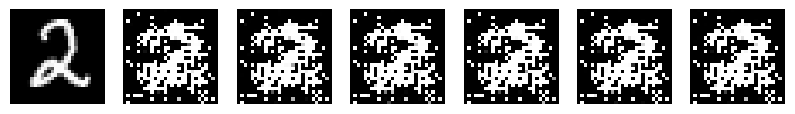

Epoch 5651 g_loss= 7.052 d_loss= 0.0008887574 real_acc= 1.0 fake_acc= 1.0
Epoch 5652 g_loss= 7.004848 d_loss= 0.00092941255 real_acc= 1.0 fake_acc= 1.0
Epoch 5653 g_loss= 7.0284963 d_loss= 0.00090828625 real_acc= 1.0 fake_acc= 1.0
Epoch 5654 g_loss= 7.092644 d_loss= 0.0008496865 real_acc= 1.0 fake_acc= 1.0
Epoch 5655 g_loss= 6.9938545 d_loss= 0.00094148394 real_acc= 1.0 fake_acc= 1.0
Epoch 5656 g_loss= 7.065872 d_loss= 0.00087776274 real_acc= 1.0 fake_acc= 1.0
Epoch 5657 g_loss= 7.044645 d_loss= 0.0008974077 real_acc= 1.0 fake_acc= 1.0
Epoch 5658 g_loss= 7.0589256 d_loss= 0.00088571606 real_acc= 1.0 fake_acc= 1.0
Epoch 5659 g_loss= 7.034167 d_loss= 0.00090338587 real_acc= 1.0 fake_acc= 1.0
Epoch 5660 g_loss= 7.045331 d_loss= 0.0009139839 real_acc= 1.0 fake_acc= 1.0


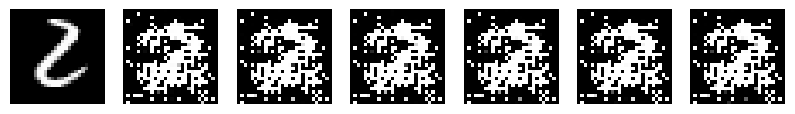

Epoch 5661 g_loss= 7.0418916 d_loss= 0.0009021032 real_acc= 1.0 fake_acc= 1.0
Epoch 5662 g_loss= 7.0943737 d_loss= 0.0008477521 real_acc= 1.0 fake_acc= 1.0
Epoch 5663 g_loss= 7.03253 d_loss= 0.00091031904 real_acc= 1.0 fake_acc= 1.0
Epoch 5664 g_loss= 7.038387 d_loss= 0.0008980273 real_acc= 1.0 fake_acc= 1.0
Epoch 5665 g_loss= 7.0574675 d_loss= 0.0008823563 real_acc= 1.0 fake_acc= 1.0
Epoch 5666 g_loss= 7.065296 d_loss= 0.0008796537 real_acc= 1.0 fake_acc= 1.0
Epoch 5667 g_loss= 7.0779285 d_loss= 0.0008745768 real_acc= 1.0 fake_acc= 1.0
Epoch 5668 g_loss= 7.043844 d_loss= 0.0008961293 real_acc= 1.0 fake_acc= 1.0
Epoch 5669 g_loss= 7.049421 d_loss= 0.000886672 real_acc= 1.0 fake_acc= 1.0
Epoch 5670 g_loss= 7.0851398 d_loss= 0.0008672909 real_acc= 1.0 fake_acc= 1.0


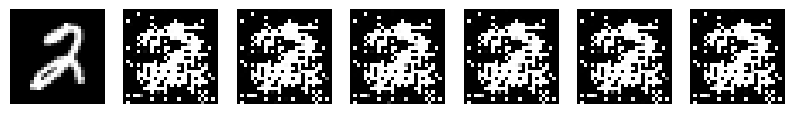

Epoch 5671 g_loss= 7.037793 d_loss= 0.00090395735 real_acc= 1.0 fake_acc= 1.0
Epoch 5672 g_loss= 7.06442 d_loss= 0.00087962905 real_acc= 1.0 fake_acc= 1.0
Epoch 5673 g_loss= 7.056967 d_loss= 0.00087861135 real_acc= 1.0 fake_acc= 1.0
Epoch 5674 g_loss= 7.071732 d_loss= 0.000870343 real_acc= 1.0 fake_acc= 1.0
Epoch 5675 g_loss= 7.128512 d_loss= 0.00082384737 real_acc= 1.0 fake_acc= 1.0
Epoch 5676 g_loss= 7.1462007 d_loss= 0.0008106623 real_acc= 1.0 fake_acc= 1.0
Epoch 5677 g_loss= 7.08104 d_loss= 0.0008659706 real_acc= 1.0 fake_acc= 1.0
Epoch 5678 g_loss= 7.0828924 d_loss= 0.0008703721 real_acc= 1.0 fake_acc= 1.0
Epoch 5679 g_loss= 7.0976872 d_loss= 0.00085197703 real_acc= 1.0 fake_acc= 1.0
Epoch 5680 g_loss= 7.1118507 d_loss= 0.0008344378 real_acc= 1.0 fake_acc= 1.0


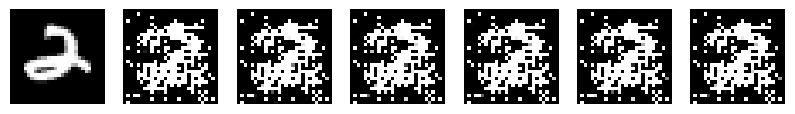

Epoch 5681 g_loss= 7.0593915 d_loss= 0.00088994013 real_acc= 1.0 fake_acc= 1.0
Epoch 5682 g_loss= 7.0302362 d_loss= 0.0009109551 real_acc= 1.0 fake_acc= 1.0
Epoch 5683 g_loss= 7.130951 d_loss= 0.0008214066 real_acc= 1.0 fake_acc= 1.0
Epoch 5684 g_loss= 7.0835967 d_loss= 0.0008606227 real_acc= 1.0 fake_acc= 1.0
Epoch 5685 g_loss= 7.052896 d_loss= 0.00088702445 real_acc= 1.0 fake_acc= 1.0
Epoch 5686 g_loss= 7.097204 d_loss= 0.0008504422 real_acc= 1.0 fake_acc= 1.0
Epoch 5687 g_loss= 7.1450353 d_loss= 0.0008055222 real_acc= 1.0 fake_acc= 1.0
Epoch 5688 g_loss= 7.155598 d_loss= 0.000802771 real_acc= 1.0 fake_acc= 1.0
Epoch 5689 g_loss= 7.0956874 d_loss= 0.0008534281 real_acc= 1.0 fake_acc= 1.0
Epoch 5690 g_loss= 7.088745 d_loss= 0.00086814555 real_acc= 1.0 fake_acc= 1.0


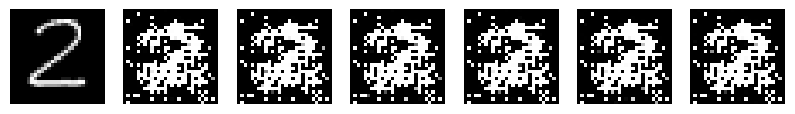

Epoch 5691 g_loss= 7.088798 d_loss= 0.00086102524 real_acc= 1.0 fake_acc= 1.0
Epoch 5692 g_loss= 7.1137547 d_loss= 0.0008374183 real_acc= 1.0 fake_acc= 1.0
Epoch 5693 g_loss= 7.187075 d_loss= 0.0007904365 real_acc= 1.0 fake_acc= 1.0
Epoch 5694 g_loss= 7.1023254 d_loss= 0.000842667 real_acc= 1.0 fake_acc= 1.0
Epoch 5695 g_loss= 7.0625005 d_loss= 0.0008848937 real_acc= 1.0 fake_acc= 1.0
Epoch 5696 g_loss= 7.1258116 d_loss= 0.0008298297 real_acc= 1.0 fake_acc= 1.0
Epoch 5697 g_loss= 7.1101794 d_loss= 0.0008488228 real_acc= 1.0 fake_acc= 1.0
Epoch 5698 g_loss= 7.0879726 d_loss= 0.000860913 real_acc= 1.0 fake_acc= 1.0
Epoch 5699 g_loss= 7.1338677 d_loss= 0.00081579556 real_acc= 1.0 fake_acc= 1.0
Epoch 5700 g_loss= 7.1104927 d_loss= 0.0008516948 real_acc= 1.0 fake_acc= 1.0


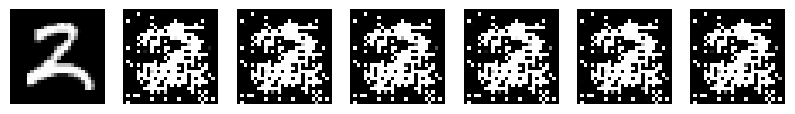

Epoch 5701 g_loss= 7.1879473 d_loss= 0.00077900046 real_acc= 1.0 fake_acc= 1.0
Epoch 5702 g_loss= 7.0633717 d_loss= 0.0008858311 real_acc= 1.0 fake_acc= 1.0
Epoch 5703 g_loss= 7.160593 d_loss= 0.00079983665 real_acc= 1.0 fake_acc= 1.0
Epoch 5704 g_loss= 7.1746345 d_loss= 0.0007858789 real_acc= 1.0 fake_acc= 1.0
Epoch 5705 g_loss= 7.0505714 d_loss= 0.0008935437 real_acc= 1.0 fake_acc= 1.0
Epoch 5706 g_loss= 7.137551 d_loss= 0.0008143596 real_acc= 1.0 fake_acc= 1.0
Epoch 5707 g_loss= 7.1651635 d_loss= 0.0007966126 real_acc= 1.0 fake_acc= 1.0
Epoch 5708 g_loss= 7.138083 d_loss= 0.00081672805 real_acc= 1.0 fake_acc= 1.0
Epoch 5709 g_loss= 7.153797 d_loss= 0.00080824614 real_acc= 1.0 fake_acc= 1.0
Epoch 5710 g_loss= 7.0584373 d_loss= 0.0008889187 real_acc= 1.0 fake_acc= 1.0


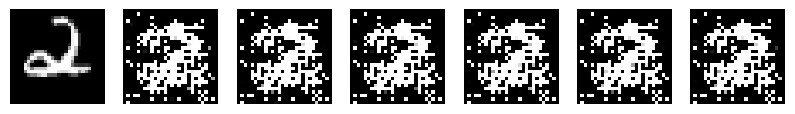

Epoch 5711 g_loss= 7.1459026 d_loss= 0.00081711984 real_acc= 1.0 fake_acc= 1.0
Epoch 5712 g_loss= 7.1771793 d_loss= 0.0007894915 real_acc= 1.0 fake_acc= 1.0
Epoch 5713 g_loss= 7.109478 d_loss= 0.000849164 real_acc= 1.0 fake_acc= 1.0
Epoch 5714 g_loss= 7.184653 d_loss= 0.0007830482 real_acc= 1.0 fake_acc= 1.0
Epoch 5715 g_loss= 7.194434 d_loss= 0.0007714096 real_acc= 1.0 fake_acc= 1.0
Epoch 5716 g_loss= 7.147984 d_loss= 0.0008114206 real_acc= 1.0 fake_acc= 1.0
Epoch 5717 g_loss= 7.1538973 d_loss= 0.00080607017 real_acc= 1.0 fake_acc= 1.0
Epoch 5718 g_loss= 7.1818633 d_loss= 0.0007824732 real_acc= 1.0 fake_acc= 1.0
Epoch 5719 g_loss= 7.148211 d_loss= 0.000813515 real_acc= 1.0 fake_acc= 1.0
Epoch 5720 g_loss= 7.1780305 d_loss= 0.00078697974 real_acc= 1.0 fake_acc= 1.0


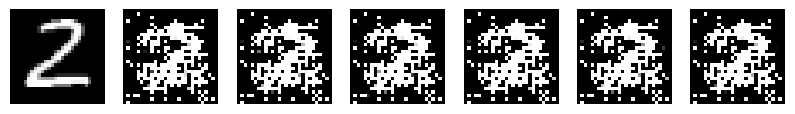

Epoch 5721 g_loss= 7.159598 d_loss= 0.00079838483 real_acc= 1.0 fake_acc= 1.0
Epoch 5722 g_loss= 7.188015 d_loss= 0.00077574304 real_acc= 1.0 fake_acc= 1.0
Epoch 5723 g_loss= 7.22997 d_loss= 0.0007472884 real_acc= 1.0 fake_acc= 1.0
Epoch 5724 g_loss= 7.116457 d_loss= 0.00083402643 real_acc= 1.0 fake_acc= 1.0
Epoch 5725 g_loss= 7.206239 d_loss= 0.00076513656 real_acc= 1.0 fake_acc= 1.0
Epoch 5726 g_loss= 7.2060046 d_loss= 0.0007627449 real_acc= 1.0 fake_acc= 1.0
Epoch 5727 g_loss= 7.173967 d_loss= 0.0007883534 real_acc= 1.0 fake_acc= 1.0
Epoch 5728 g_loss= 7.1837635 d_loss= 0.0007799571 real_acc= 1.0 fake_acc= 1.0
Epoch 5729 g_loss= 7.15588 d_loss= 0.00080714596 real_acc= 1.0 fake_acc= 1.0
Epoch 5730 g_loss= 7.1659193 d_loss= 0.00079489866 real_acc= 1.0 fake_acc= 1.0


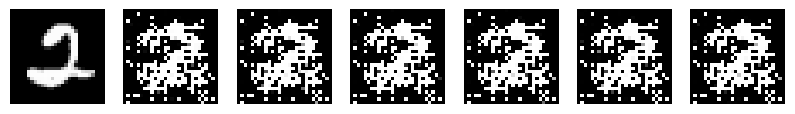

Epoch 5731 g_loss= 7.203609 d_loss= 0.0007714563 real_acc= 1.0 fake_acc= 1.0
Epoch 5732 g_loss= 7.2026234 d_loss= 0.0007597234 real_acc= 1.0 fake_acc= 1.0
Epoch 5733 g_loss= 7.206425 d_loss= 0.0007766618 real_acc= 1.0 fake_acc= 1.0
Epoch 5734 g_loss= 7.242746 d_loss= 0.0007405387 real_acc= 1.0 fake_acc= 1.0
Epoch 5735 g_loss= 7.206903 d_loss= 0.0007689028 real_acc= 1.0 fake_acc= 1.0
Epoch 5736 g_loss= 7.2038865 d_loss= 0.0007613539 real_acc= 1.0 fake_acc= 1.0
Epoch 5737 g_loss= 7.207023 d_loss= 0.00077203865 real_acc= 1.0 fake_acc= 1.0
Epoch 5738 g_loss= 7.202791 d_loss= 0.0007617274 real_acc= 1.0 fake_acc= 1.0
Epoch 5739 g_loss= 7.1281114 d_loss= 0.00082758965 real_acc= 1.0 fake_acc= 1.0
Epoch 5740 g_loss= 7.296269 d_loss= 0.0006969635 real_acc= 1.0 fake_acc= 1.0


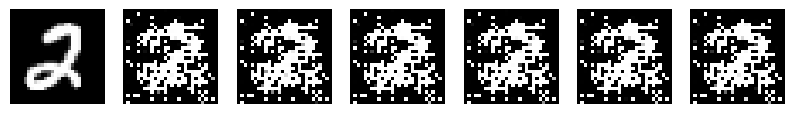

Epoch 5741 g_loss= 7.2430706 d_loss= 0.0007418021 real_acc= 1.0 fake_acc= 1.0
Epoch 5742 g_loss= 7.197943 d_loss= 0.00077065115 real_acc= 1.0 fake_acc= 1.0
Epoch 5743 g_loss= 7.2559266 d_loss= 0.00073412823 real_acc= 1.0 fake_acc= 1.0
Epoch 5744 g_loss= 7.2420506 d_loss= 0.00074627117 real_acc= 1.0 fake_acc= 1.0
Epoch 5745 g_loss= 7.3033495 d_loss= 0.00069088105 real_acc= 1.0 fake_acc= 1.0
Epoch 5746 g_loss= 7.2246513 d_loss= 0.0007513395 real_acc= 1.0 fake_acc= 1.0
Epoch 5747 g_loss= 7.2829356 d_loss= 0.0007129022 real_acc= 1.0 fake_acc= 1.0
Epoch 5748 g_loss= 7.228733 d_loss= 0.0007484509 real_acc= 1.0 fake_acc= 1.0
Epoch 5749 g_loss= 7.198599 d_loss= 0.00076776533 real_acc= 1.0 fake_acc= 1.0
Epoch 5750 g_loss= 7.229207 d_loss= 0.0007445065 real_acc= 1.0 fake_acc= 1.0


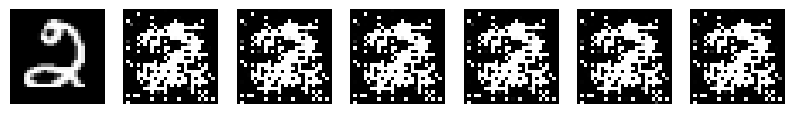

Epoch 5751 g_loss= 7.258613 d_loss= 0.0007240767 real_acc= 1.0 fake_acc= 1.0
Epoch 5752 g_loss= 7.2297454 d_loss= 0.000741754 real_acc= 1.0 fake_acc= 1.0
Epoch 5753 g_loss= 7.259198 d_loss= 0.00072954677 real_acc= 1.0 fake_acc= 1.0
Epoch 5754 g_loss= 7.2403765 d_loss= 0.00074180856 real_acc= 1.0 fake_acc= 1.0
Epoch 5755 g_loss= 7.247593 d_loss= 0.00073166983 real_acc= 1.0 fake_acc= 1.0
Epoch 5756 g_loss= 7.290515 d_loss= 0.0006951294 real_acc= 1.0 fake_acc= 1.0
Epoch 5757 g_loss= 7.229418 d_loss= 0.0007436369 real_acc= 1.0 fake_acc= 1.0
Epoch 5758 g_loss= 7.250965 d_loss= 0.0007281433 real_acc= 1.0 fake_acc= 1.0
Epoch 5759 g_loss= 7.236456 d_loss= 0.0007438003 real_acc= 1.0 fake_acc= 1.0
Epoch 5760 g_loss= 7.245578 d_loss= 0.0007381227 real_acc= 1.0 fake_acc= 1.0


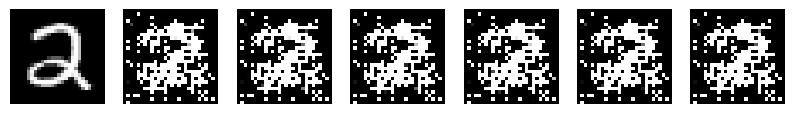

Epoch 5761 g_loss= 7.1793933 d_loss= 0.00079407357 real_acc= 1.0 fake_acc= 1.0
Epoch 5762 g_loss= 7.2726274 d_loss= 0.0007181117 real_acc= 1.0 fake_acc= 1.0
Epoch 5763 g_loss= 7.2530804 d_loss= 0.0007254036 real_acc= 1.0 fake_acc= 1.0
Epoch 5764 g_loss= 7.2483063 d_loss= 0.0007315068 real_acc= 1.0 fake_acc= 1.0
Epoch 5765 g_loss= 7.252084 d_loss= 0.00073683873 real_acc= 1.0 fake_acc= 1.0
Epoch 5766 g_loss= 7.3088136 d_loss= 0.00068699615 real_acc= 1.0 fake_acc= 1.0
Epoch 5767 g_loss= 7.257784 d_loss= 0.0007216884 real_acc= 1.0 fake_acc= 1.0
Epoch 5768 g_loss= 7.235681 d_loss= 0.00074865535 real_acc= 1.0 fake_acc= 1.0
Epoch 5769 g_loss= 7.232586 d_loss= 0.0007479547 real_acc= 1.0 fake_acc= 1.0
Epoch 5770 g_loss= 7.2627516 d_loss= 0.00072305626 real_acc= 1.0 fake_acc= 1.0


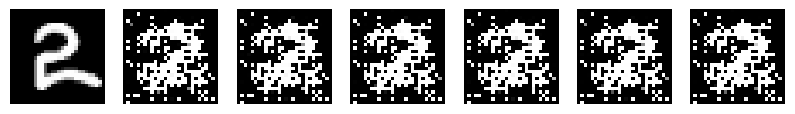

Epoch 5771 g_loss= 7.251756 d_loss= 0.0007331647 real_acc= 1.0 fake_acc= 1.0
Epoch 5772 g_loss= 7.3223186 d_loss= 0.00068186485 real_acc= 1.0 fake_acc= 1.0
Epoch 5773 g_loss= 7.244718 d_loss= 0.00073267973 real_acc= 1.0 fake_acc= 1.0
Epoch 5774 g_loss= 7.3025208 d_loss= 0.00069566787 real_acc= 1.0 fake_acc= 1.0
Epoch 5775 g_loss= 7.2787037 d_loss= 0.0007054811 real_acc= 1.0 fake_acc= 1.0
Epoch 5776 g_loss= 7.2308655 d_loss= 0.0007526765 real_acc= 1.0 fake_acc= 1.0
Epoch 5777 g_loss= 7.2929673 d_loss= 0.0006951333 real_acc= 1.0 fake_acc= 1.0
Epoch 5778 g_loss= 7.2772264 d_loss= 0.00071172905 real_acc= 1.0 fake_acc= 1.0
Epoch 5779 g_loss= 7.2267785 d_loss= 0.0007444859 real_acc= 1.0 fake_acc= 1.0
Epoch 5780 g_loss= 7.353225 d_loss= 0.00066210225 real_acc= 1.0 fake_acc= 1.0


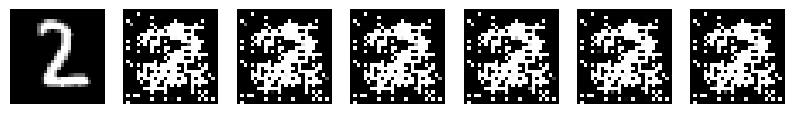

Epoch 5781 g_loss= 7.268664 d_loss= 0.00071738963 real_acc= 1.0 fake_acc= 1.0
Epoch 5782 g_loss= 7.251805 d_loss= 0.00073649414 real_acc= 1.0 fake_acc= 1.0
Epoch 5783 g_loss= 7.259596 d_loss= 0.00072723854 real_acc= 1.0 fake_acc= 1.0
Epoch 5784 g_loss= 7.3144183 d_loss= 0.00068716786 real_acc= 1.0 fake_acc= 1.0
Epoch 5785 g_loss= 7.2137513 d_loss= 0.00076568034 real_acc= 1.0 fake_acc= 1.0
Epoch 5786 g_loss= 7.3562837 d_loss= 0.0006608993 real_acc= 1.0 fake_acc= 1.0
Epoch 5787 g_loss= 7.3627944 d_loss= 0.0006639482 real_acc= 1.0 fake_acc= 1.0
Epoch 5788 g_loss= 7.280082 d_loss= 0.0007170537 real_acc= 1.0 fake_acc= 1.0
Epoch 5789 g_loss= 7.2914705 d_loss= 0.0006913891 real_acc= 1.0 fake_acc= 1.0
Epoch 5790 g_loss= 7.316956 d_loss= 0.0006873823 real_acc= 1.0 fake_acc= 1.0


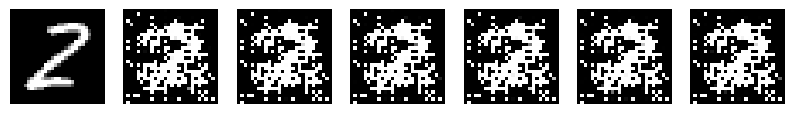

Epoch 5791 g_loss= 7.293066 d_loss= 0.0006995599 real_acc= 1.0 fake_acc= 1.0
Epoch 5792 g_loss= 7.262255 d_loss= 0.0007247004 real_acc= 1.0 fake_acc= 1.0
Epoch 5793 g_loss= 7.312899 d_loss= 0.0006777156 real_acc= 1.0 fake_acc= 1.0
Epoch 5794 g_loss= 7.294861 d_loss= 0.00069705636 real_acc= 1.0 fake_acc= 1.0
Epoch 5795 g_loss= 7.327185 d_loss= 0.0006785735 real_acc= 1.0 fake_acc= 1.0
Epoch 5796 g_loss= 7.2693458 d_loss= 0.0007285027 real_acc= 1.0 fake_acc= 1.0
Epoch 5797 g_loss= 7.361341 d_loss= 0.00065404276 real_acc= 1.0 fake_acc= 1.0
Epoch 5798 g_loss= 7.3311806 d_loss= 0.0006796218 real_acc= 1.0 fake_acc= 1.0
Epoch 5799 g_loss= 7.3134475 d_loss= 0.00070576614 real_acc= 1.0 fake_acc= 1.0
Epoch 5800 g_loss= 7.381145 d_loss= 0.0006417026 real_acc= 1.0 fake_acc= 1.0


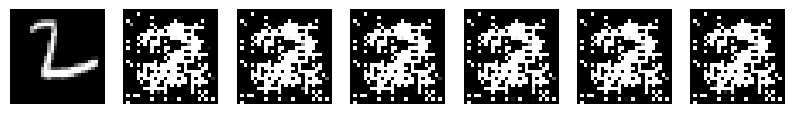

Epoch 5801 g_loss= 7.3609176 d_loss= 0.00065492303 real_acc= 1.0 fake_acc= 1.0
Epoch 5802 g_loss= 7.3359547 d_loss= 0.00067381107 real_acc= 1.0 fake_acc= 1.0
Epoch 5803 g_loss= 7.3520513 d_loss= 0.00067119417 real_acc= 1.0 fake_acc= 1.0
Epoch 5804 g_loss= 7.3334637 d_loss= 0.00066983496 real_acc= 1.0 fake_acc= 1.0
Epoch 5805 g_loss= 7.3861322 d_loss= 0.00063898356 real_acc= 1.0 fake_acc= 1.0
Epoch 5806 g_loss= 7.2972865 d_loss= 0.0006968414 real_acc= 1.0 fake_acc= 1.0
Epoch 5807 g_loss= 7.2842216 d_loss= 0.00070723624 real_acc= 1.0 fake_acc= 1.0
Epoch 5808 g_loss= 7.353913 d_loss= 0.0006527642 real_acc= 1.0 fake_acc= 1.0
Epoch 5809 g_loss= 7.337222 d_loss= 0.00067555404 real_acc= 1.0 fake_acc= 1.0
Epoch 5810 g_loss= 7.3563304 d_loss= 0.00066170446 real_acc= 1.0 fake_acc= 1.0


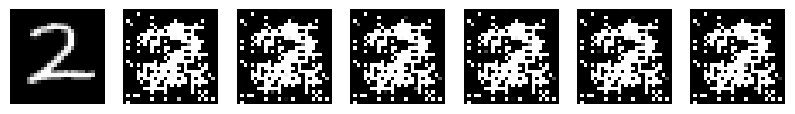

Epoch 5811 g_loss= 7.291478 d_loss= 0.00070179923 real_acc= 1.0 fake_acc= 1.0
Epoch 5812 g_loss= 7.4191856 d_loss= 0.0006168807 real_acc= 1.0 fake_acc= 1.0
Epoch 5813 g_loss= 7.2828274 d_loss= 0.0007052591 real_acc= 1.0 fake_acc= 1.0
Epoch 5814 g_loss= 7.417024 d_loss= 0.0006192149 real_acc= 1.0 fake_acc= 1.0
Epoch 5815 g_loss= 7.38928 d_loss= 0.0006353834 real_acc= 1.0 fake_acc= 1.0
Epoch 5816 g_loss= 7.282916 d_loss= 0.0007075164 real_acc= 1.0 fake_acc= 1.0
Epoch 5817 g_loss= 7.42647 d_loss= 0.0006150171 real_acc= 1.0 fake_acc= 1.0
Epoch 5818 g_loss= 7.3412085 d_loss= 0.0006690469 real_acc= 1.0 fake_acc= 1.0
Epoch 5819 g_loss= 7.3550377 d_loss= 0.00065769197 real_acc= 1.0 fake_acc= 1.0
Epoch 5820 g_loss= 7.436748 d_loss= 0.0006139401 real_acc= 1.0 fake_acc= 1.0


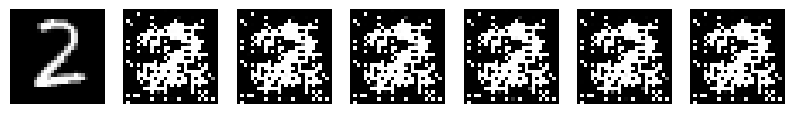

Epoch 5821 g_loss= 7.353518 d_loss= 0.00066673756 real_acc= 1.0 fake_acc= 1.0
Epoch 5822 g_loss= 7.393459 d_loss= 0.00063184096 real_acc= 1.0 fake_acc= 1.0
Epoch 5823 g_loss= 7.3031535 d_loss= 0.00069283583 real_acc= 1.0 fake_acc= 1.0
Epoch 5824 g_loss= 7.41168 d_loss= 0.00061604416 real_acc= 1.0 fake_acc= 1.0
Epoch 5825 g_loss= 7.377147 d_loss= 0.00064390234 real_acc= 1.0 fake_acc= 1.0
Epoch 5826 g_loss= 7.427063 d_loss= 0.0006113745 real_acc= 1.0 fake_acc= 1.0
Epoch 5827 g_loss= 7.42429 d_loss= 0.0006173666 real_acc= 1.0 fake_acc= 1.0
Epoch 5828 g_loss= 7.322163 d_loss= 0.0006821928 real_acc= 1.0 fake_acc= 1.0
Epoch 5829 g_loss= 7.3978786 d_loss= 0.0006325674 real_acc= 1.0 fake_acc= 1.0
Epoch 5830 g_loss= 7.383757 d_loss= 0.00063871784 real_acc= 1.0 fake_acc= 1.0


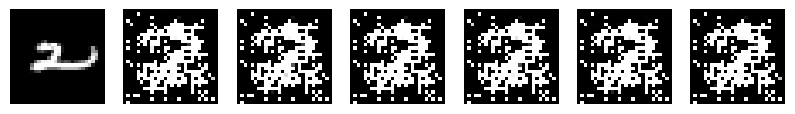

Epoch 5831 g_loss= 7.378762 d_loss= 0.00063996686 real_acc= 1.0 fake_acc= 1.0
Epoch 5832 g_loss= 7.367565 d_loss= 0.0006514074 real_acc= 1.0 fake_acc= 1.0
Epoch 5833 g_loss= 7.398834 d_loss= 0.0006327425 real_acc= 1.0 fake_acc= 1.0
Epoch 5834 g_loss= 7.373819 d_loss= 0.00065113866 real_acc= 1.0 fake_acc= 1.0
Epoch 5835 g_loss= 7.402897 d_loss= 0.0006326461 real_acc= 1.0 fake_acc= 1.0
Epoch 5836 g_loss= 7.3374343 d_loss= 0.0006712193 real_acc= 1.0 fake_acc= 1.0
Epoch 5837 g_loss= 7.468558 d_loss= 0.00058922265 real_acc= 1.0 fake_acc= 1.0
Epoch 5838 g_loss= 7.3956275 d_loss= 0.000636635 real_acc= 1.0 fake_acc= 1.0
Epoch 5839 g_loss= 7.3585334 d_loss= 0.0006615732 real_acc= 1.0 fake_acc= 1.0
Epoch 5840 g_loss= 7.3715115 d_loss= 0.0006526902 real_acc= 1.0 fake_acc= 1.0


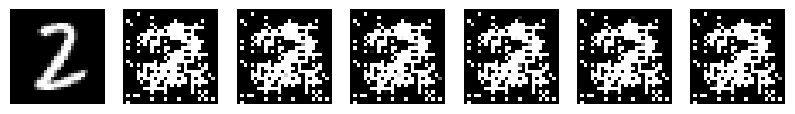

Epoch 5841 g_loss= 7.381313 d_loss= 0.0006430525 real_acc= 1.0 fake_acc= 1.0
Epoch 5842 g_loss= 7.413426 d_loss= 0.000621524 real_acc= 1.0 fake_acc= 1.0
Epoch 5843 g_loss= 7.3840613 d_loss= 0.0006372862 real_acc= 1.0 fake_acc= 1.0
Epoch 5844 g_loss= 7.386458 d_loss= 0.0006434633 real_acc= 1.0 fake_acc= 1.0
Epoch 5845 g_loss= 7.3905315 d_loss= 0.00063342036 real_acc= 1.0 fake_acc= 1.0
Epoch 5846 g_loss= 7.378573 d_loss= 0.0006385559 real_acc= 1.0 fake_acc= 1.0
Epoch 5847 g_loss= 7.3629975 d_loss= 0.0006595366 real_acc= 1.0 fake_acc= 1.0
Epoch 5848 g_loss= 7.344094 d_loss= 0.0006694317 real_acc= 1.0 fake_acc= 1.0
Epoch 5849 g_loss= 7.425999 d_loss= 0.00061987207 real_acc= 1.0 fake_acc= 1.0
Epoch 5850 g_loss= 7.365651 d_loss= 0.000658312 real_acc= 1.0 fake_acc= 1.0


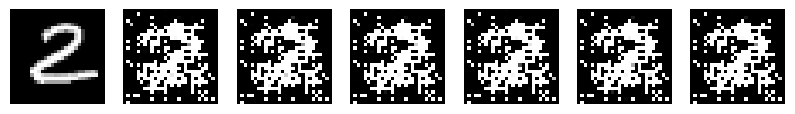

Epoch 5851 g_loss= 7.3809633 d_loss= 0.0006448243 real_acc= 1.0 fake_acc= 1.0
Epoch 5852 g_loss= 7.4526124 d_loss= 0.0005980207 real_acc= 1.0 fake_acc= 1.0
Epoch 5853 g_loss= 7.358013 d_loss= 0.0006580086 real_acc= 1.0 fake_acc= 1.0
Epoch 5854 g_loss= 7.4144096 d_loss= 0.0006190503 real_acc= 1.0 fake_acc= 1.0
Epoch 5855 g_loss= 7.4029975 d_loss= 0.000620577 real_acc= 1.0 fake_acc= 1.0
Epoch 5856 g_loss= 7.4128127 d_loss= 0.00062645343 real_acc= 1.0 fake_acc= 1.0
Epoch 5857 g_loss= 7.4631343 d_loss= 0.000596163 real_acc= 1.0 fake_acc= 1.0
Epoch 5858 g_loss= 7.4913416 d_loss= 0.0005768903 real_acc= 1.0 fake_acc= 1.0
Epoch 5859 g_loss= 7.4187727 d_loss= 0.0006147308 real_acc= 1.0 fake_acc= 1.0
Epoch 5860 g_loss= 7.401077 d_loss= 0.00062878104 real_acc= 1.0 fake_acc= 1.0


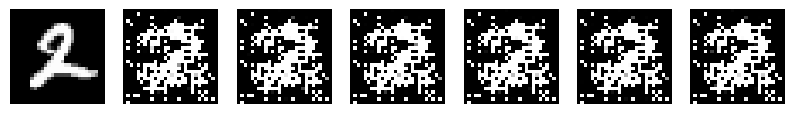

Epoch 5861 g_loss= 7.480355 d_loss= 0.00058383134 real_acc= 1.0 fake_acc= 1.0
Epoch 5862 g_loss= 7.4734263 d_loss= 0.00058687275 real_acc= 1.0 fake_acc= 1.0
Epoch 5863 g_loss= 7.440012 d_loss= 0.0006119774 real_acc= 1.0 fake_acc= 1.0
Epoch 5864 g_loss= 7.442731 d_loss= 0.00060364103 real_acc= 1.0 fake_acc= 1.0
Epoch 5865 g_loss= 7.4388094 d_loss= 0.00060697773 real_acc= 1.0 fake_acc= 1.0
Epoch 5866 g_loss= 7.4551463 d_loss= 0.0005923424 real_acc= 1.0 fake_acc= 1.0
Epoch 5867 g_loss= 7.413661 d_loss= 0.00062105805 real_acc= 1.0 fake_acc= 1.0
Epoch 5868 g_loss= 7.456987 d_loss= 0.0005982607 real_acc= 1.0 fake_acc= 1.0
Epoch 5869 g_loss= 7.4790363 d_loss= 0.0005792872 real_acc= 1.0 fake_acc= 1.0
Epoch 5870 g_loss= 7.4733653 d_loss= 0.0005893677 real_acc= 1.0 fake_acc= 1.0


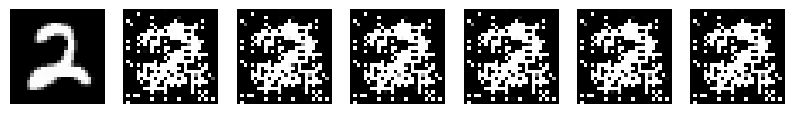

Epoch 5871 g_loss= 7.363487 d_loss= 0.00065414055 real_acc= 1.0 fake_acc= 1.0
Epoch 5872 g_loss= 7.517023 d_loss= 0.0005584811 real_acc= 1.0 fake_acc= 1.0
Epoch 5873 g_loss= 7.475131 d_loss= 0.00057880743 real_acc= 1.0 fake_acc= 1.0
Epoch 5874 g_loss= 7.438158 d_loss= 0.0006075841 real_acc= 1.0 fake_acc= 1.0
Epoch 5875 g_loss= 7.4941583 d_loss= 0.00057693885 real_acc= 1.0 fake_acc= 1.0
Epoch 5876 g_loss= 7.474847 d_loss= 0.000583196 real_acc= 1.0 fake_acc= 1.0
Epoch 5877 g_loss= 7.42387 d_loss= 0.0006156358 real_acc= 1.0 fake_acc= 1.0
Epoch 5878 g_loss= 7.423699 d_loss= 0.0006162003 real_acc= 1.0 fake_acc= 1.0
Epoch 5879 g_loss= 7.5033126 d_loss= 0.00056902657 real_acc= 1.0 fake_acc= 1.0
Epoch 5880 g_loss= 7.447087 d_loss= 0.0005999736 real_acc= 1.0 fake_acc= 1.0


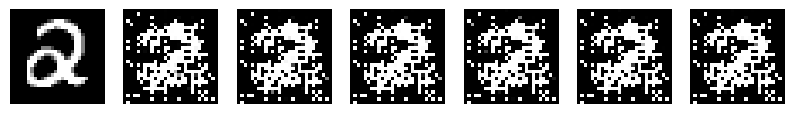

Epoch 5881 g_loss= 7.4883785 d_loss= 0.00057607173 real_acc= 1.0 fake_acc= 1.0
Epoch 5882 g_loss= 7.4558926 d_loss= 0.00059723854 real_acc= 1.0 fake_acc= 1.0
Epoch 5883 g_loss= 7.4735327 d_loss= 0.0005843938 real_acc= 1.0 fake_acc= 1.0
Epoch 5884 g_loss= 7.482007 d_loss= 0.0005815065 real_acc= 1.0 fake_acc= 1.0
Epoch 5885 g_loss= 7.510779 d_loss= 0.000560363 real_acc= 1.0 fake_acc= 1.0
Epoch 5886 g_loss= 7.49753 d_loss= 0.00057584164 real_acc= 1.0 fake_acc= 1.0
Epoch 5887 g_loss= 7.464652 d_loss= 0.00059278036 real_acc= 1.0 fake_acc= 1.0
Epoch 5888 g_loss= 7.4541016 d_loss= 0.00059790135 real_acc= 1.0 fake_acc= 1.0
Epoch 5889 g_loss= 7.4760985 d_loss= 0.00058274606 real_acc= 1.0 fake_acc= 1.0
Epoch 5890 g_loss= 7.4307923 d_loss= 0.0006168869 real_acc= 1.0 fake_acc= 1.0


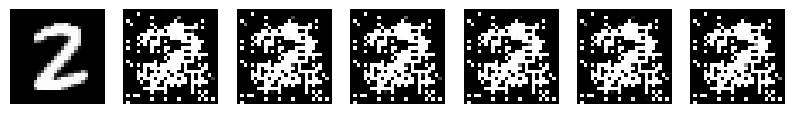

Epoch 5891 g_loss= 7.447445 d_loss= 0.00060290616 real_acc= 1.0 fake_acc= 1.0
Epoch 5892 g_loss= 7.463255 d_loss= 0.00058930775 real_acc= 1.0 fake_acc= 1.0
Epoch 5893 g_loss= 7.471564 d_loss= 0.00058640813 real_acc= 1.0 fake_acc= 1.0
Epoch 5894 g_loss= 7.492161 d_loss= 0.0005722782 real_acc= 1.0 fake_acc= 1.0
Epoch 5895 g_loss= 7.4680223 d_loss= 0.0005937058 real_acc= 1.0 fake_acc= 1.0
Epoch 5896 g_loss= 7.4358673 d_loss= 0.0006041471 real_acc= 1.0 fake_acc= 1.0
Epoch 5897 g_loss= 7.545631 d_loss= 0.0005470542 real_acc= 1.0 fake_acc= 1.0
Epoch 5898 g_loss= 7.4592566 d_loss= 0.00059216877 real_acc= 1.0 fake_acc= 1.0
Epoch 5899 g_loss= 7.416365 d_loss= 0.0006207967 real_acc= 1.0 fake_acc= 1.0
Epoch 5900 g_loss= 7.4624305 d_loss= 0.00059289637 real_acc= 1.0 fake_acc= 1.0


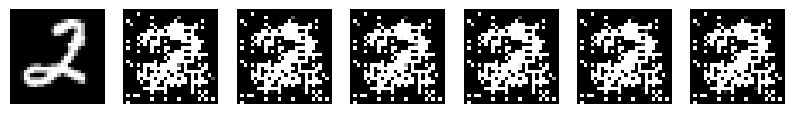

Epoch 5901 g_loss= 7.461195 d_loss= 0.0005947457 real_acc= 1.0 fake_acc= 1.0
Epoch 5902 g_loss= 7.4843864 d_loss= 0.0005775165 real_acc= 1.0 fake_acc= 1.0
Epoch 5903 g_loss= 7.5230193 d_loss= 0.0005570738 real_acc= 1.0 fake_acc= 1.0
Epoch 5904 g_loss= 7.506894 d_loss= 0.0005654248 real_acc= 1.0 fake_acc= 1.0
Epoch 5905 g_loss= 7.4380846 d_loss= 0.00060422916 real_acc= 1.0 fake_acc= 1.0
Epoch 5906 g_loss= 7.470484 d_loss= 0.00058722036 real_acc= 1.0 fake_acc= 1.0
Epoch 5907 g_loss= 7.46356 d_loss= 0.00058650074 real_acc= 1.0 fake_acc= 1.0
Epoch 5908 g_loss= 7.5522766 d_loss= 0.00053979096 real_acc= 1.0 fake_acc= 1.0
Epoch 5909 g_loss= 7.553347 d_loss= 0.0005401849 real_acc= 1.0 fake_acc= 1.0
Epoch 5910 g_loss= 7.480416 d_loss= 0.0005808779 real_acc= 1.0 fake_acc= 1.0


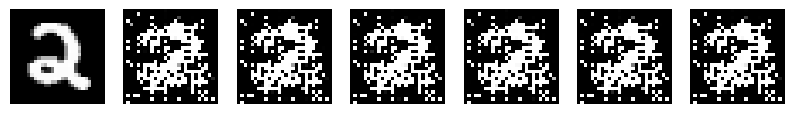

Epoch 5911 g_loss= 7.5207047 d_loss= 0.00055580423 real_acc= 1.0 fake_acc= 1.0
Epoch 5912 g_loss= 7.5220423 d_loss= 0.0005633563 real_acc= 1.0 fake_acc= 1.0
Epoch 5913 g_loss= 7.482697 d_loss= 0.0005817485 real_acc= 1.0 fake_acc= 1.0
Epoch 5914 g_loss= 7.4886937 d_loss= 0.00058104267 real_acc= 1.0 fake_acc= 1.0
Epoch 5915 g_loss= 7.4494624 d_loss= 0.0006027868 real_acc= 1.0 fake_acc= 1.0
Epoch 5916 g_loss= 7.5585656 d_loss= 0.0005465673 real_acc= 1.0 fake_acc= 1.0
Epoch 5917 g_loss= 7.5278535 d_loss= 0.00055158307 real_acc= 1.0 fake_acc= 1.0
Epoch 5918 g_loss= 7.5498 d_loss= 0.0005420835 real_acc= 1.0 fake_acc= 1.0
Epoch 5919 g_loss= 7.512532 d_loss= 0.00056360685 real_acc= 1.0 fake_acc= 1.0
Epoch 5920 g_loss= 7.471889 d_loss= 0.00058378023 real_acc= 1.0 fake_acc= 1.0


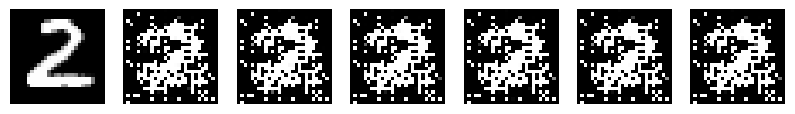

Epoch 5921 g_loss= 7.5419307 d_loss= 0.00054566236 real_acc= 1.0 fake_acc= 1.0
Epoch 5922 g_loss= 7.4637957 d_loss= 0.00058799854 real_acc= 1.0 fake_acc= 1.0
Epoch 5923 g_loss= 7.5678163 d_loss= 0.0005319403 real_acc= 1.0 fake_acc= 1.0
Epoch 5924 g_loss= 7.484625 d_loss= 0.0005781909 real_acc= 1.0 fake_acc= 1.0
Epoch 5925 g_loss= 7.508711 d_loss= 0.0005704923 real_acc= 1.0 fake_acc= 1.0
Epoch 5926 g_loss= 7.503894 d_loss= 0.0005786619 real_acc= 1.0 fake_acc= 1.0
Epoch 5927 g_loss= 7.5439467 d_loss= 0.00054613093 real_acc= 1.0 fake_acc= 1.0
Epoch 5928 g_loss= 7.5785007 d_loss= 0.00053337746 real_acc= 1.0 fake_acc= 1.0
Epoch 5929 g_loss= 7.5241857 d_loss= 0.0005559203 real_acc= 1.0 fake_acc= 1.0
Epoch 5930 g_loss= 7.5709376 d_loss= 0.00053451327 real_acc= 1.0 fake_acc= 1.0


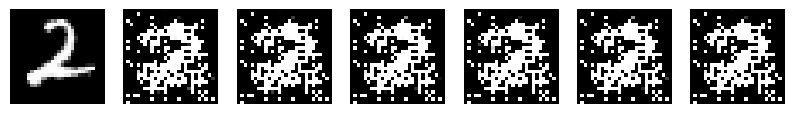

Epoch 5931 g_loss= 7.5041304 d_loss= 0.0005702561 real_acc= 1.0 fake_acc= 1.0
Epoch 5932 g_loss= 7.5155396 d_loss= 0.0005624621 real_acc= 1.0 fake_acc= 1.0
Epoch 5933 g_loss= 7.54125 d_loss= 0.0005464669 real_acc= 1.0 fake_acc= 1.0
Epoch 5934 g_loss= 7.623657 d_loss= 0.00050748506 real_acc= 1.0 fake_acc= 1.0
Epoch 5935 g_loss= 7.5134153 d_loss= 0.0005634548 real_acc= 1.0 fake_acc= 1.0
Epoch 5936 g_loss= 7.4753327 d_loss= 0.00058065687 real_acc= 1.0 fake_acc= 1.0
Epoch 5937 g_loss= 7.558689 d_loss= 0.00054229377 real_acc= 1.0 fake_acc= 1.0
Epoch 5938 g_loss= 7.5204744 d_loss= 0.00055943313 real_acc= 1.0 fake_acc= 1.0
Epoch 5939 g_loss= 7.578155 d_loss= 0.00052583613 real_acc= 1.0 fake_acc= 1.0
Epoch 5940 g_loss= 7.5365486 d_loss= 0.0005538426 real_acc= 1.0 fake_acc= 1.0


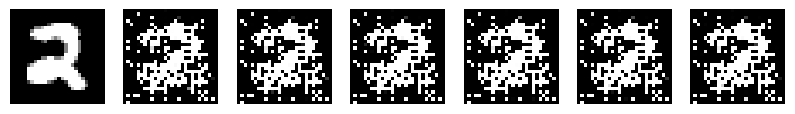

Epoch 5941 g_loss= 7.5520387 d_loss= 0.0005425882 real_acc= 1.0 fake_acc= 1.0
Epoch 5942 g_loss= 7.5427275 d_loss= 0.0005475604 real_acc= 1.0 fake_acc= 1.0
Epoch 5943 g_loss= 7.5861864 d_loss= 0.0005298311 real_acc= 1.0 fake_acc= 1.0
Epoch 5944 g_loss= 7.6221733 d_loss= 0.0005100612 real_acc= 1.0 fake_acc= 1.0
Epoch 5945 g_loss= 7.5454197 d_loss= 0.0005487531 real_acc= 1.0 fake_acc= 1.0
Epoch 5946 g_loss= 7.643036 d_loss= 0.0004948072 real_acc= 1.0 fake_acc= 1.0
Epoch 5947 g_loss= 7.654975 d_loss= 0.0004893638 real_acc= 1.0 fake_acc= 1.0
Epoch 5948 g_loss= 7.5194445 d_loss= 0.000556218 real_acc= 1.0 fake_acc= 1.0
Epoch 5949 g_loss= 7.6114473 d_loss= 0.000512426 real_acc= 1.0 fake_acc= 1.0
Epoch 5950 g_loss= 7.561885 d_loss= 0.0005408502 real_acc= 1.0 fake_acc= 1.0


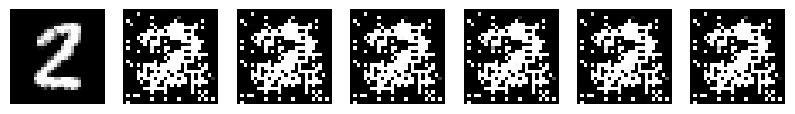

Epoch 5951 g_loss= 7.562855 d_loss= 0.0005328238 real_acc= 1.0 fake_acc= 1.0
Epoch 5952 g_loss= 7.5924473 d_loss= 0.00052223064 real_acc= 1.0 fake_acc= 1.0
Epoch 5953 g_loss= 7.6223326 d_loss= 0.00050736783 real_acc= 1.0 fake_acc= 1.0
Epoch 5954 g_loss= 7.6058903 d_loss= 0.0005220323 real_acc= 1.0 fake_acc= 1.0
Epoch 5955 g_loss= 7.580812 d_loss= 0.0005243534 real_acc= 1.0 fake_acc= 1.0
Epoch 5956 g_loss= 7.512006 d_loss= 0.00055666664 real_acc= 1.0 fake_acc= 1.0
Epoch 5957 g_loss= 7.5695667 d_loss= 0.0005398882 real_acc= 1.0 fake_acc= 1.0
Epoch 5958 g_loss= 7.601585 d_loss= 0.0005192663 real_acc= 1.0 fake_acc= 1.0
Epoch 5959 g_loss= 7.5986714 d_loss= 0.0005166816 real_acc= 1.0 fake_acc= 1.0
Epoch 5960 g_loss= 7.6073613 d_loss= 0.0005101725 real_acc= 1.0 fake_acc= 1.0


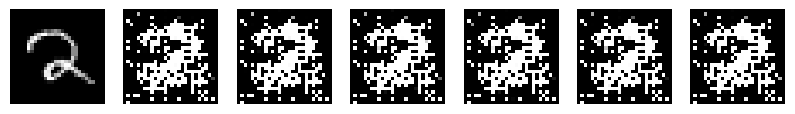

Epoch 5961 g_loss= 7.5819945 d_loss= 0.0005316201 real_acc= 1.0 fake_acc= 1.0
Epoch 5962 g_loss= 7.555377 d_loss= 0.0005374065 real_acc= 1.0 fake_acc= 1.0
Epoch 5963 g_loss= 7.657699 d_loss= 0.00048957334 real_acc= 1.0 fake_acc= 1.0
Epoch 5964 g_loss= 7.631892 d_loss= 0.0005011394 real_acc= 1.0 fake_acc= 1.0
Epoch 5965 g_loss= 7.6294084 d_loss= 0.0004979855 real_acc= 1.0 fake_acc= 1.0
Epoch 5966 g_loss= 7.6253743 d_loss= 0.0005005106 real_acc= 1.0 fake_acc= 1.0
Epoch 5967 g_loss= 7.588015 d_loss= 0.0005189635 real_acc= 1.0 fake_acc= 1.0
Epoch 5968 g_loss= 7.631076 d_loss= 0.00049895525 real_acc= 1.0 fake_acc= 1.0
Epoch 5969 g_loss= 7.620318 d_loss= 0.00050644134 real_acc= 1.0 fake_acc= 1.0
Epoch 5970 g_loss= 7.587309 d_loss= 0.000529131 real_acc= 1.0 fake_acc= 1.0


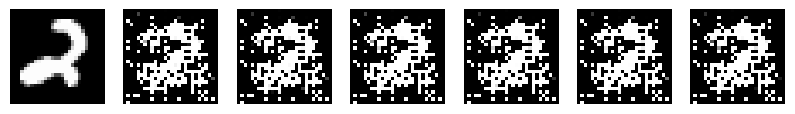

Epoch 5971 g_loss= 7.6808276 d_loss= 0.00047484404 real_acc= 1.0 fake_acc= 1.0
Epoch 5972 g_loss= 7.5763817 d_loss= 0.0005316373 real_acc= 1.0 fake_acc= 1.0
Epoch 5973 g_loss= 7.636408 d_loss= 0.0004963946 real_acc= 1.0 fake_acc= 1.0
Epoch 5974 g_loss= 7.6721582 d_loss= 0.0004799784 real_acc= 1.0 fake_acc= 1.0
Epoch 5975 g_loss= 7.5986824 d_loss= 0.00051487534 real_acc= 1.0 fake_acc= 1.0
Epoch 5976 g_loss= 7.6289983 d_loss= 0.00050596433 real_acc= 1.0 fake_acc= 1.0
Epoch 5977 g_loss= 7.691822 d_loss= 0.00047186844 real_acc= 1.0 fake_acc= 1.0
Epoch 5978 g_loss= 7.629278 d_loss= 0.0005021867 real_acc= 1.0 fake_acc= 1.0
Epoch 5979 g_loss= 7.607871 d_loss= 0.0005107534 real_acc= 1.0 fake_acc= 1.0
Epoch 5980 g_loss= 7.601507 d_loss= 0.00051195023 real_acc= 1.0 fake_acc= 1.0


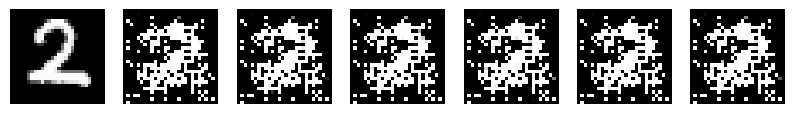

Epoch 5981 g_loss= 7.63802 d_loss= 0.00050048187 real_acc= 1.0 fake_acc= 1.0
Epoch 5982 g_loss= 7.6222315 d_loss= 0.00050076103 real_acc= 1.0 fake_acc= 1.0
Epoch 5983 g_loss= 7.6567144 d_loss= 0.0004927694 real_acc= 1.0 fake_acc= 1.0
Epoch 5984 g_loss= 7.6303654 d_loss= 0.0005040778 real_acc= 1.0 fake_acc= 1.0
Epoch 5985 g_loss= 7.648644 d_loss= 0.0004912367 real_acc= 1.0 fake_acc= 1.0
Epoch 5986 g_loss= 7.6184893 d_loss= 0.0005084929 real_acc= 1.0 fake_acc= 1.0
Epoch 5987 g_loss= 7.648905 d_loss= 0.0004917364 real_acc= 1.0 fake_acc= 1.0
Epoch 5988 g_loss= 7.6008315 d_loss= 0.00051722815 real_acc= 1.0 fake_acc= 1.0
Epoch 5989 g_loss= 7.690609 d_loss= 0.0004722199 real_acc= 1.0 fake_acc= 1.0
Epoch 5990 g_loss= 7.7554917 d_loss= 0.00044114102 real_acc= 1.0 fake_acc= 1.0


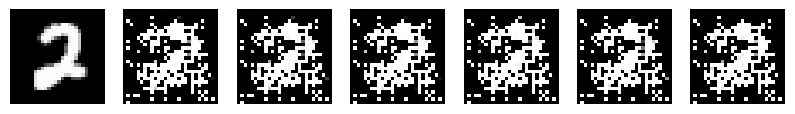

Epoch 5991 g_loss= 7.6466255 d_loss= 0.0004942026 real_acc= 1.0 fake_acc= 1.0
Epoch 5992 g_loss= 7.660767 d_loss= 0.0004849765 real_acc= 1.0 fake_acc= 1.0
Epoch 5993 g_loss= 7.5936937 d_loss= 0.00052102265 real_acc= 1.0 fake_acc= 1.0
Epoch 5994 g_loss= 7.6310363 d_loss= 0.00049939536 real_acc= 1.0 fake_acc= 1.0
Epoch 5995 g_loss= 7.659044 d_loss= 0.0004853044 real_acc= 1.0 fake_acc= 1.0
Epoch 5996 g_loss= 7.7000103 d_loss= 0.00046545657 real_acc= 1.0 fake_acc= 1.0
Epoch 5997 g_loss= 7.6214204 d_loss= 0.0005082127 real_acc= 1.0 fake_acc= 1.0
Epoch 5998 g_loss= 7.6625953 d_loss= 0.00048831006 real_acc= 1.0 fake_acc= 1.0
Epoch 5999 g_loss= 7.641743 d_loss= 0.00049536856 real_acc= 1.0 fake_acc= 1.0
Done


In [13]:
epochs = 2000
for epoch in range(epochs):
    # take some random samples
    new_samples = sample_from_dataset(50,testSamples)
    # perform one training step (epoch)
    do_step(new_samples)

    if epoch % 10 == 0:
        # show one real image and some fake images generated by generator using noise seed
        #display.clear_output(wait=True)
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(testSamples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(testSamples[r, :, :] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()
print("Done")